In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the Data
reference: https://www.kaggle.com/code/jetakow/home-credit-2024-starter-notebook


In [ ]:
import pandas as pd
import polars as pl
import numpy as np
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)
# dataPath = "/kaggle/input/home-credit-credit-risk-model-stability/"

dataPath = '/content/drive/MyDrive/bill/home-credit-credit-risk-model-stability/'

In [ ]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    # implement here all desired dtypes for tables
    # the following is just an example
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if df[col].dtype.name in ['object', 'string']:  # checks if the data type of each column is either object or string
            df[col] = df[col].astype("string").astype('category') # converts the column to a categorical dtype
            current_categories = df[col].cat.categories # retrieves the existing categories for that column
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

# Train data read from csv

In [ ]:
### Base Table:
train_basetable = pl.read_csv(dataPath + "csv_files/train/train_base.csv")

### FEATURES
train_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)

train_static_cb = pl.read_csv(dataPath + "csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(dataPath + "csv_files/train/train_person_1.csv").pipe(set_table_dtypes)
train_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes)

### delete this cell (only for reference)

In [ ]:
PATH_BASE_TRAIN = f'{dataPath}csv_files/train/train_base.csv'
PATH_BASE_TEST = f'{dataPath}/csv_files/test/test_base.csv'

train =  pd.read_csv(PATH_BASE_TRAIN)
test =   pd.read_csv(PATH_BASE_TEST)

display(train.head(3))
display(test.head(3))
display(train.dtypes)

case_id date_decision   MONTH  WEEK_NUM  target
0        0    2019-01-03  201901         0       0
1        1    2019-01-03  201901         0       0
2        2    2019-01-04  201901         0       0

case_id date_decision   MONTH  WEEK_NUM
0    57543    2020-10-06  202010        92
1    57549    2020-10-06  202010        92
2    57551    2020-10-06  202010        92

case_id           int64
date_decision    object
MONTH             int64
WEEK_NUM          int64
target            int64
dtype: object

In [ ]:
display(train_basetable.head(3))
# display(test.head(3))
display(train_basetable.dtypes)
print(train_credit_bureau_b_2.columns)
print(train_person_1.columns)
print(train_static_cb.columns)
print(train_static.columns)
print(train_basetable.columns)

shape: (3, 5)
┌─────────┬───────────────┬────────┬──────────┬────────┐
│ case_id ┆ date_decision ┆ MONTH  ┆ WEEK_NUM ┆ target │
│ ---     ┆ ---           ┆ ---    ┆ ---      ┆ ---    │
│ i64     ┆ str           ┆ i64    ┆ i64      ┆ i64    │
╞═════════╪═══════════════╪════════╪══════════╪════════╡
│ 0       ┆ 2019-01-03    ┆ 201901 ┆ 0        ┆ 0      │
│ 1       ┆ 2019-01-03    ┆ 201901 ┆ 0        ┆ 0      │
│ 2       ┆ 2019-01-04    ┆ 201901 ┆ 0        ┆ 0      │
└─────────┴───────────────┴────────┴──────────┴────────┘

[Int64, Utf8, Int64, Int64, Int64]

['case_id', 'num_group1', 'num_group2', 'pmts_date_1107D', 'pmts_dpdvalue_108P', 'pmts_pmtsoverdue_635A']
['case_id', 'birth_259D', 'birthdate_87D', 'childnum_185L', 'contaddr_district_15M', 'contaddr_matchlist_1032L', 'contaddr_smempladdr_334L', 'contaddr_zipcode_807M', 'education_927M', 'empl_employedfrom_271D', 'empl_employedtotal_800L', 'empl_industry_691L', 'empladdr_district_926M', 'empladdr_zipcode_114M', 'familystate_447L', 'gender_992L', 'housetype_905L', 'housingtype_772L', 'incometype_1044T', 'isreference_387L', 'language1_981M', 'mainoccupationinc_384A', 'maritalst_703L', 'num_group1', 'personindex_1023L', 'persontype_1072L', 'persontype_792L', 'registaddr_district_1083M', 'registaddr_zipcode_184M', 'relationshiptoclient_415T', 'relationshiptoclient_642T', 'remitter_829L', 'role_1084L', 'role_993L', 'safeguarantyflag_411L', 'sex_738L', 'type_25L']
['case_id', 'assignmentdate_238D', 'assignmentdate_4527235D', 'assignmentdate_4955616D', 'birthdate_574D', 'contractssum_5085716

In [ ]:
print(len(train_credit_bureau_b_2.columns) + len(train_person_1.columns)
+ len(train_static_cb.columns ))

96


In [ ]:
# # prompt: Left join equivalent function in  the polaris dataframes, after converting to pandas,  on case_id train_credit_bureau_b_2 print(train_person_1) print(train_static_cb) print(train_static) print(train_basetable)

# train_credit_bureau_b_2_pd = train_credit_bureau_b_2.to_pandas()
# train_person_1_pd = train_person_1.to_pandas()
# train_static_cb = train_static_cb.to_pandas()
# train_static = train_static.to_pandas()
# train_basetable = train_basetable.to_pandas()

# join_df = pd.merge(train_basetable, train_credit_bureau_b_2, on='case_id', how='left')
# join_df = pd.merge(join_df, train_person_1, on='case_id', how='left')



In [ ]:
# print(len(pd.unique(join_df['case_id'])))
# print(len(join_df))
# print(len(train_credit_bureau_b_2), len(pd.unique(train_credit_bureau_b_2['case_id'])))
# # print(len(train_person_1.columns), len(pd.unique(train_person_1['case_id'])))
# print(len(train_basetable), len(pd.unique(train_basetable['case_id'])))

In [ ]:
# join_df_2 = pd.merge(train_basetable, train_static, on='case_id', how='left')

In [ ]:
# print(len(join_df_2), len(pd.unique(join_df_2)))

In [ ]:
# join_df_3 = pd.merge(train_basetable, train_static_cb, on='case_id', how='left')


# print(join_df)

# Train Data

In [ ]:
# We need to use aggregation functions in tables with depth > 1, so tables that contain num_group1 column or
# also num_group2 column.
train_person_1_feats_1 = train_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

# Here num_group1=0 has special meaning, it is the person who applied for the loan.
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

# Here we have num_goup1 and num_group2, so we need to aggregate again.
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

# We will process in this examples only A-type and M-type columns, so we need to select them.
selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M"):
        selected_static_cols.append(col)
print(selected_static_cols)

selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M"):
        selected_static_cb_cols.append(col)
print(selected_static_cb_cols)

# Join all tables together.
data = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

This joins
1. train_basetable,
2. train_static, train_static_cb,
3. train_person_1_feats_1,
4. train_person_1_feats_2, and
5. train_credit_bureau_b_2_feats

DataFrames on "case_id" column using left joins.

Total of case_id is 1526659 with no dups. There few things I want to verify for the base file before I am done with it:



1.   Check if any dates are missing in date_decision;
2.   Check the target counts.
3.   Check the
target distibutions against year/month of date_decision.

# [READING TEST DATA CSV]

TEST READ CSV

In [ ]:
test_basetable = pl.read_csv(dataPath + "csv_files/test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv(dataPath + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv(dataPath + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes)
test_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes)

# TEST DATA

In [ ]:
test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

data_submission = test_basetable.join(
    test_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    test_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    test_person_1_feats_1, how="left", on="case_id"
).join(
    test_person_1_feats_2, how="left", on="case_id"
).join(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

# Polaris to pandas




In [ ]:
# data => shape: (1_526_659, 58)
data.head(3)

shape: (3, 58)
┌─────────┬────────────┬────────┬──────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ case_id ┆ date_decis ┆ MONTH  ┆ WEEK_NUM ┆ … ┆ mainoccupa ┆ person_hou ┆ pmts_pmtso ┆ pmts_dpdva │
│ ---     ┆ ion        ┆ ---    ┆ ---      ┆   ┆ tioninc_38 ┆ setype     ┆ verdue_635 ┆ lue_108P_o │
│ i64     ┆ ---        ┆ i64    ┆ i64      ┆   ┆ 4A_any_sel ┆ ---        ┆ A_max      ┆ ver31      │
│         ┆ str        ┆        ┆          ┆   ┆ fe…        ┆ str        ┆ ---        ┆ ---        │
│         ┆            ┆        ┆          ┆   ┆ ---        ┆            ┆ f64        ┆ bool       │
│         ┆            ┆        ┆          ┆   ┆ bool       ┆            ┆            ┆            │
╞═════════╪════════════╪════════╪══════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ 0       ┆ 2019-01-03 ┆ 201901 ┆ 0        ┆ … ┆ false      ┆ null       ┆ null       ┆ null       │
│ 1       ┆ 2019-01-03 ┆ 201901 ┆ 0        ┆ … ┆ false      ┆ null       ┆ null       ┆ null       │
│ 2       ┆ 2019-01-04 ┆ 201901 ┆ 0        ┆ … ┆ false      ┆ null       ┆ null       ┆ null       │
└─────────┴────────────┴────────┴──────────┴───┴────────────┴────────────┴────────────┴────────────┘

# Splitting data

Identify predictive features based on their naming pattern (ending with an uppercase letter)



*   X_train, X_valid, X_test: Contain only the predictive features.
*   y_train, y_valid, y_test: Contain only the target variable.




In [ ]:
case_ids = data["case_id"].unique().shuffle(seed=1)
case_ids_train, case_ids_test = train_test_split(case_ids, train_size=0.6, random_state=1)
case_ids_valid, case_ids_test = train_test_split(case_ids_test, train_size=0.5, random_state=1)

cols_pred = []
for col in data.columns:
    if col[-1].isupper() and col[:-1].islower():
        cols_pred.append(col)

print(cols_pred)

def from_polars_to_pandas(case_ids: pl.DataFrame) -> pl.DataFrame:
    return (
        data.filter(pl.col("case_id").is_in(case_ids))[["case_id", "WEEK_NUM", "target"]].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))[cols_pred].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))["target"].to_pandas()
    )

base_train, X_train, y_train = from_polars_to_pandas(case_ids_train)
base_valid, X_valid, y_valid = from_polars_to_pandas(case_ids_valid)
base_test, X_test, y_test = from_polars_to_pandas(case_ids_test)

for df in [X_train, X_valid, X_test]:
    df = convert_strings(df)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

# Data exploration

In [ ]:
# train_basetable = pl.read_csv(dataPath + "csv_files/train/train_base.csv")


data_pd = data.to_pandas()
'''
# similarly data_pd can be thought to be similar to pd.read_csv("base_train_path")
# in functionality, but with additional columns from all other csv files.
'''
train_basetable_pd = pd.read_csv(dataPath + "csv_files/train/train_base.csv")

# print(data_pd.head())
print(len(data_pd.columns),len(train_basetable_pd.columns))
print(data_pd.shape, train_basetable_pd.shape)

""" And
base_train, X_train, y_train are the train-test split of data or data_pd
"""

58 5
(1526659, 58) (1526659, 5)


' And\nbase_train, X_train, y_train are the train-test split of data or data_pd\n'

# Visualizations

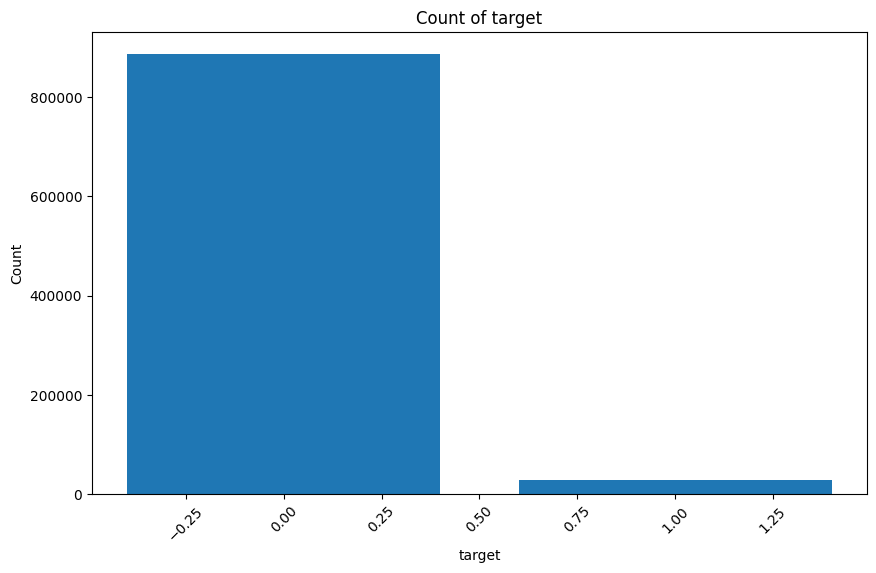

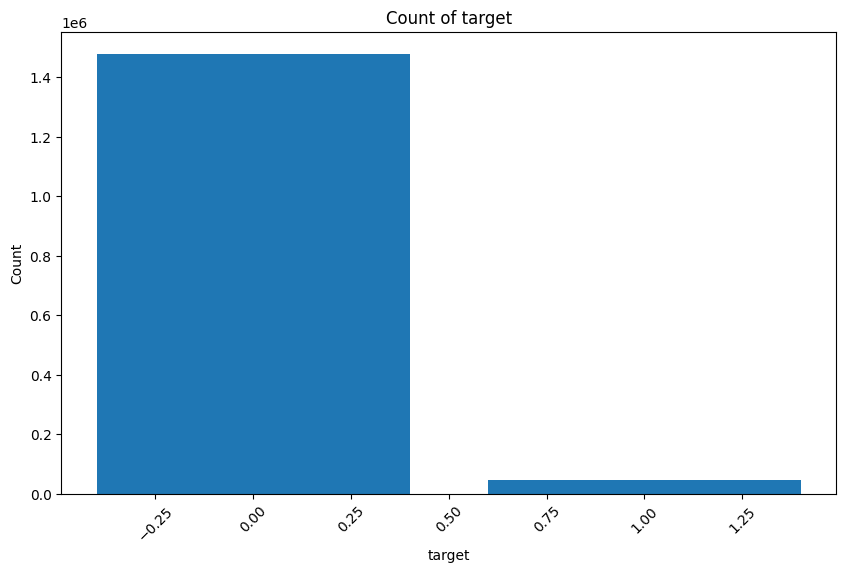

In [ ]:
import matplotlib.pyplot as plt

data_train_total = data_pd


def plot_count(data, columns):
    for col in columns:
        value_counts = data[col].value_counts()
        plt.figure(figsize=(10, 6))
        plt.bar(value_counts.index, value_counts.values)
        plt.title(f'Count of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

plot_count(base_train, ['target'])
plot_count(data_train_total, ['target'])


In [ ]:
print(len(data_train_total.columns), data_train_total.columns)
print(len(base_train.columns), base_train.columns)

58 Index(['case_id', 'date_decision', 'MONTH', 'WEEK_NUM', 'target',
       'amtinstpaidbefduel24m_4187115A', 'annuity_780A',
       'annuitynextmonth_57A', 'avginstallast24m_3658937A',
       'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A',
       'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A',
       'currdebtcredtyperange_828A', 'disbursedcredamount_1113A',
       'downpmt_116A', 'inittransactionamount_650A',
       'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M',
       'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A',
       'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M',
       'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A',
       'lastrejectreason_759M', 'lastrejectreasonclient_4145040M',
       'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A',
       'maxdebt4_972A', 'maxinstallast24m_3658928A',
       'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A',
       'maxpmt

In [ ]:
print(f"Train: {X_train.shape}")
print(f"Valid: {X_valid.shape}")
print(f"Test: {X_test.shape}")

Train: (915995, 48)
Valid: (305332, 48)
Test: (305332, 48)


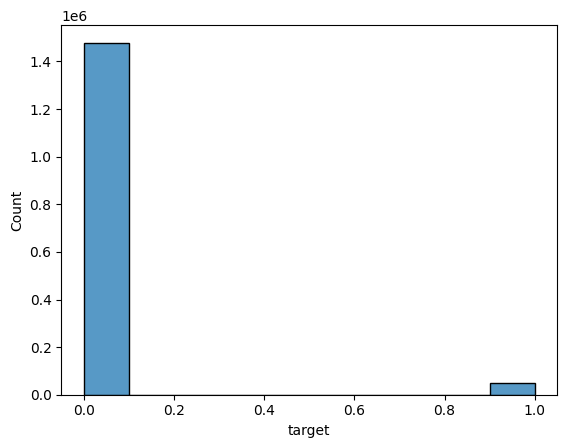

In [ ]:
# prompt: use histograms to visualize distribution of the target variable

sns.histplot(data=data_pd, x="target", bins=10)
plt.show()


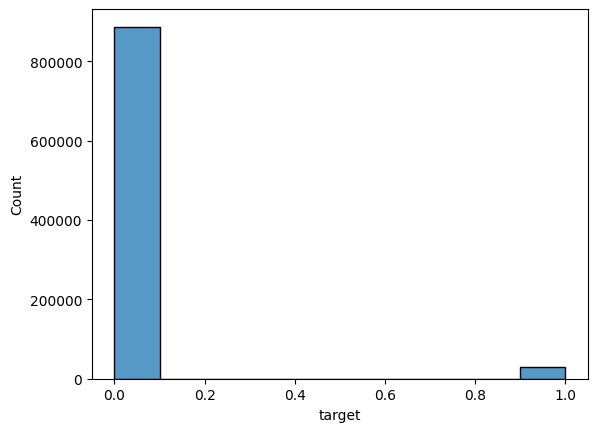

In [ ]:
sns.histplot(data=base_train, x="target", bins=10)
plt.show()

X_train shape: (915995, 48)
y_train shape: (915995,)


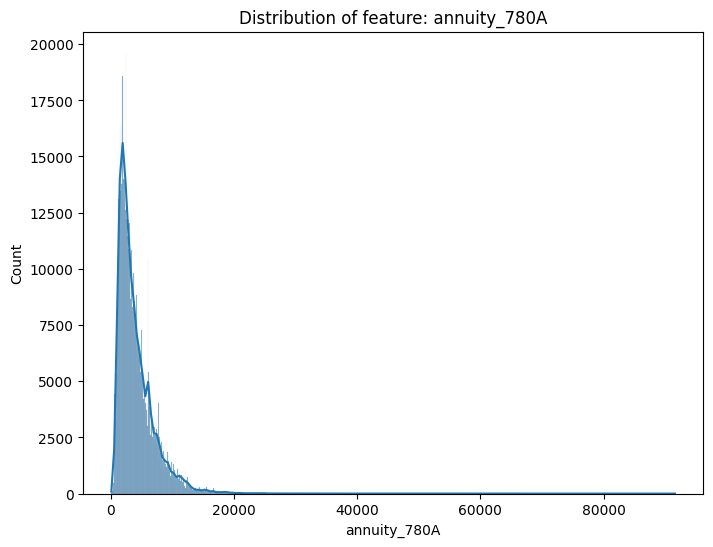

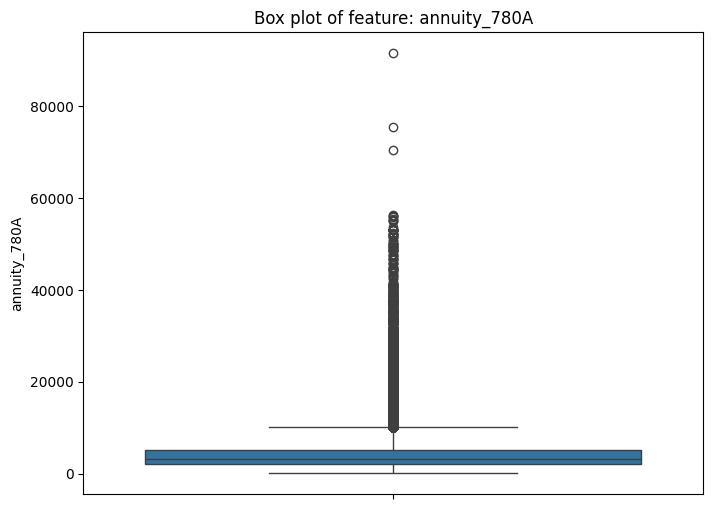

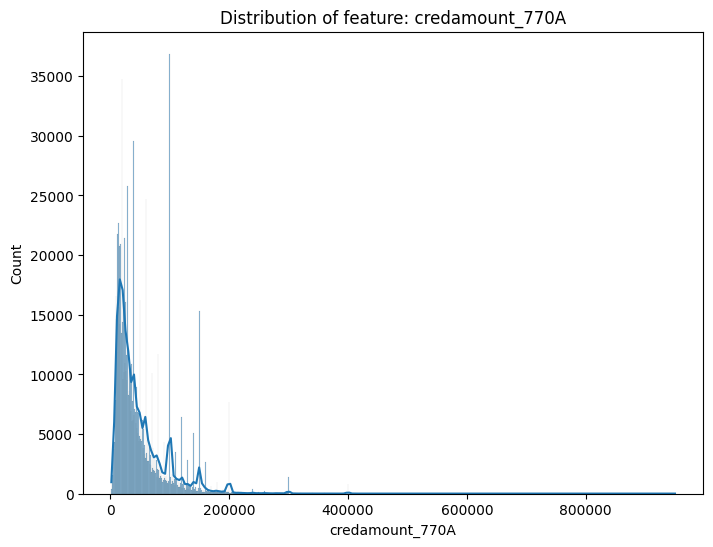

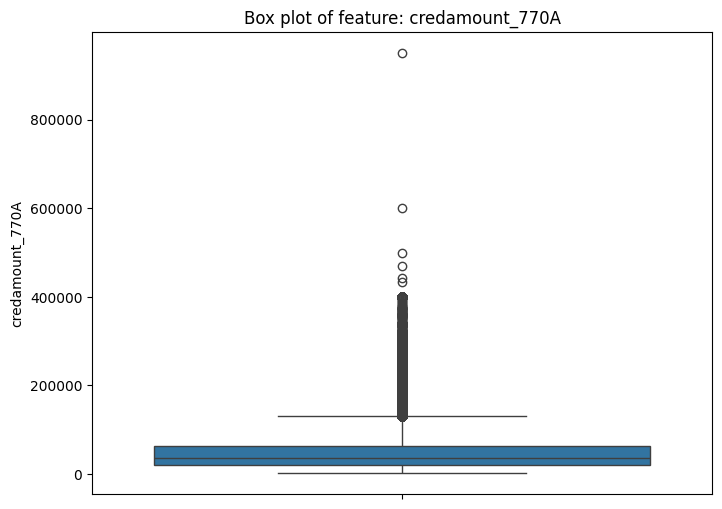

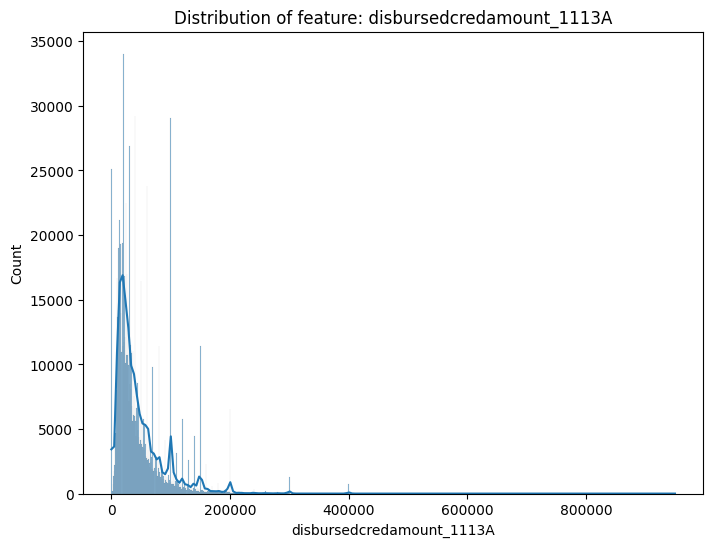

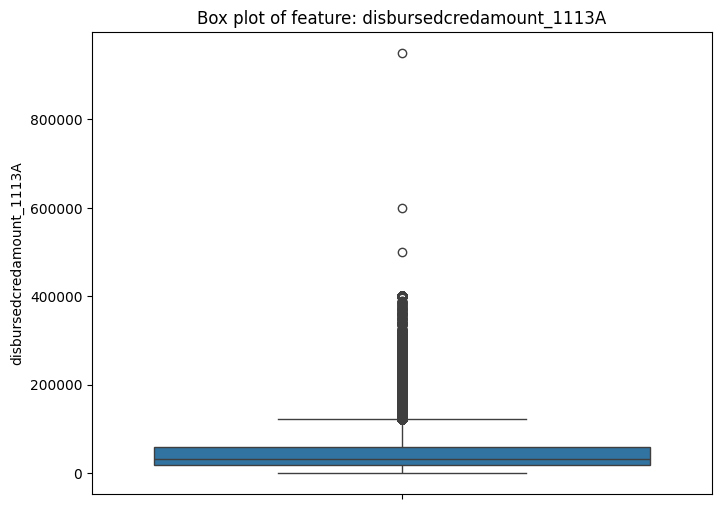

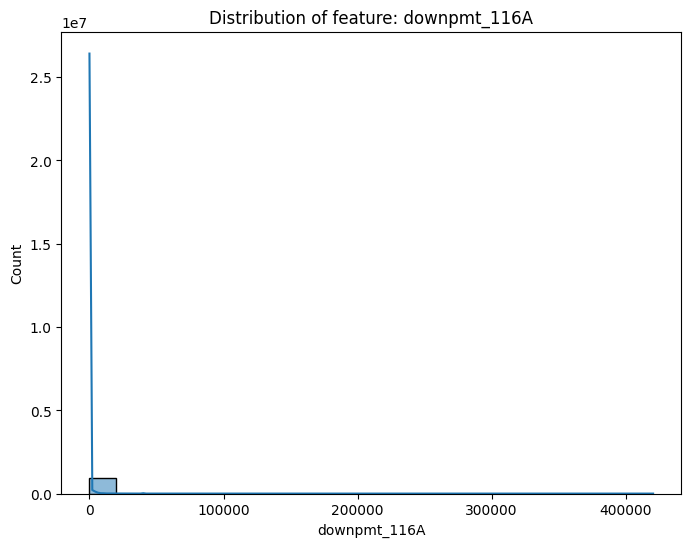

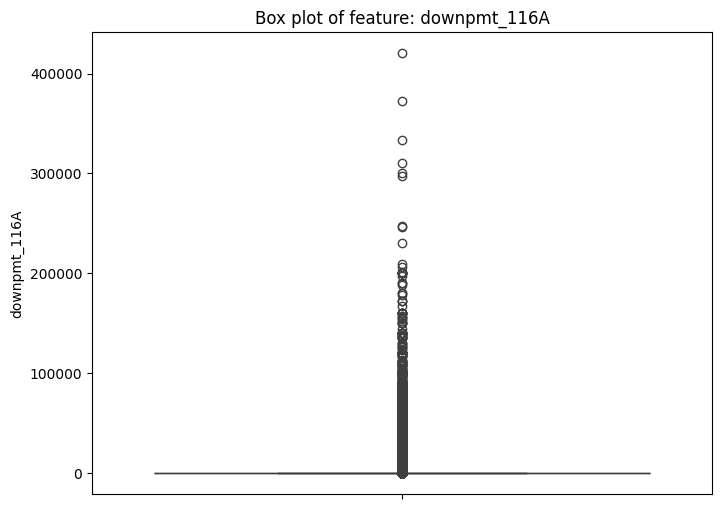

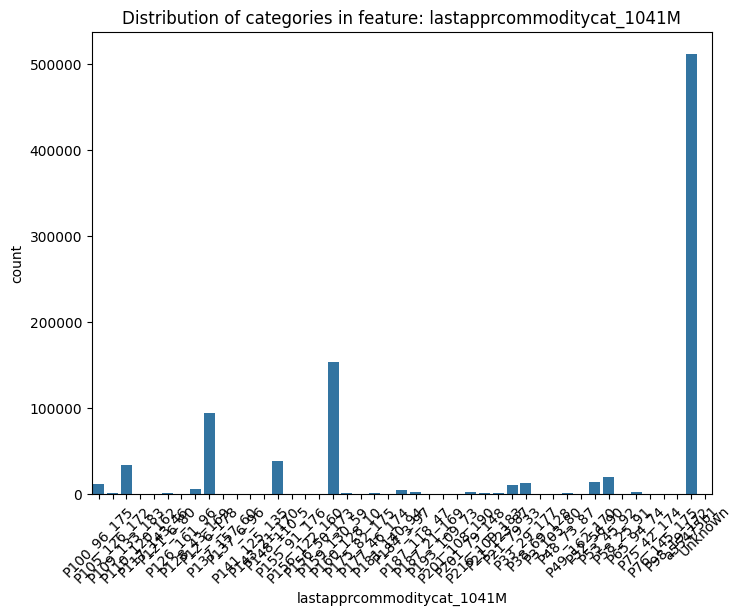

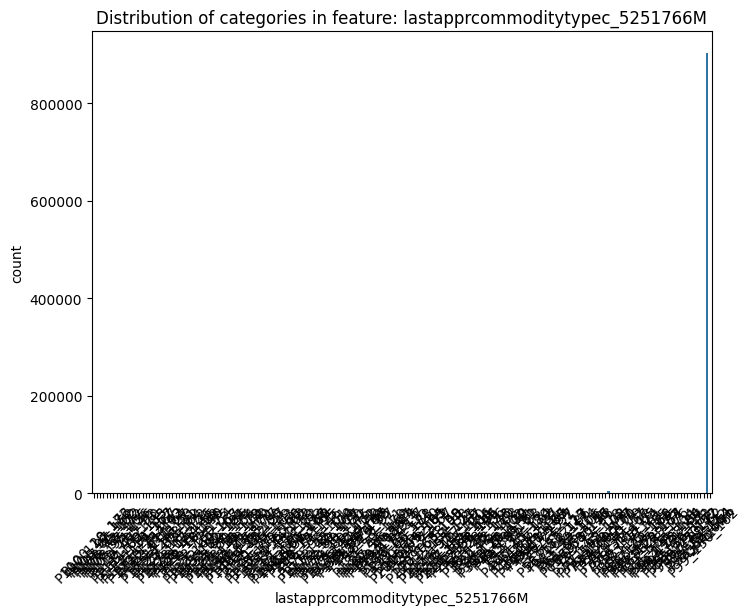

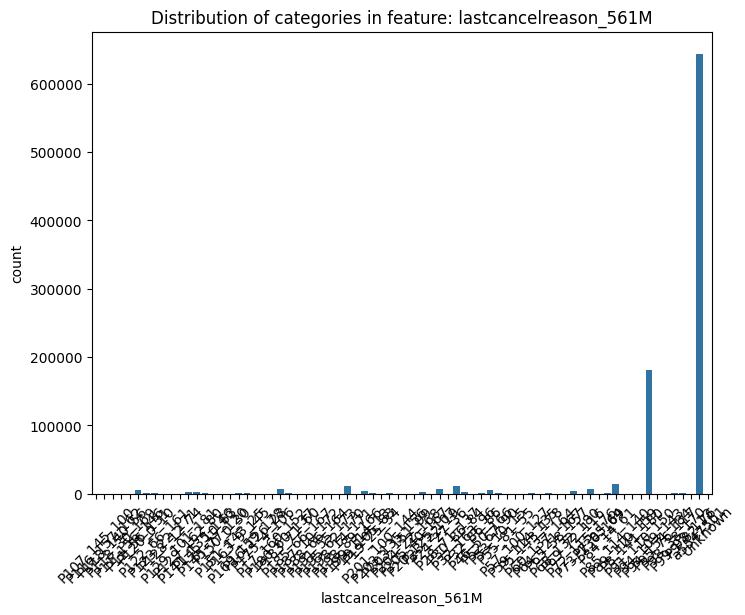

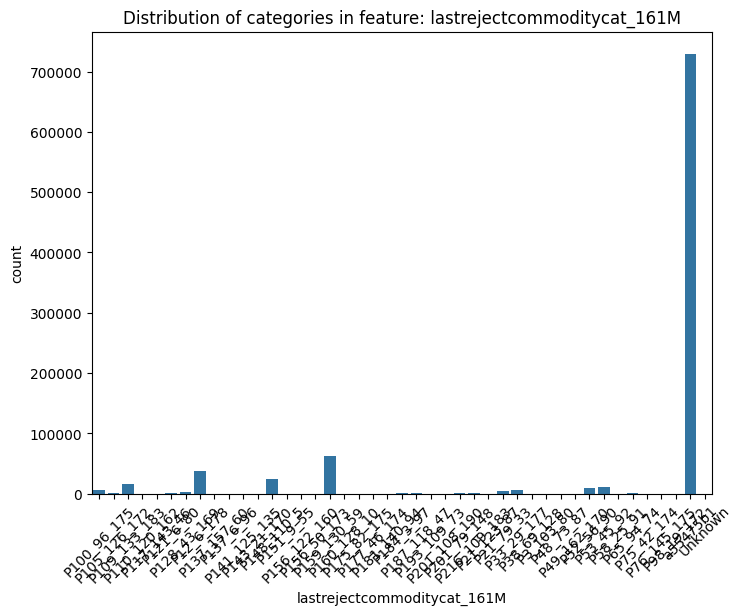

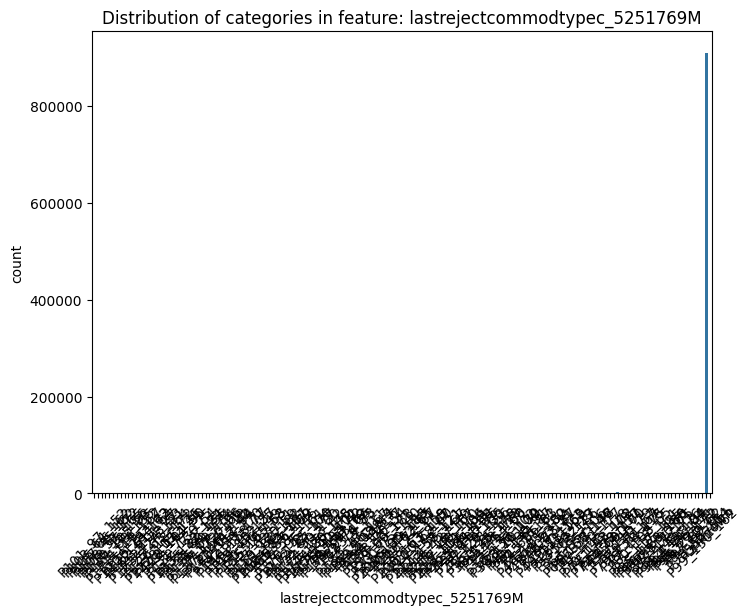

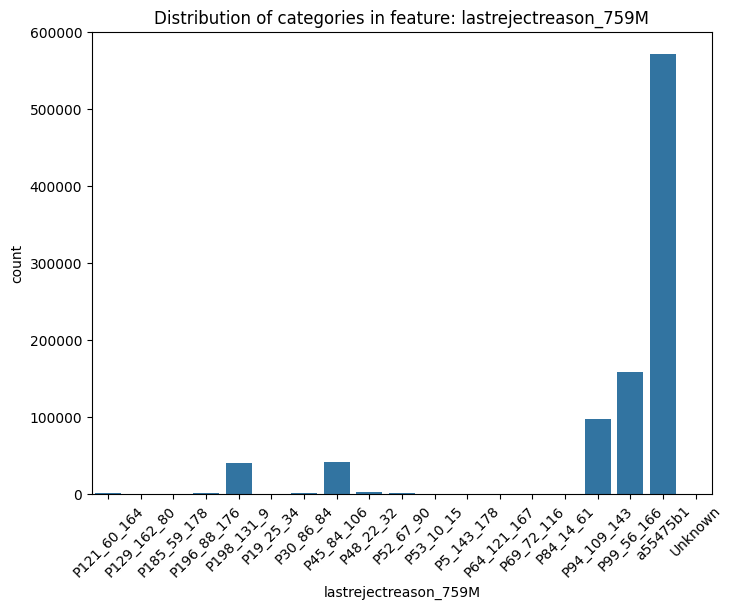

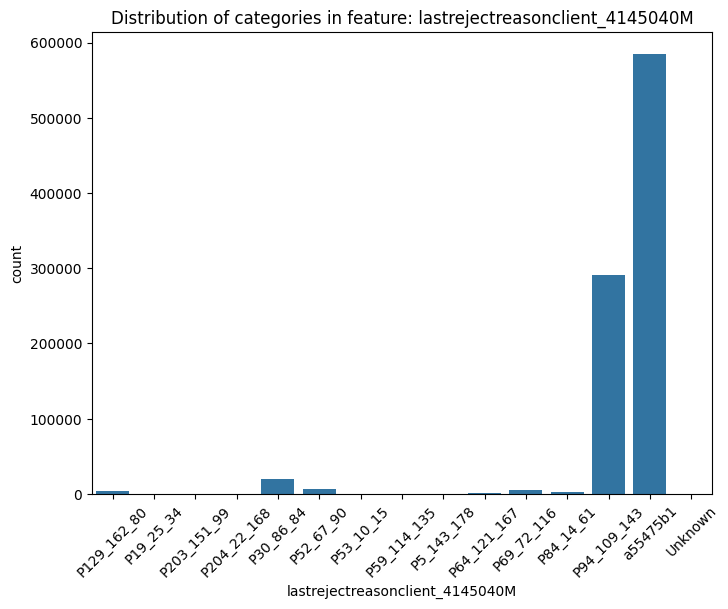

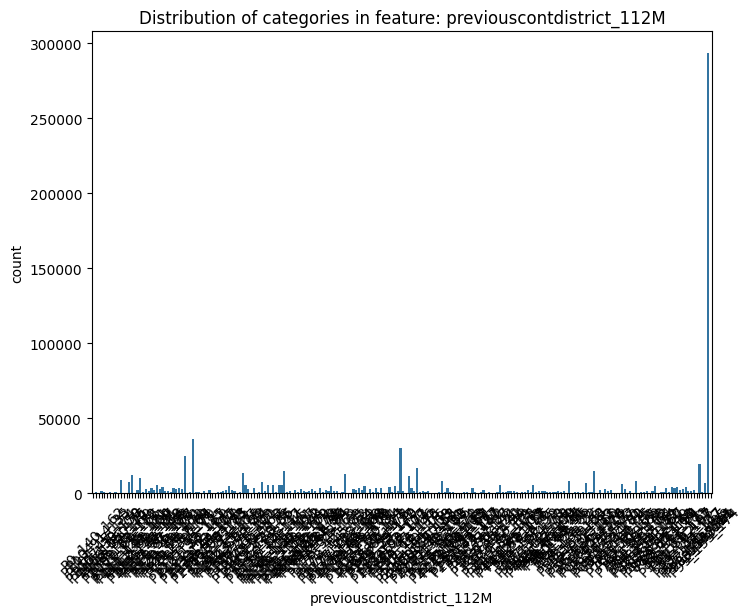

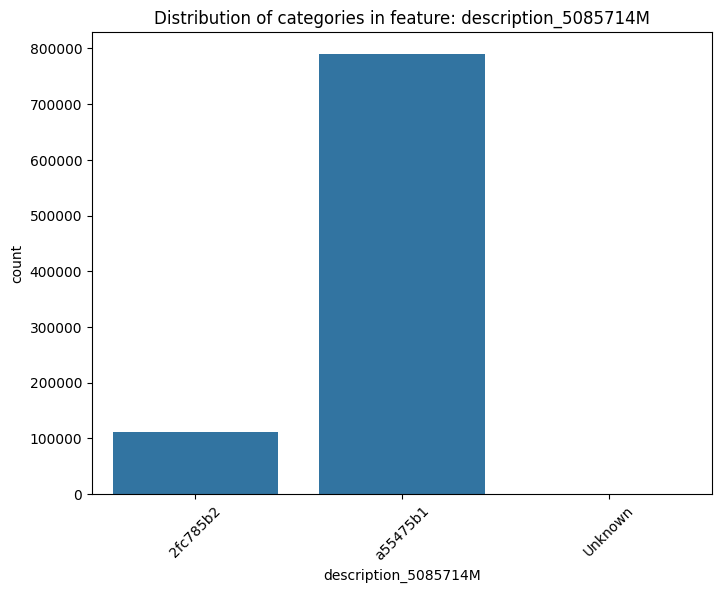

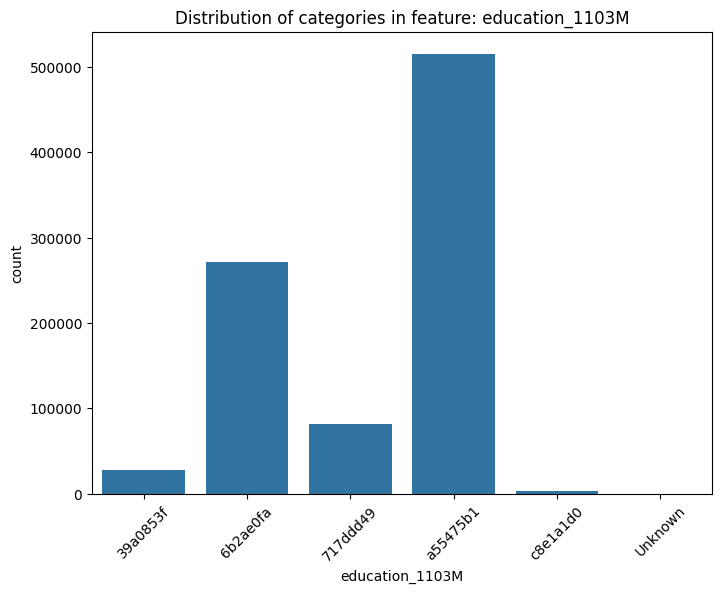

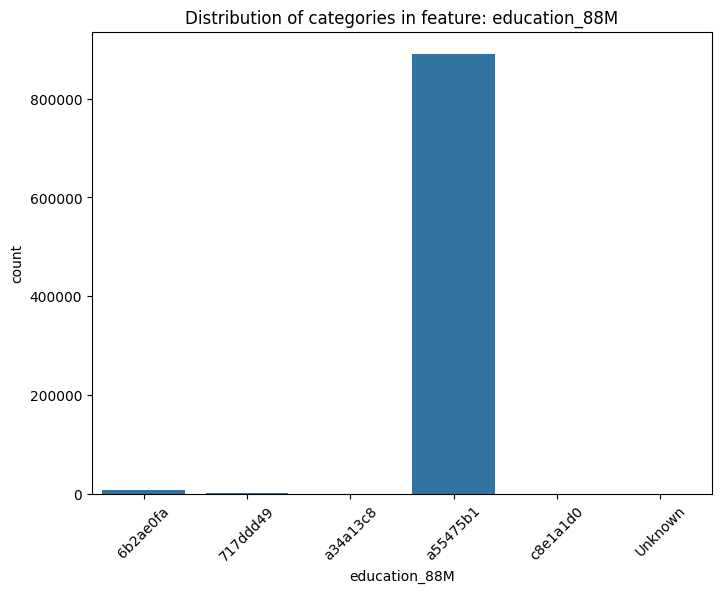

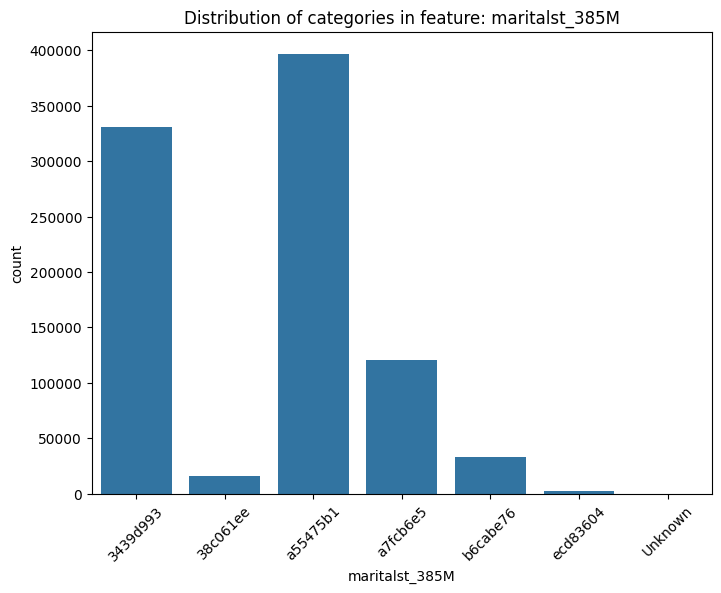

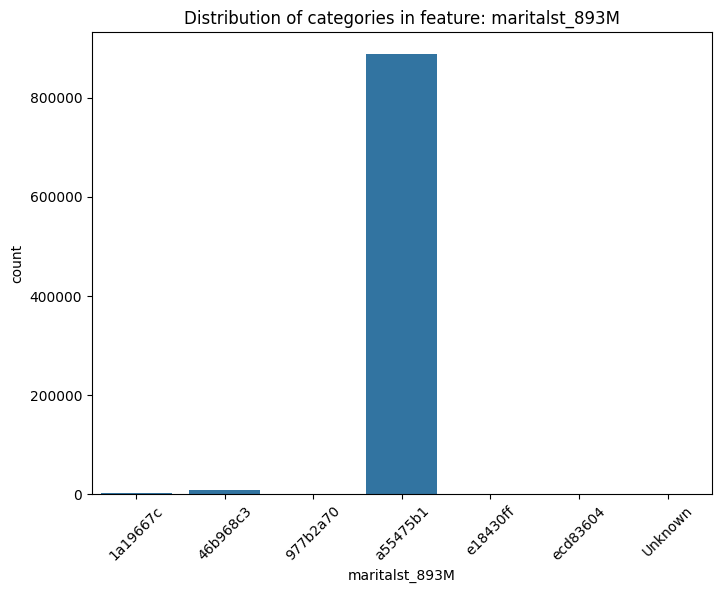

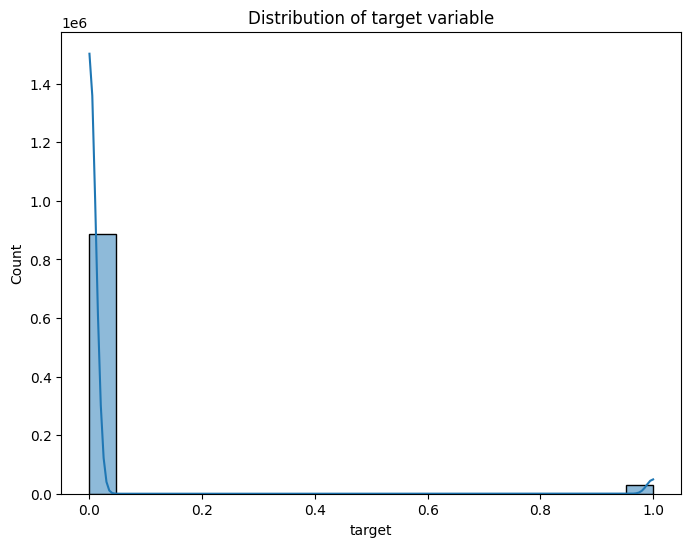

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Inspect shapes of X_train and y_train
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Numerical feature visualizations (adapt based on features)
for col in X_train.select_dtypes(include=['int64', 'float64']):
    # Check for missing values
    if X_train[col].isna().any():
        print(f"Warning: Feature {col} has missing values. Consider imputation.")

        continue

    # Histogram for distribution and outliers
    plt.figure(figsize=(8, 6))
    sns.histplot(data=X_train, x=col, kde=True)
    plt.title(f"Distribution of feature: {col}")
    plt.show()

    # Box plot for outliers
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=col, data=X_train)
    plt.title(f"Box plot of feature: {col}")
    plt.show()

# Categorical feature visualizations (adapt based on your features)
for col in X_train.select_dtypes(include=['category']):
    # Count or bar plot for category distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(x=col, data=X_train)
    plt.title(f"Distribution of categories in feature: {col}")
    plt.xticks(rotation=45)
    plt.show()

# Target variable visualization
plt.figure(figsize=(8, 6))
sns.histplot(data=y_train, kde=True)
plt.title("Distribution of target variable")
plt.show()

# Further considerations:
# - Investigate relationships between features using scatter matrices or pair plots.
# - Create feature importance plots if you have trained a model already.
# - Adjust plot configurations (e.g., colors, bin sizes) for better visualization.

X_train shape: (915995, 48)
y_train shape: (915995,)


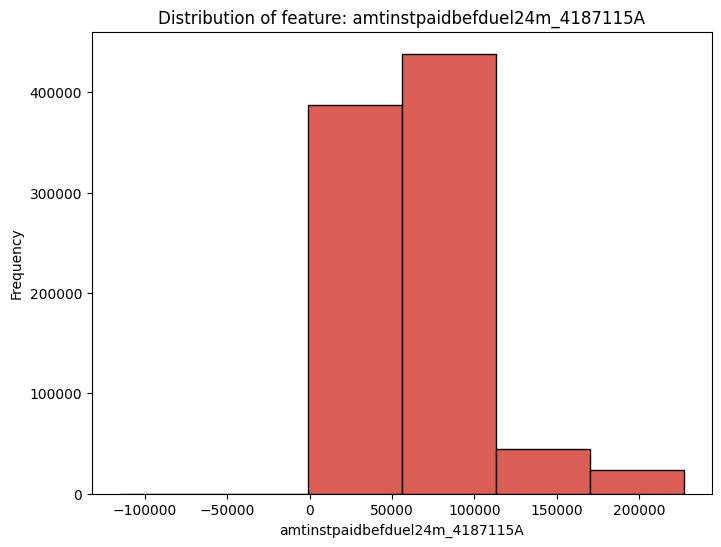

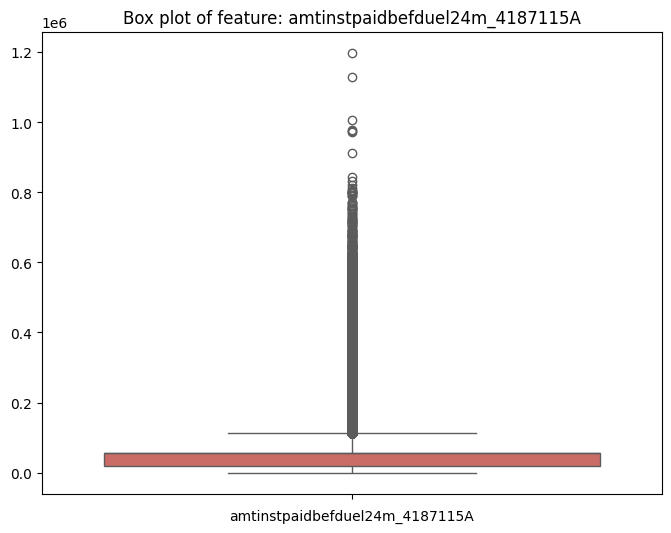

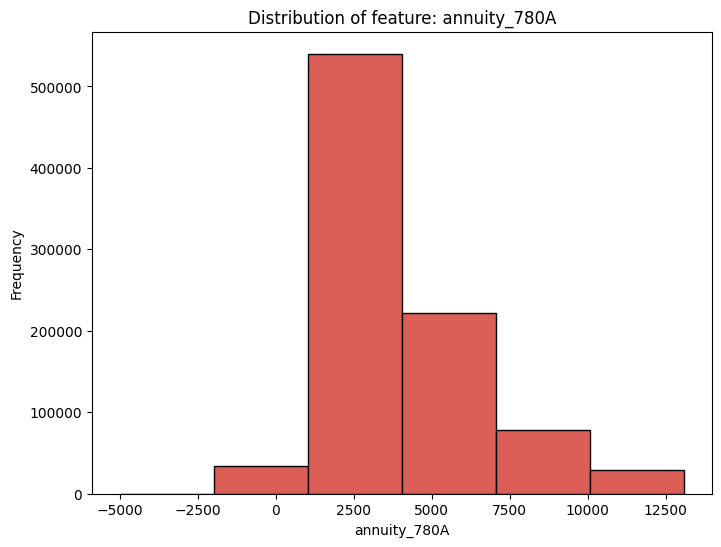

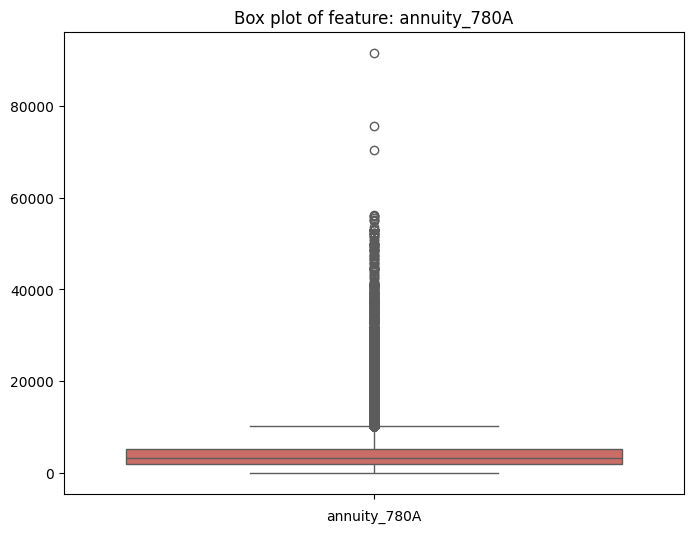

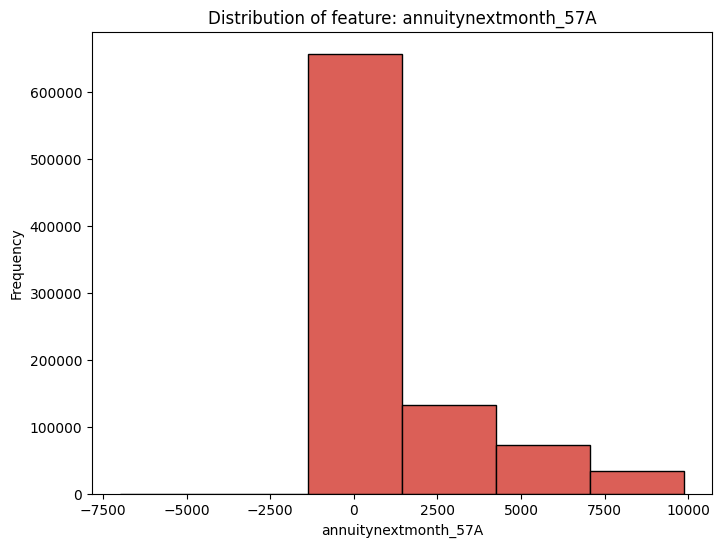

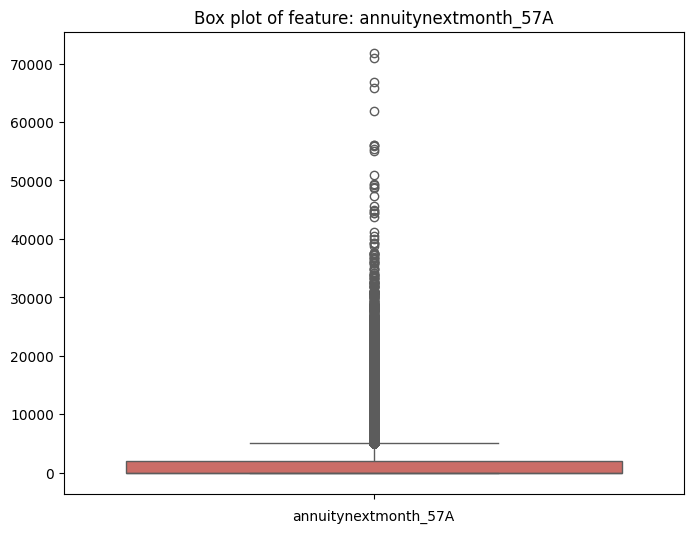

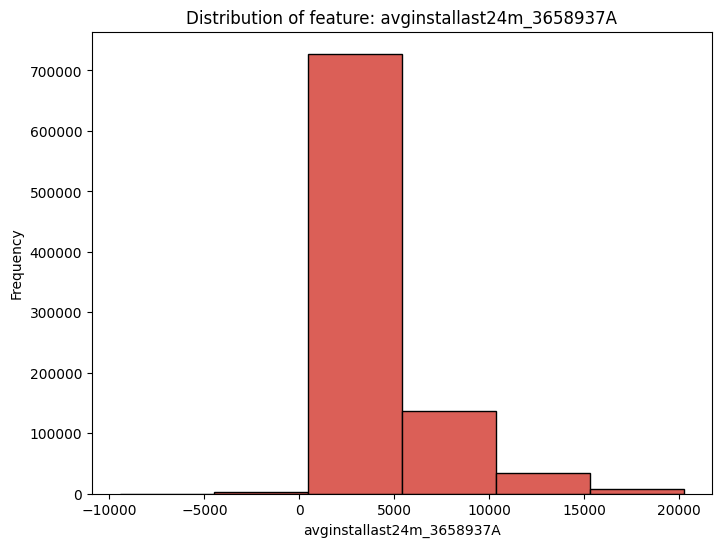

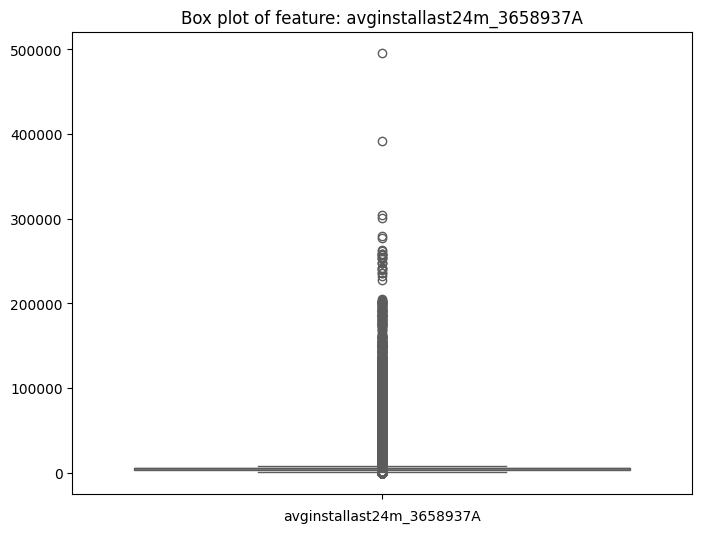

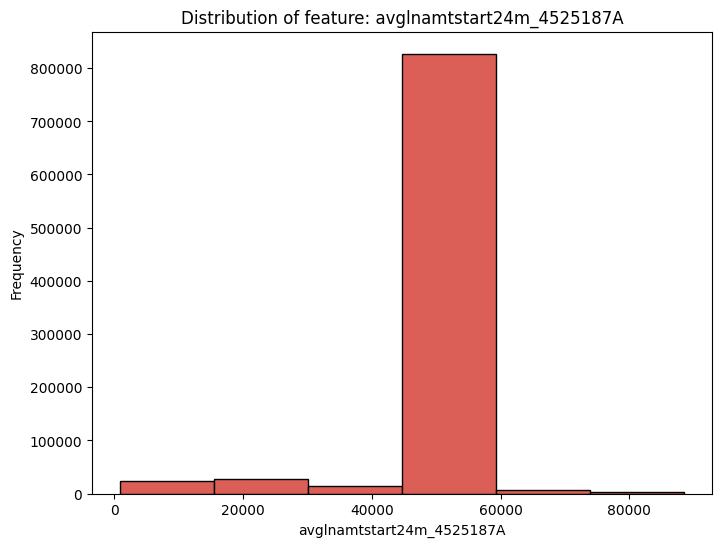

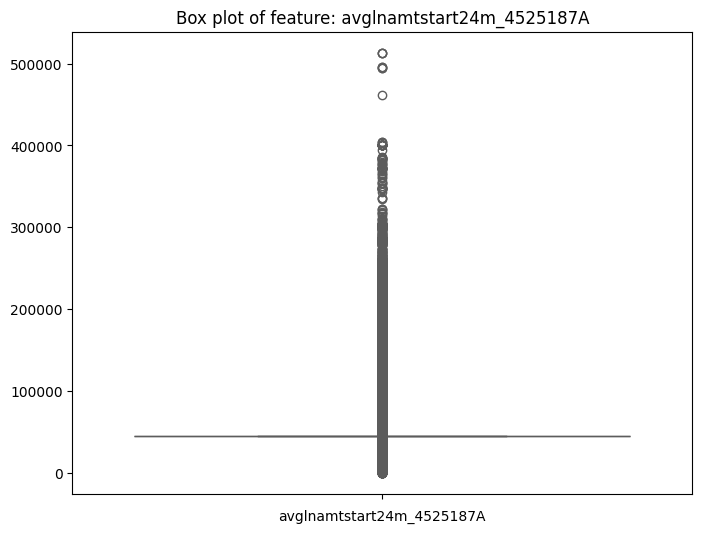

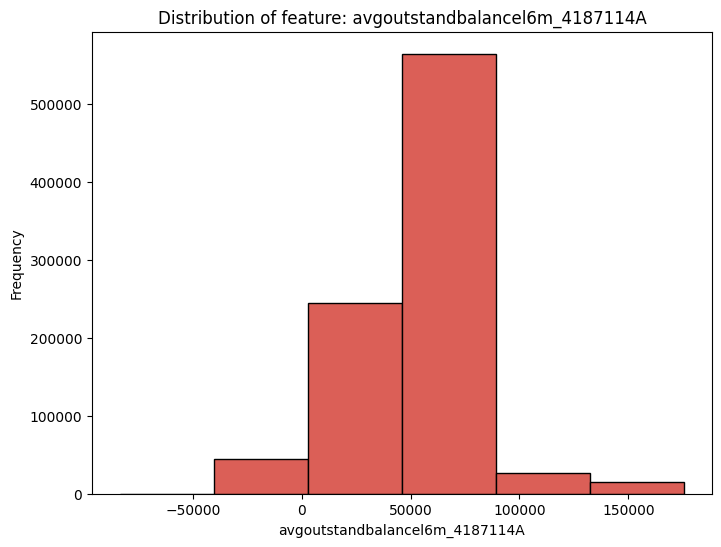

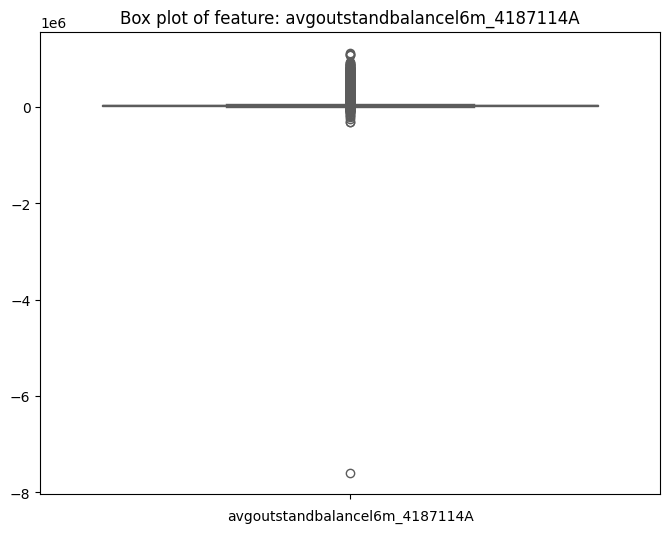

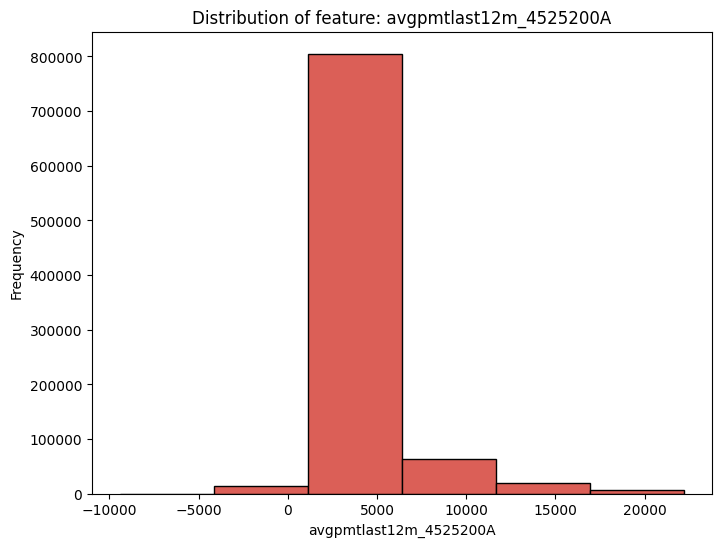

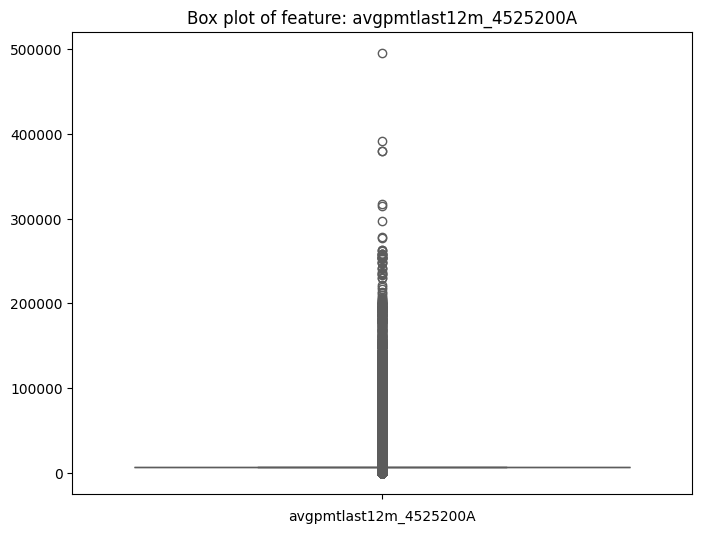

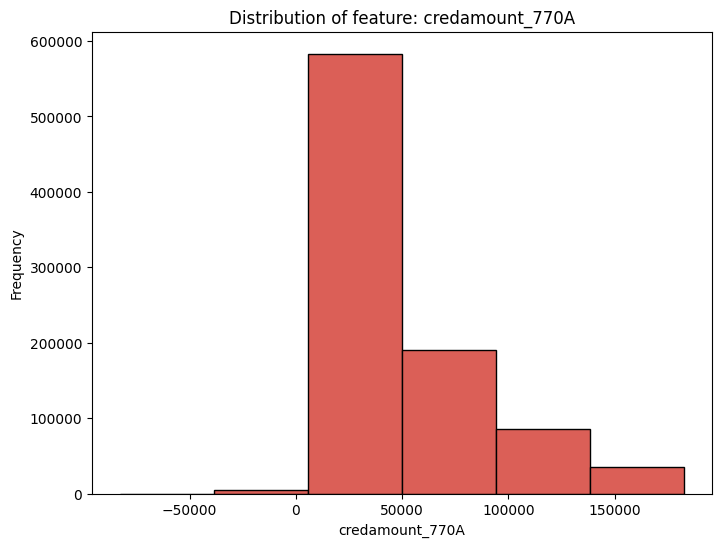

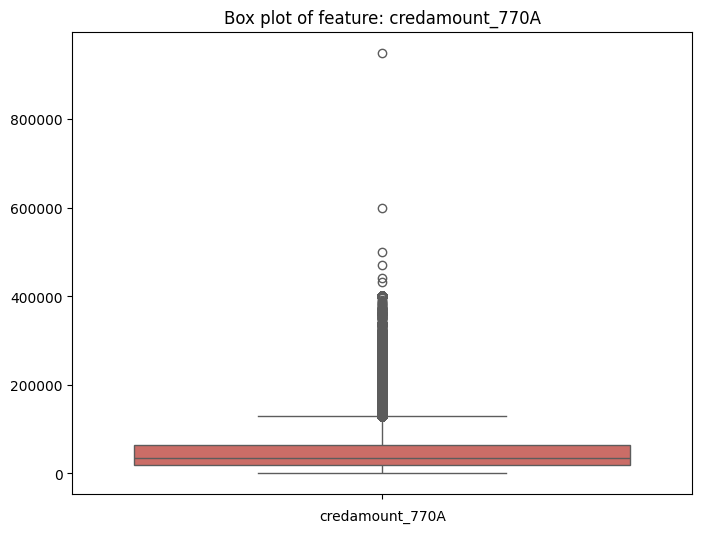

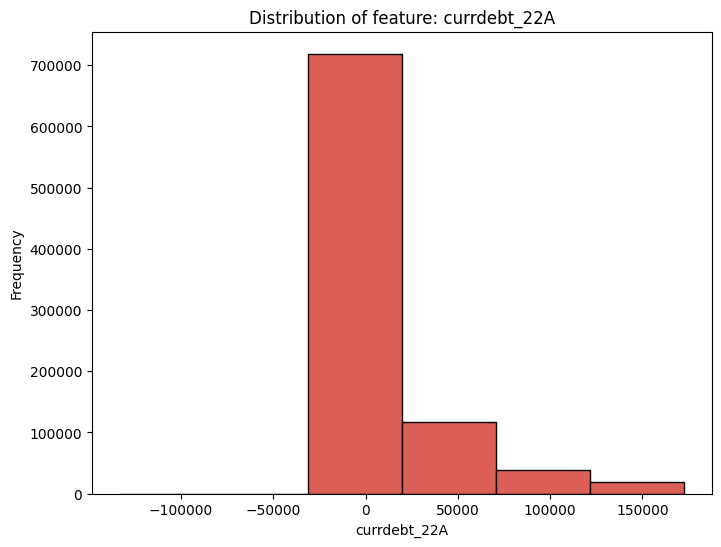

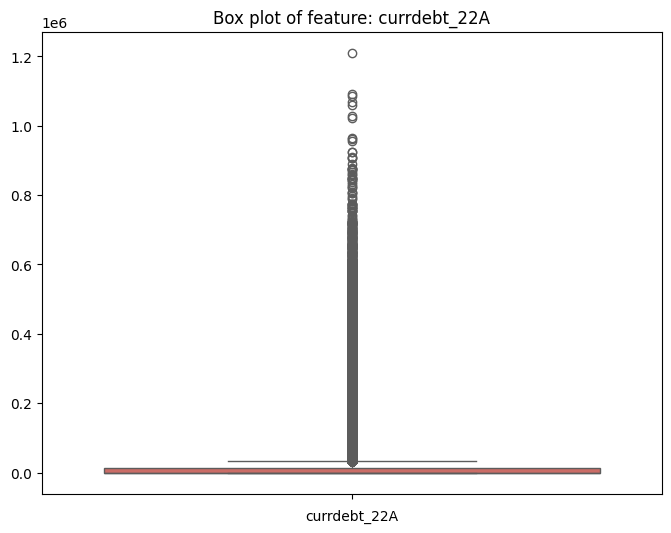

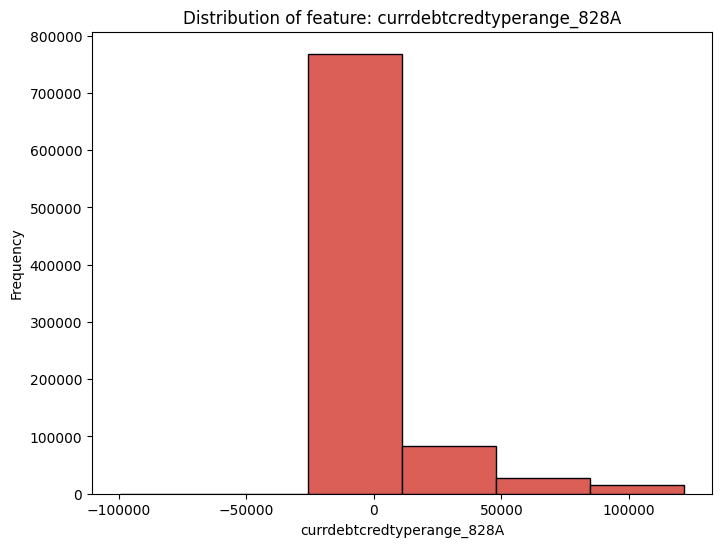

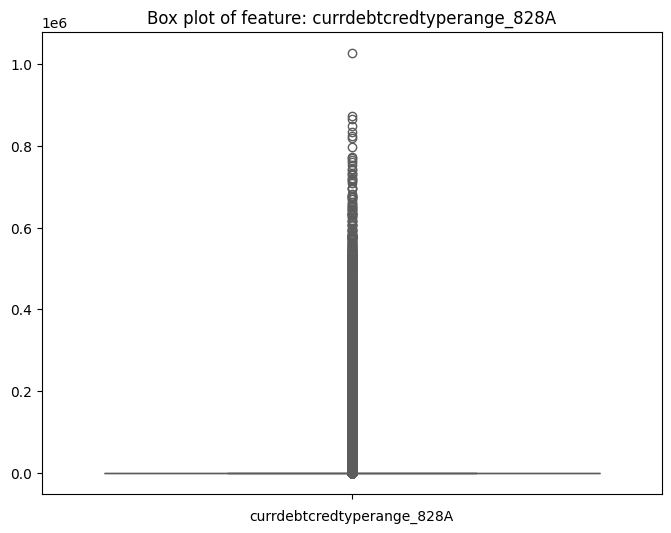

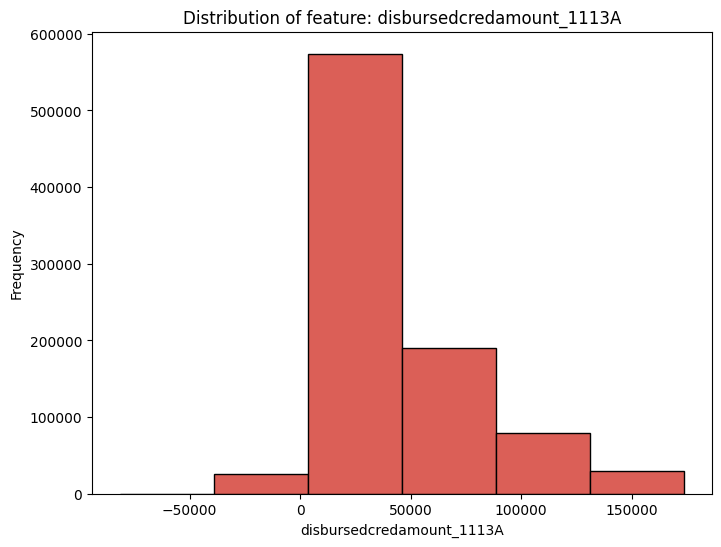

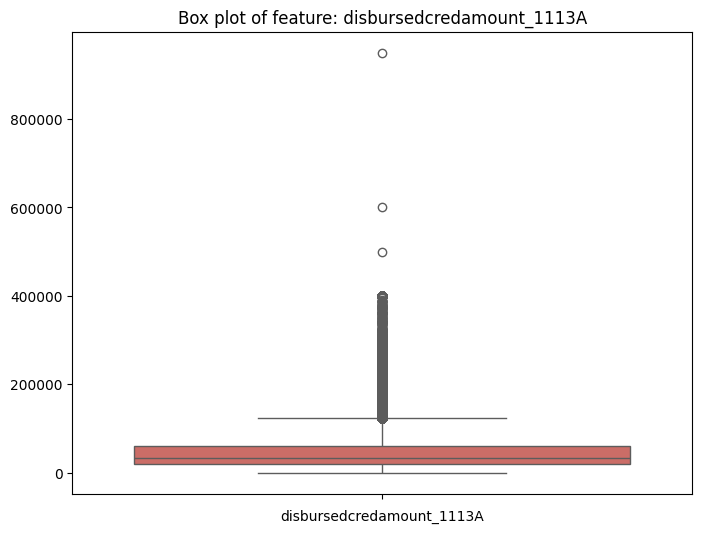

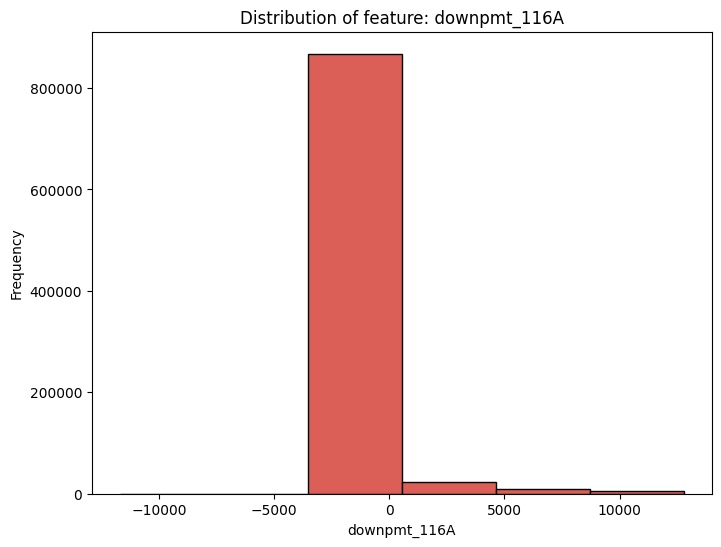

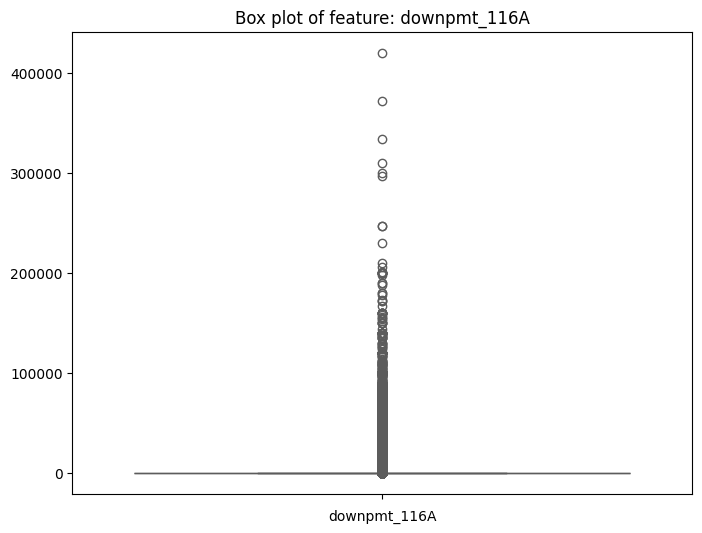

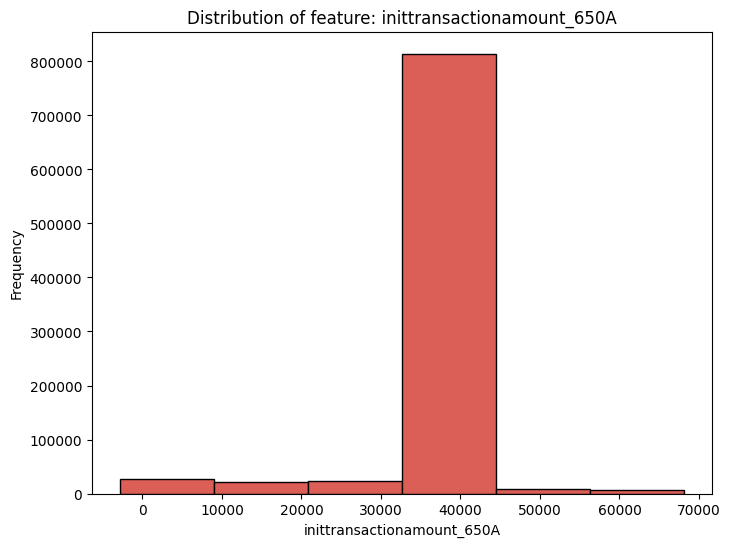

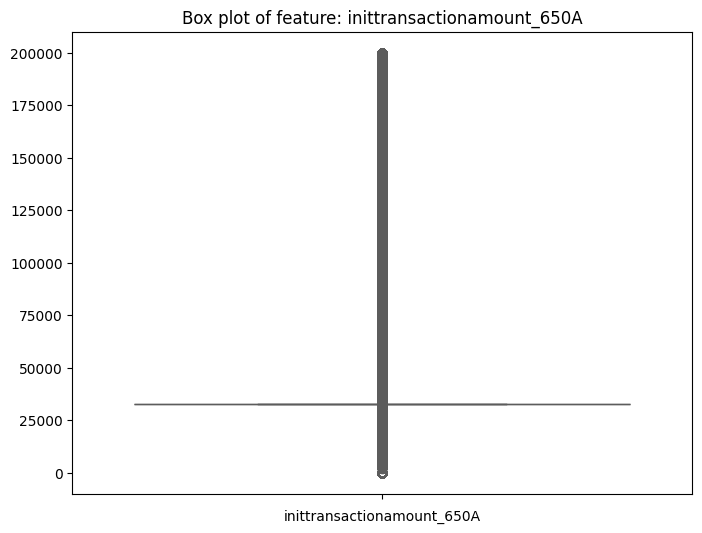

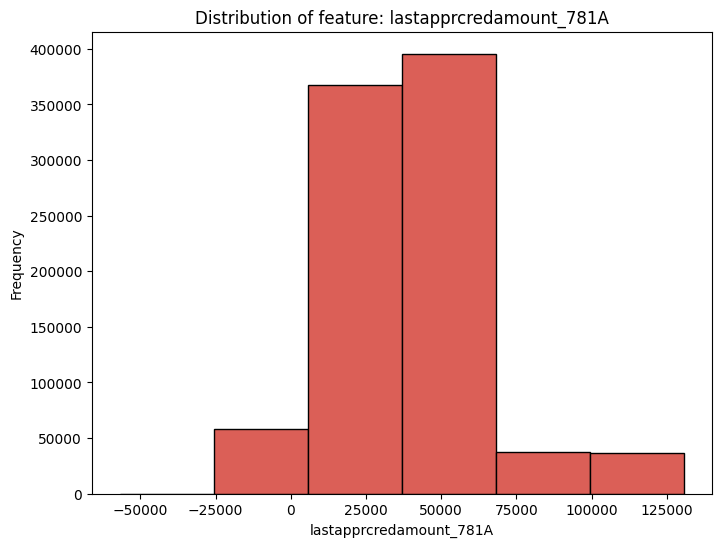

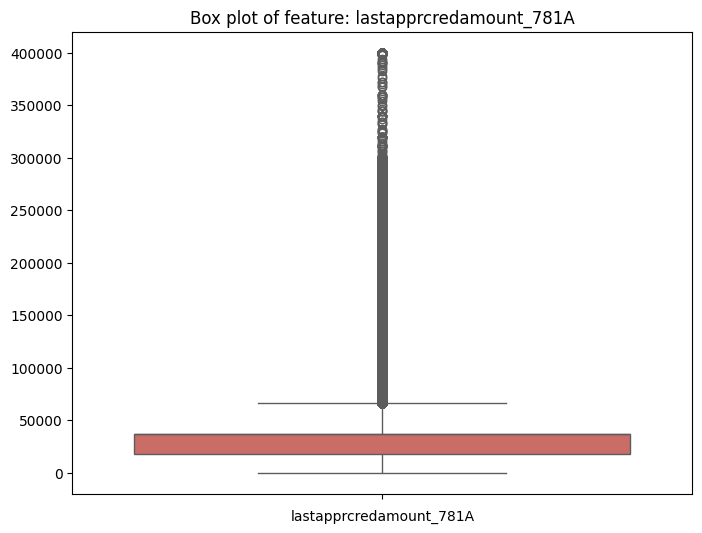

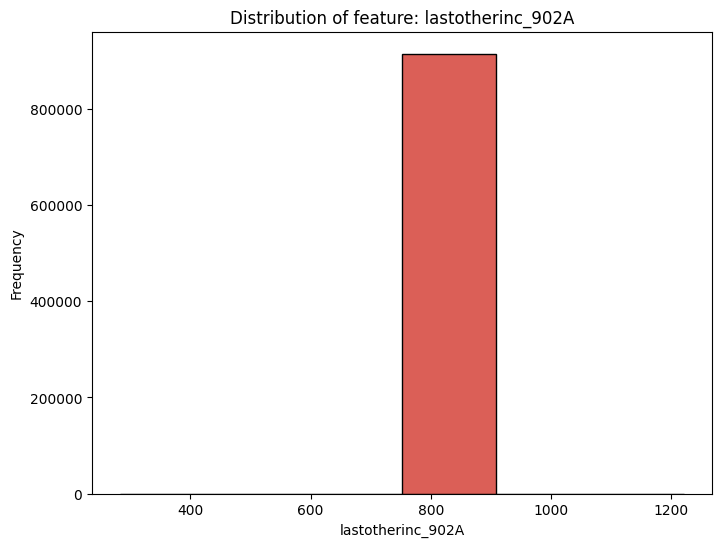

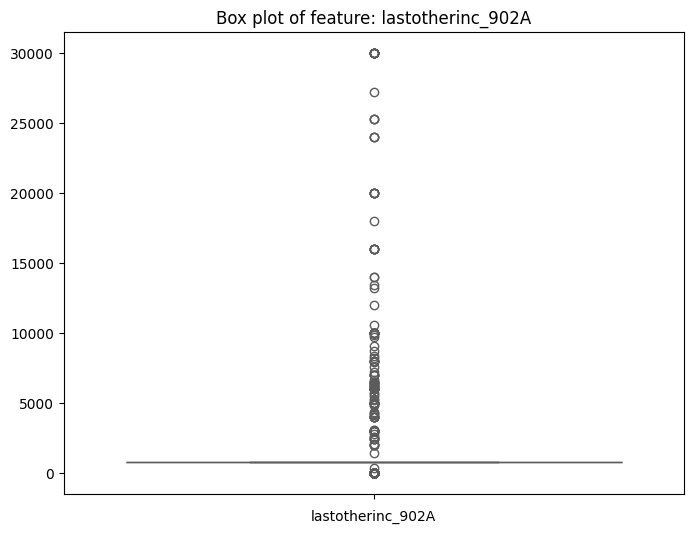

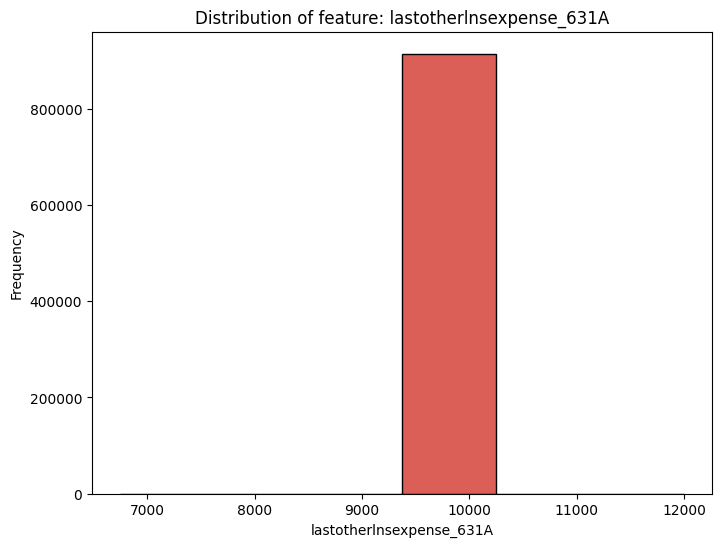

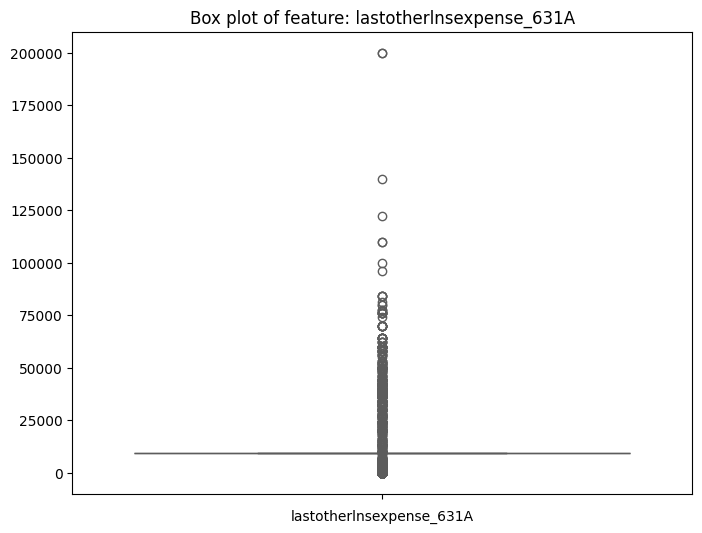

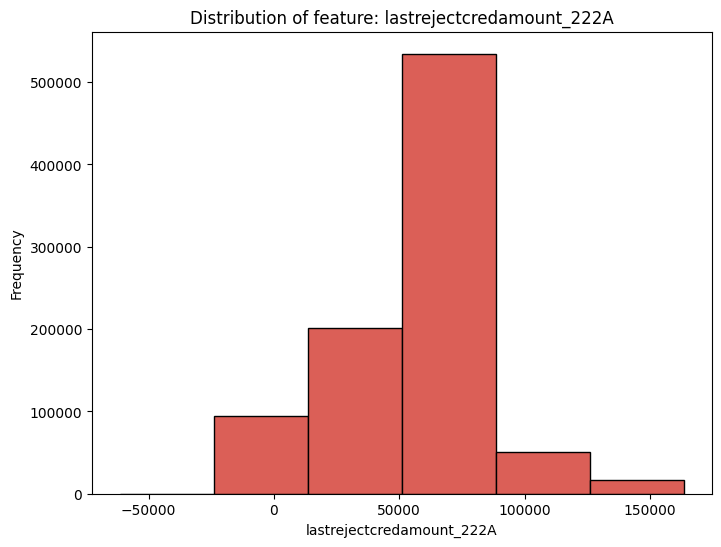

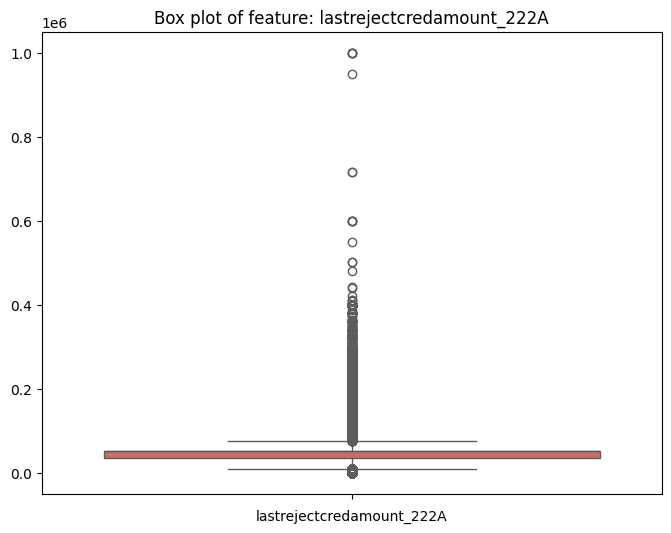

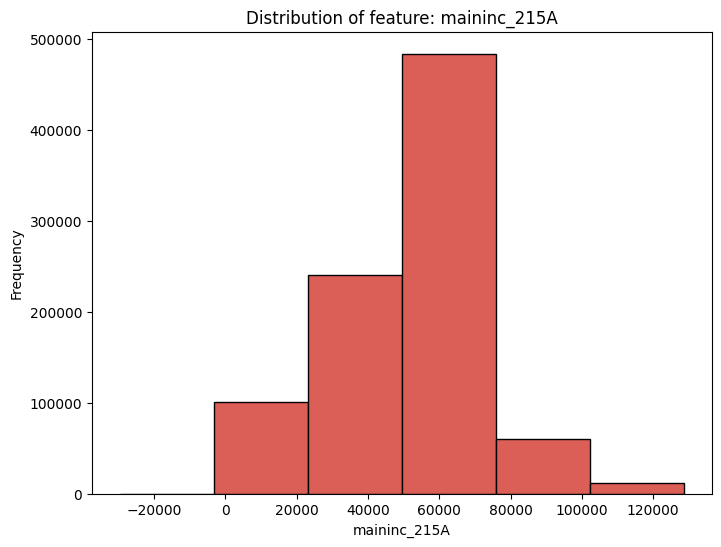

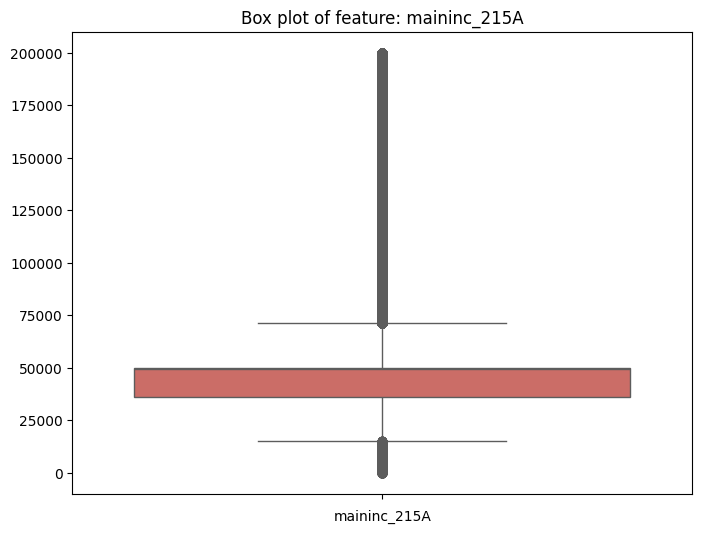

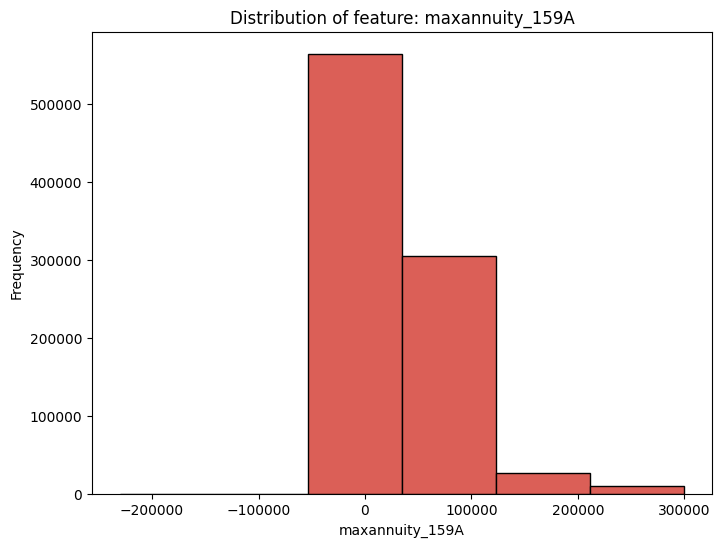

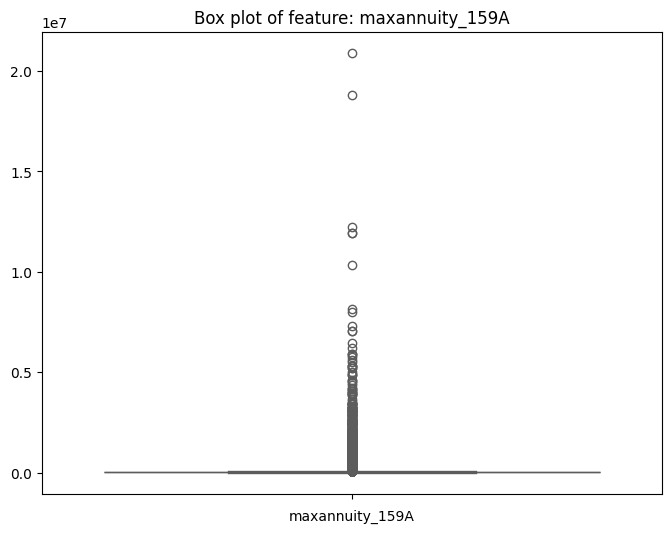

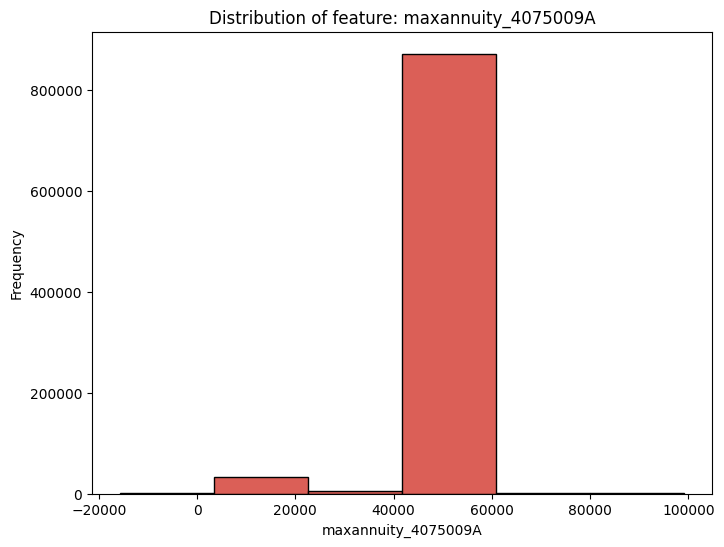

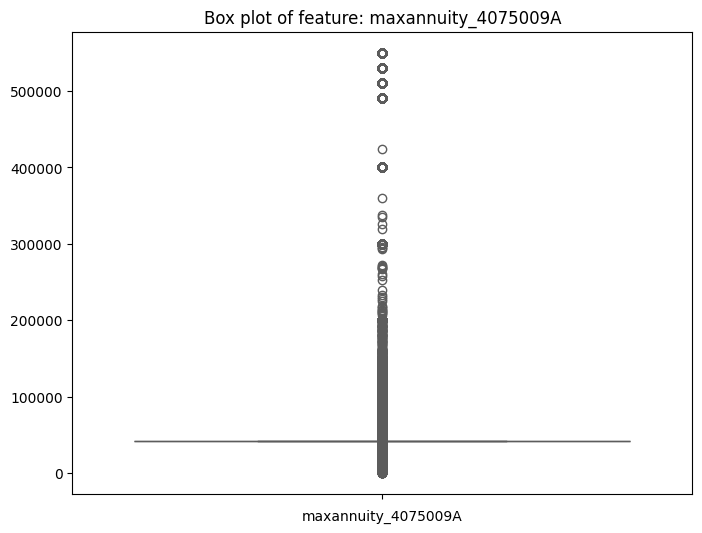

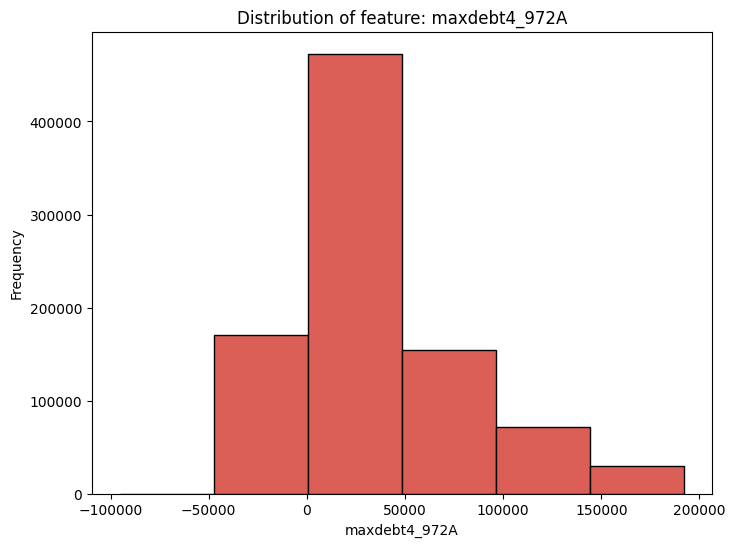

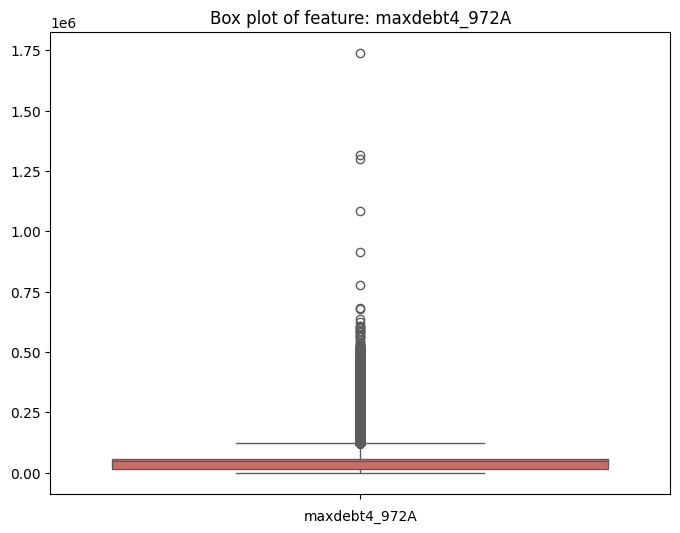

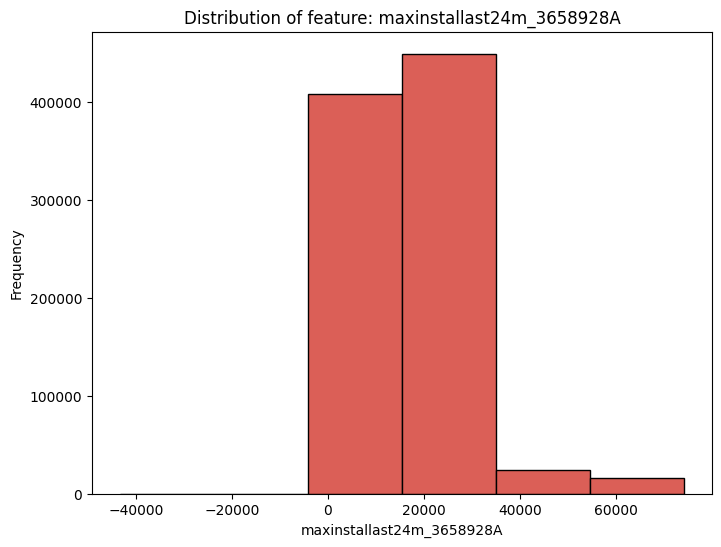

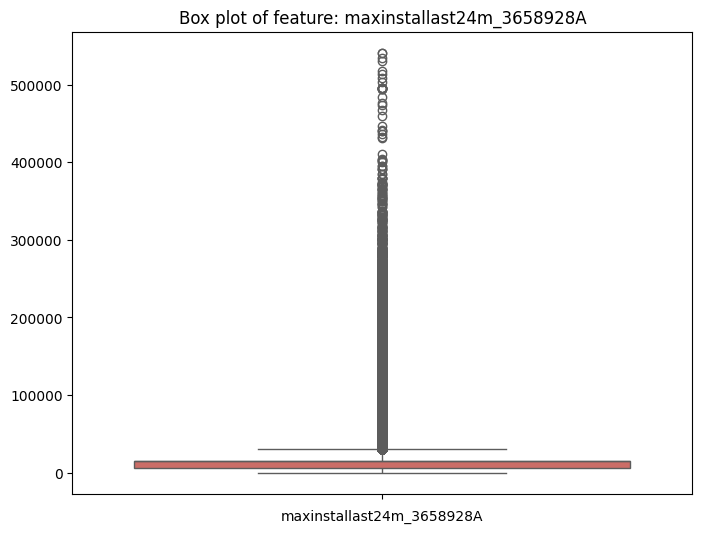

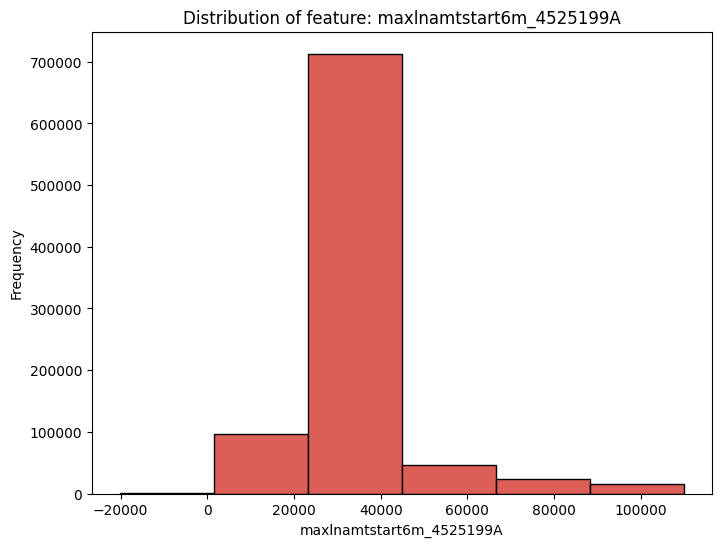

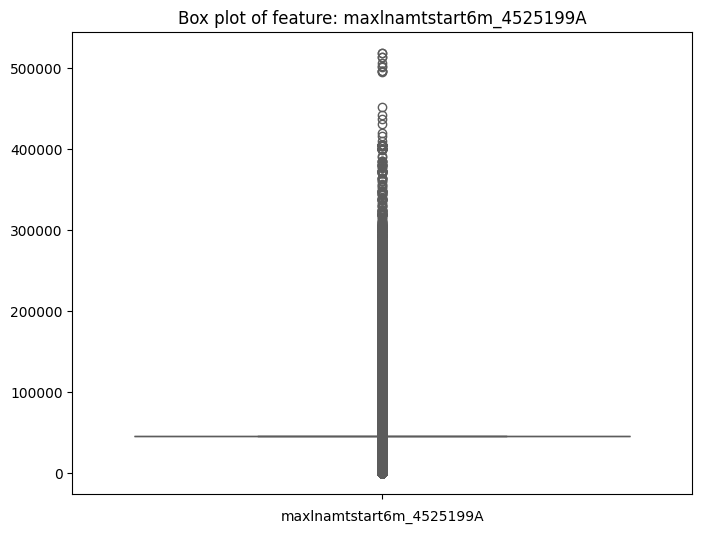

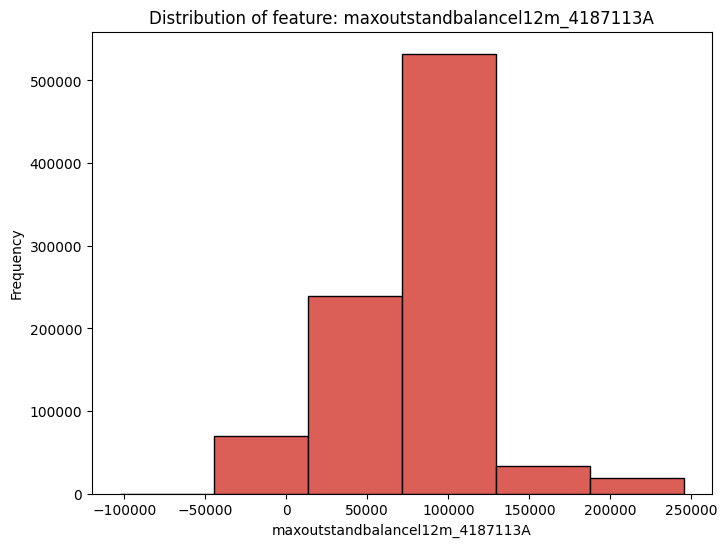

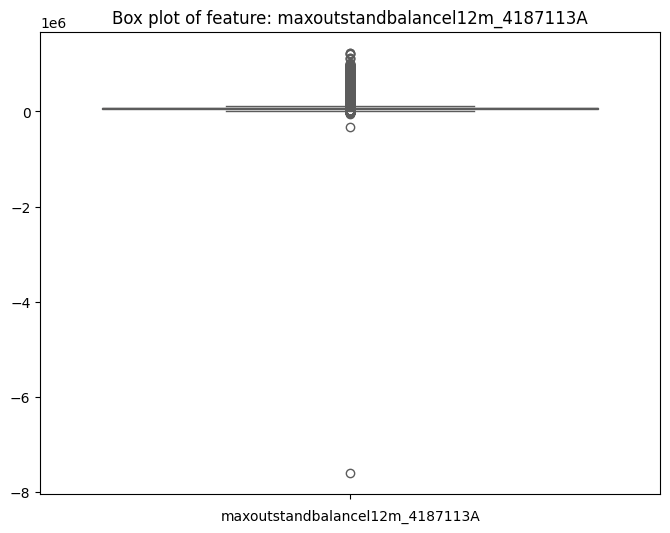

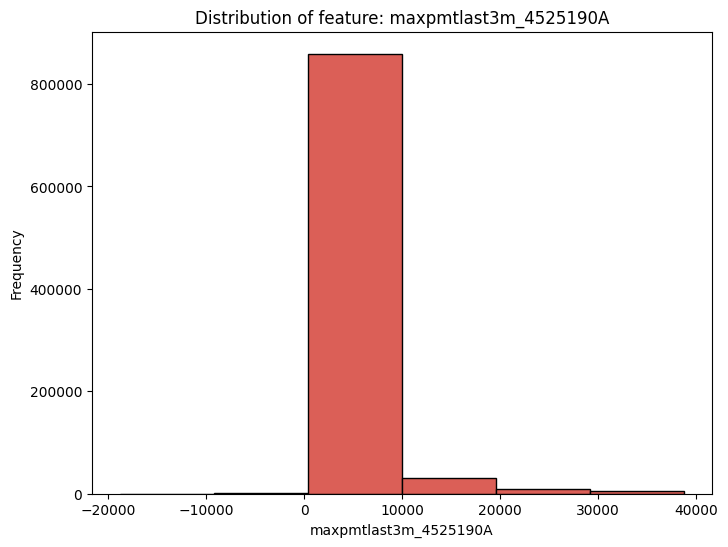

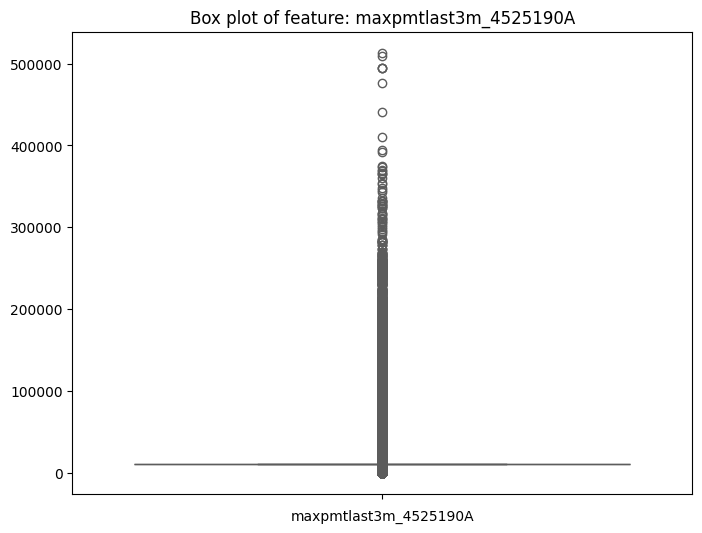

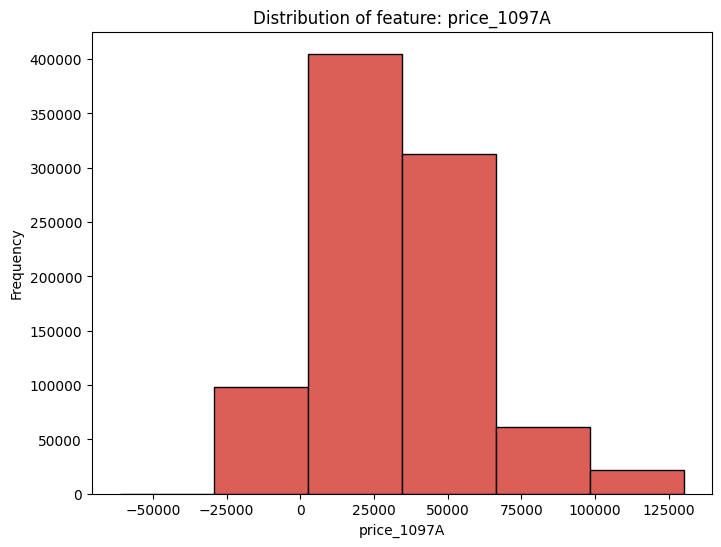

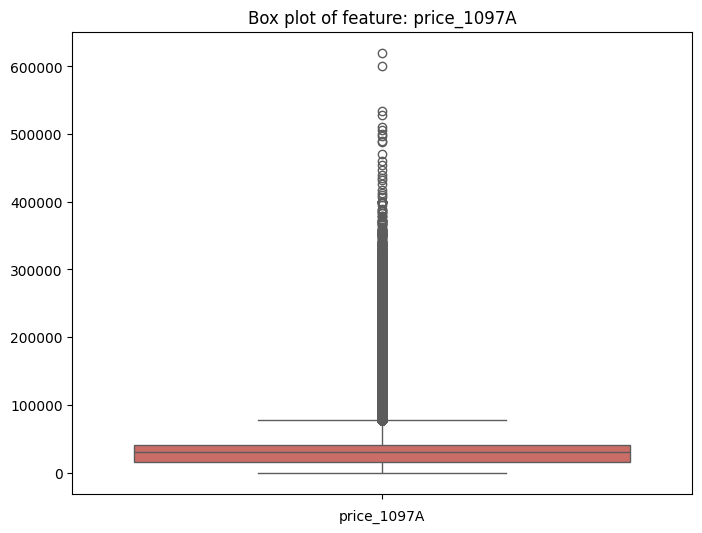

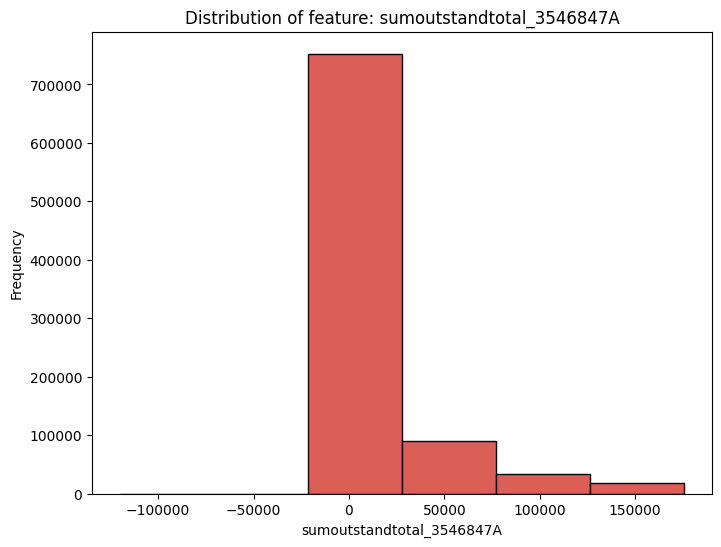

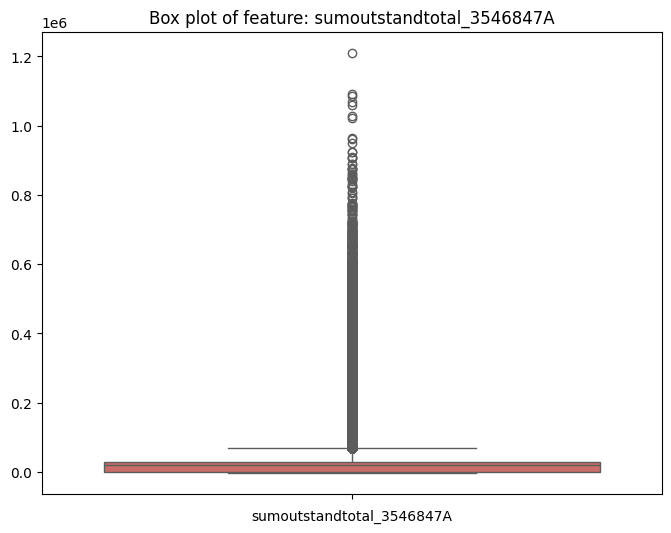

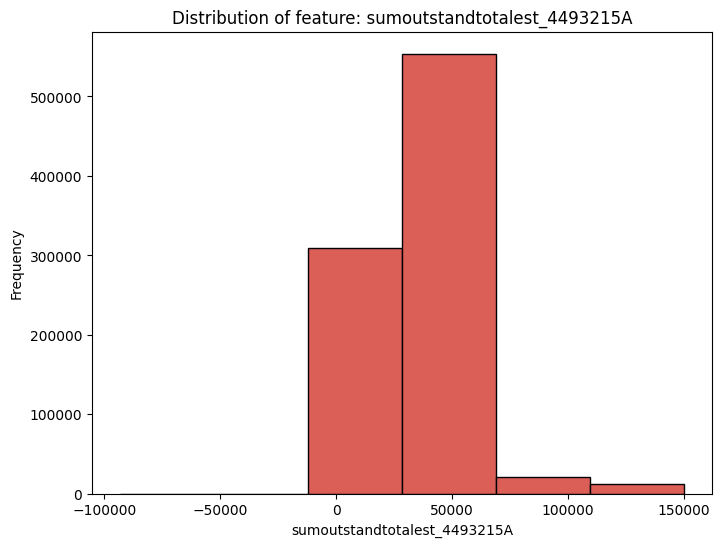

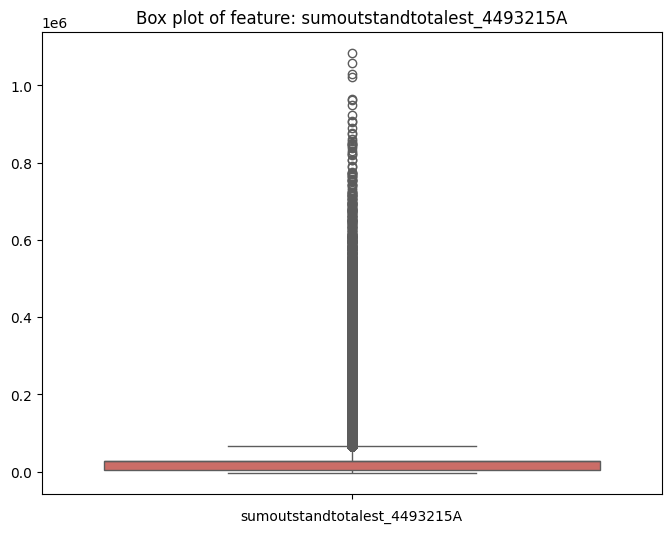

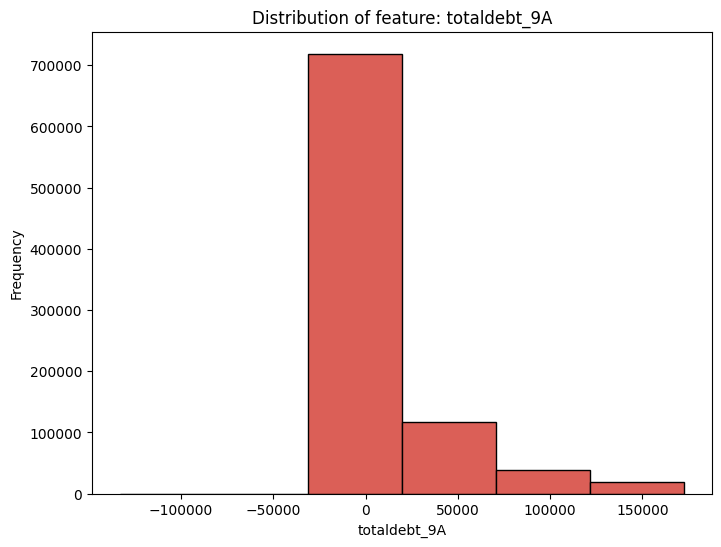

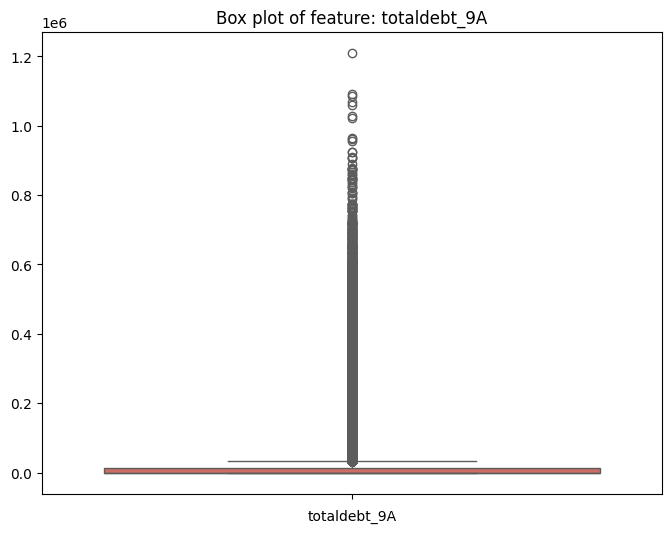

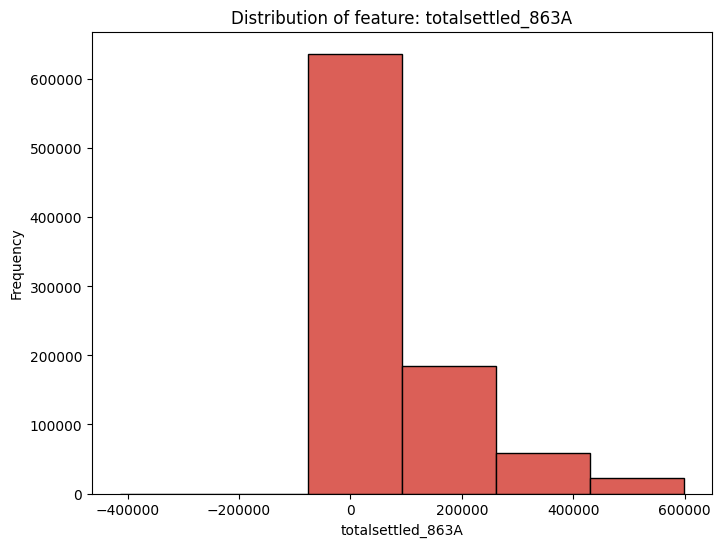

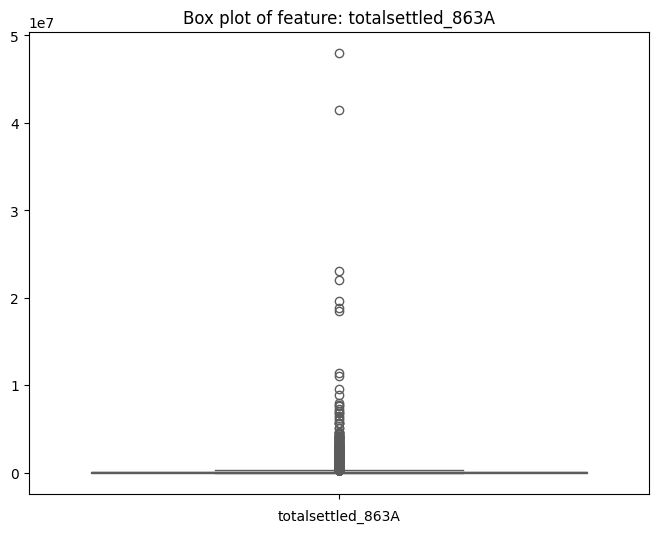

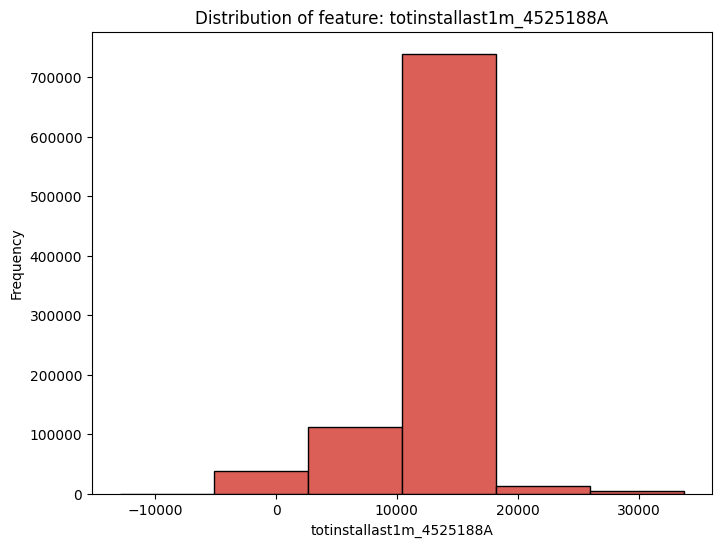

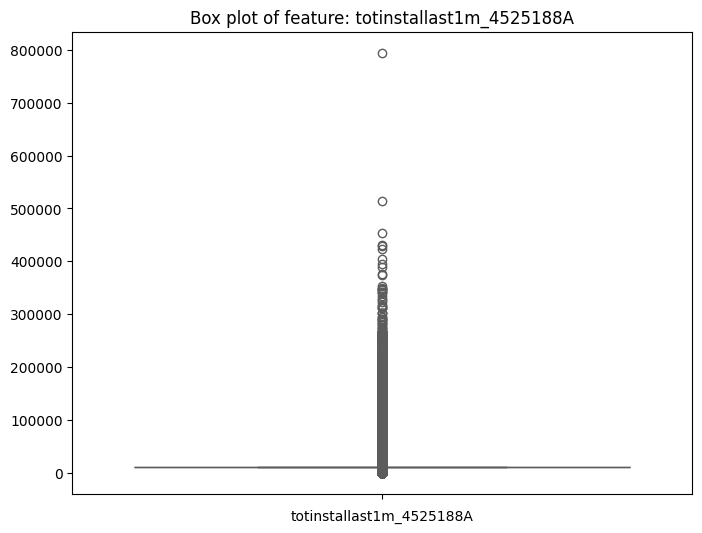

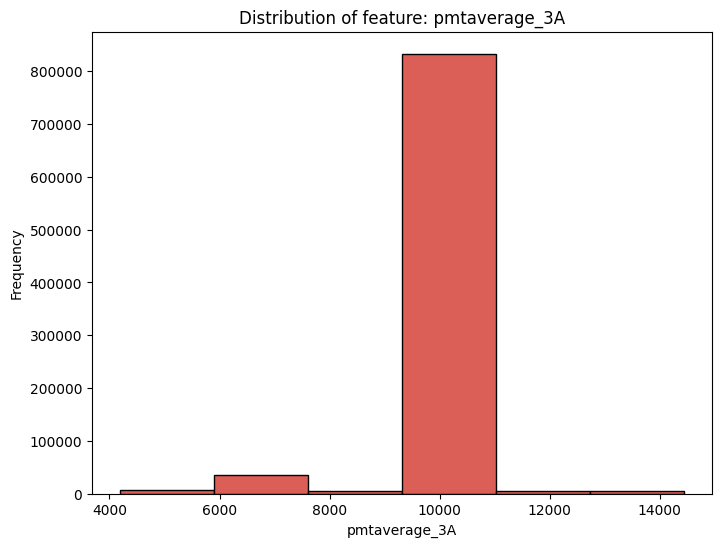

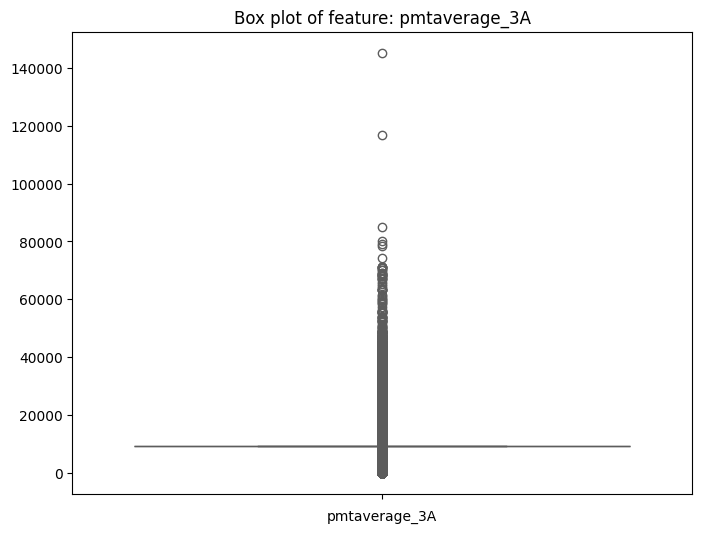

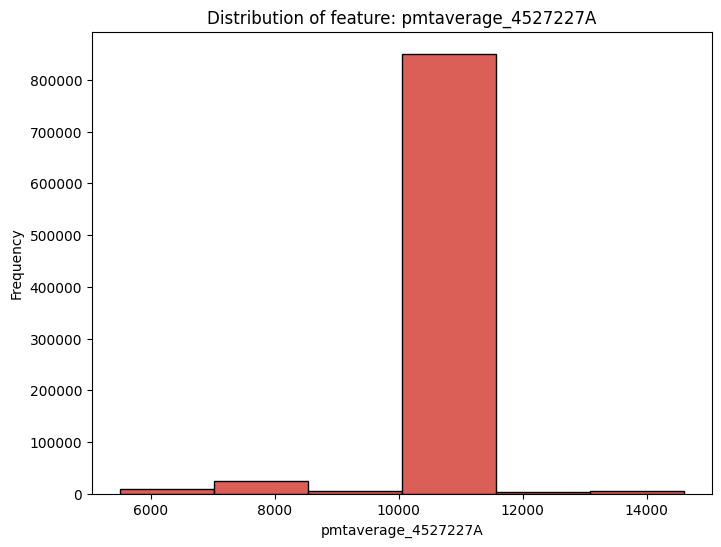

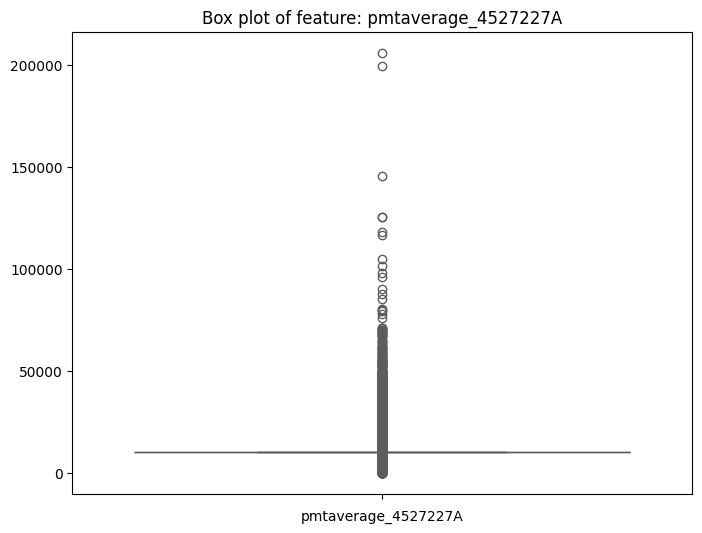

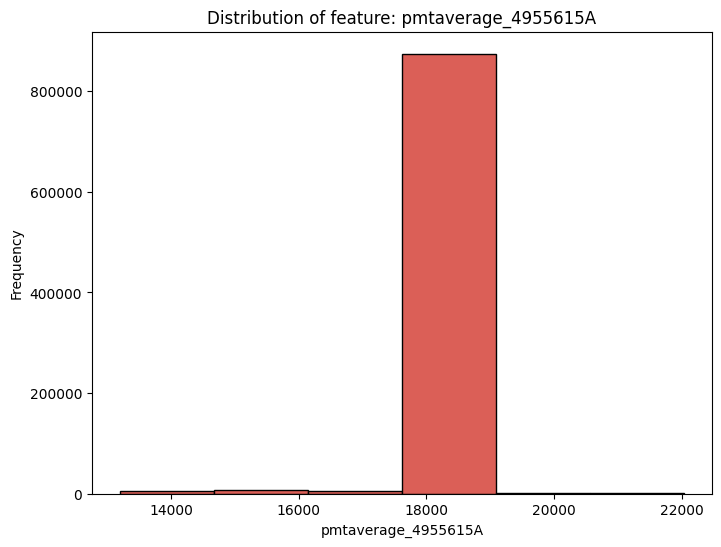

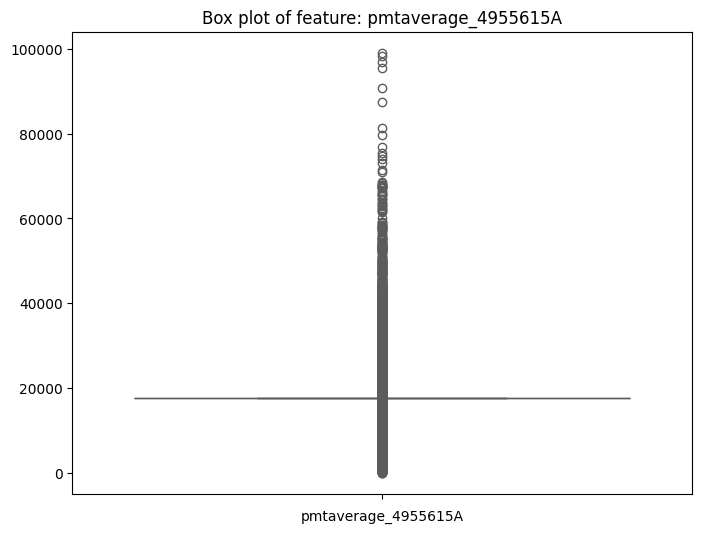

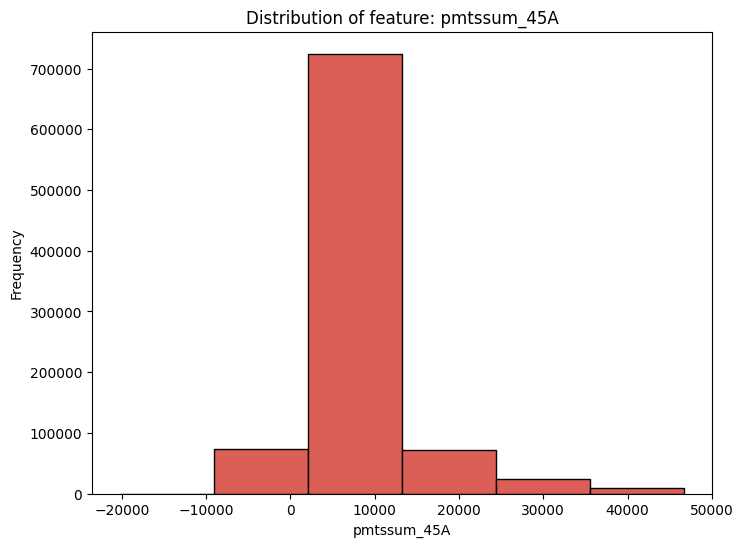

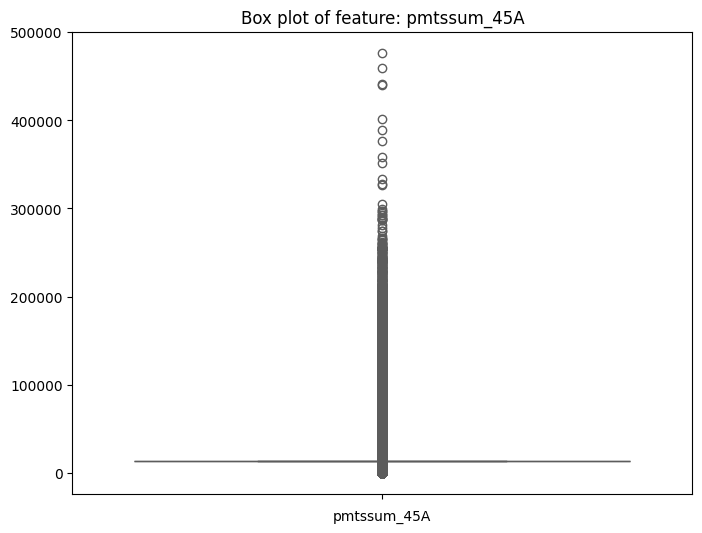

<ipython-input-25-9459c18519bd>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=X_train, palette=colors[:len(X_train[col].unique())])
<ipython-input-25-9459c18519bd>:58: UserWarning: 
The palette list has fewer values (44) than needed (45) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=col, data=X_train, palette=colors[:len(X_train[col].unique())])


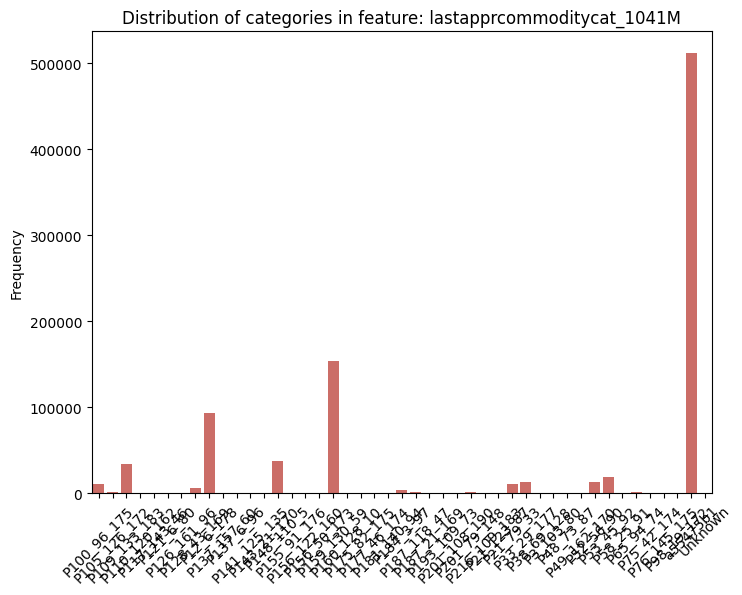

<ipython-input-25-9459c18519bd>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=X_train, palette=colors[:len(X_train[col].unique())])
<ipython-input-25-9459c18519bd>:58: UserWarning: 
The palette list has fewer values (188) than needed (189) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=col, data=X_train, palette=colors[:len(X_train[col].unique())])


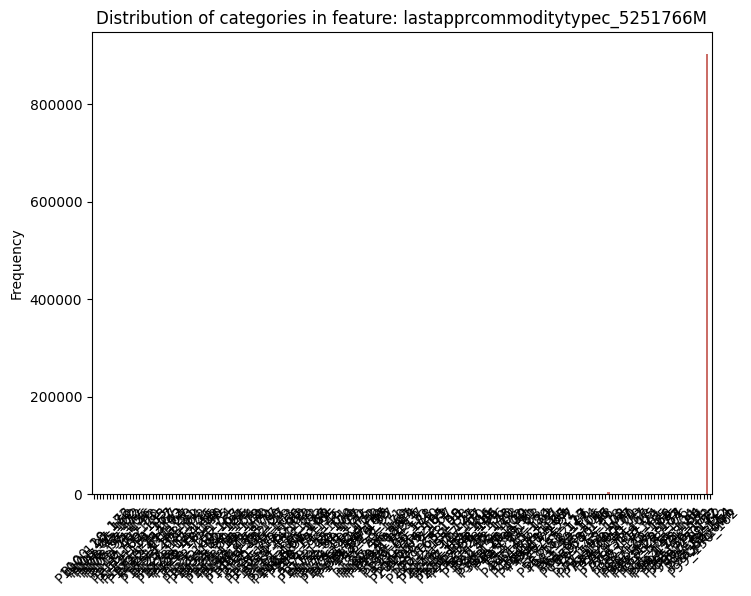

<ipython-input-25-9459c18519bd>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=X_train, palette=colors[:len(X_train[col].unique())])
<ipython-input-25-9459c18519bd>:58: UserWarning: 
The palette list has fewer values (73) than needed (74) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=col, data=X_train, palette=colors[:len(X_train[col].unique())])


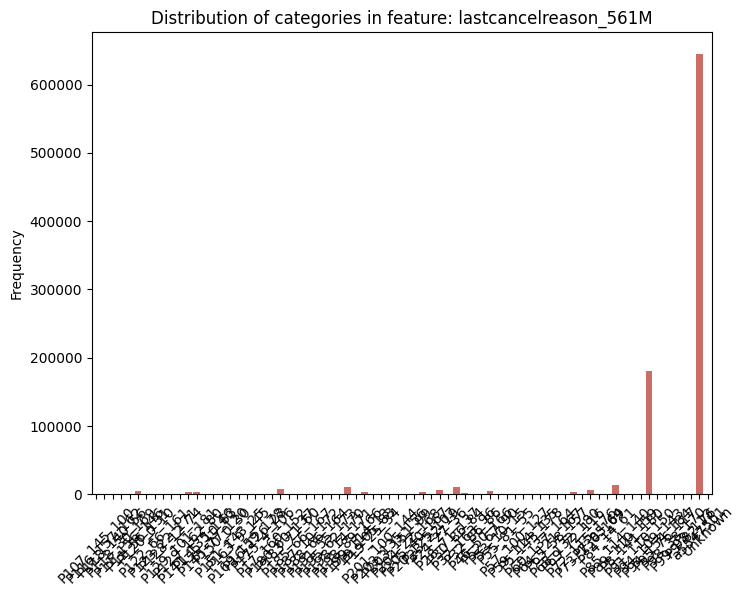

<ipython-input-25-9459c18519bd>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=X_train, palette=colors[:len(X_train[col].unique())])
<ipython-input-25-9459c18519bd>:58: UserWarning: 
The palette list has fewer values (42) than needed (43) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=col, data=X_train, palette=colors[:len(X_train[col].unique())])


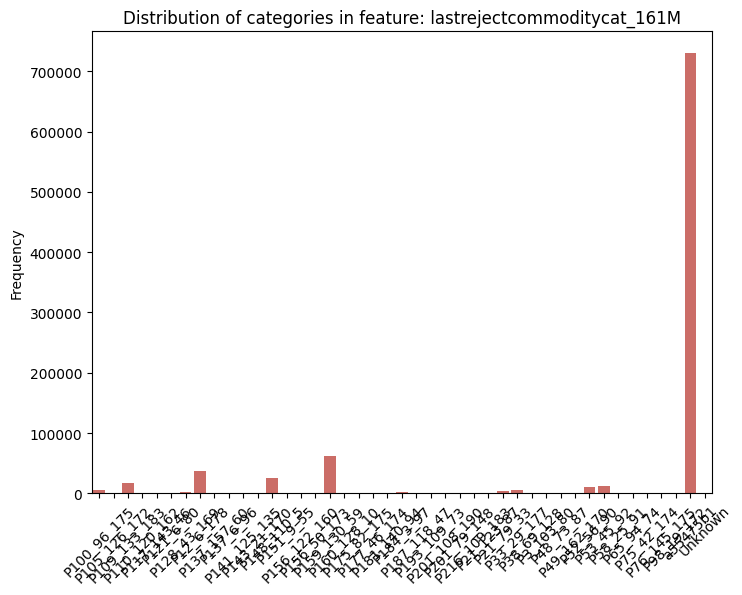

<ipython-input-25-9459c18519bd>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=X_train, palette=colors[:len(X_train[col].unique())])
<ipython-input-25-9459c18519bd>:58: UserWarning: 
The palette list has fewer values (160) than needed (161) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=col, data=X_train, palette=colors[:len(X_train[col].unique())])


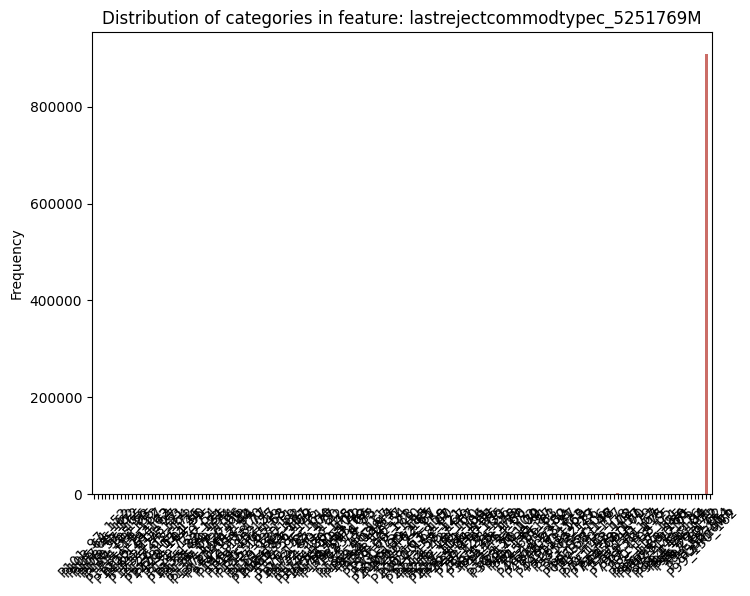

<ipython-input-25-9459c18519bd>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=X_train, palette=colors[:len(X_train[col].unique())])
<ipython-input-25-9459c18519bd>:58: UserWarning: 
The palette list has fewer values (18) than needed (19) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=col, data=X_train, palette=colors[:len(X_train[col].unique())])


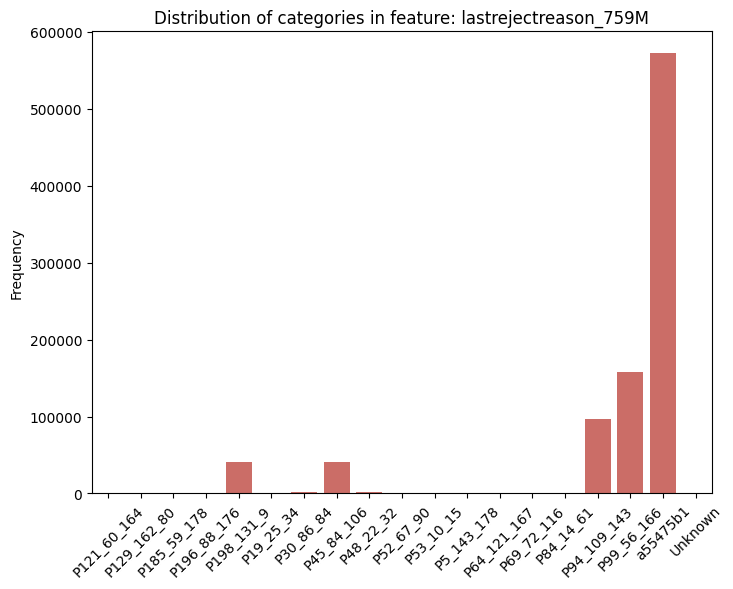

<ipython-input-25-9459c18519bd>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=X_train, palette=colors[:len(X_train[col].unique())])
<ipython-input-25-9459c18519bd>:58: UserWarning: 
The palette list has fewer values (14) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=col, data=X_train, palette=colors[:len(X_train[col].unique())])


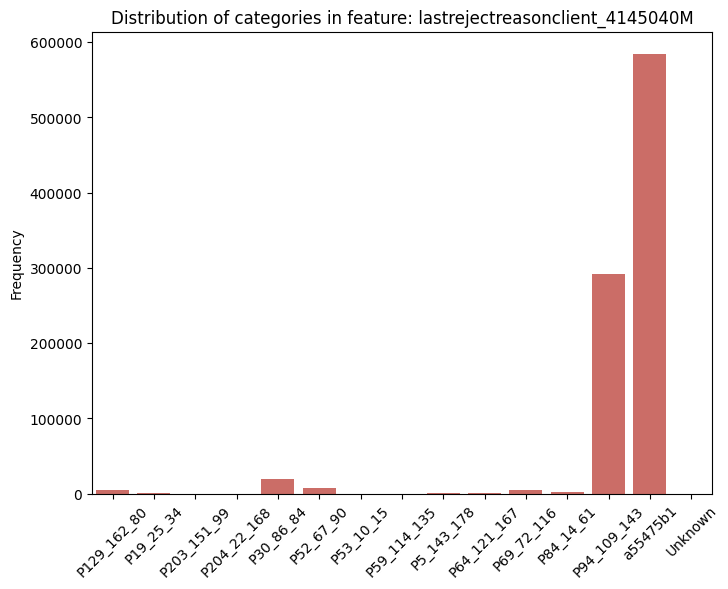

<ipython-input-25-9459c18519bd>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=X_train, palette=colors[:len(X_train[col].unique())])
<ipython-input-25-9459c18519bd>:58: UserWarning: 
The palette list has fewer values (223) than needed (224) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=col, data=X_train, palette=colors[:len(X_train[col].unique())])


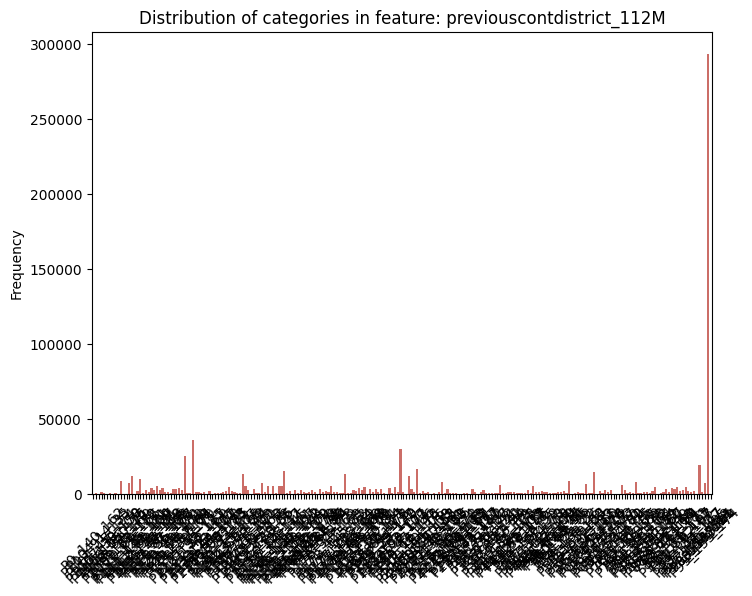

<ipython-input-25-9459c18519bd>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=X_train, palette=colors[:len(X_train[col].unique())])


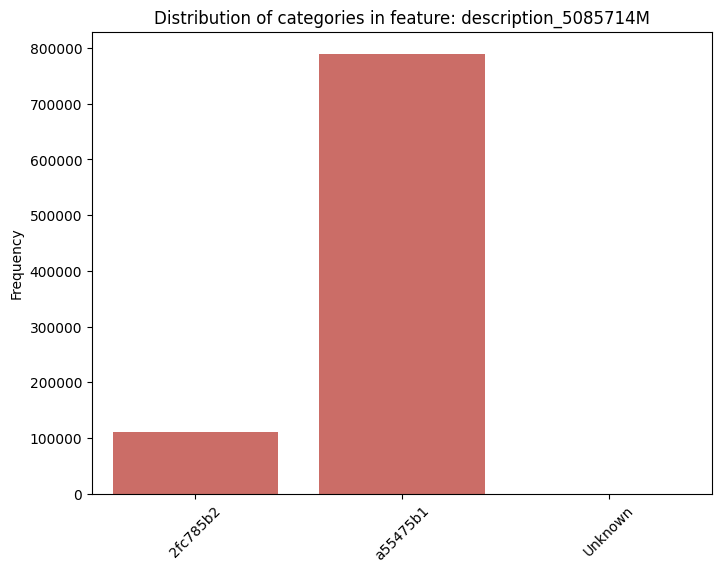

<ipython-input-25-9459c18519bd>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=X_train, palette=colors[:len(X_train[col].unique())])


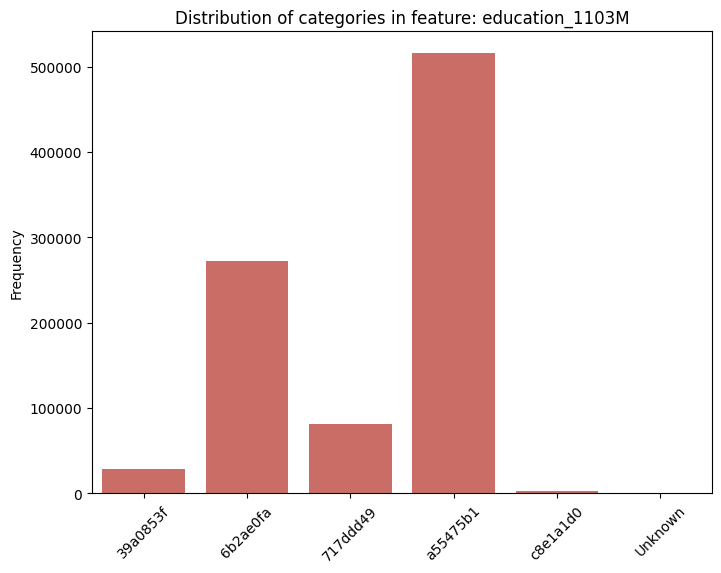

<ipython-input-25-9459c18519bd>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=X_train, palette=colors[:len(X_train[col].unique())])


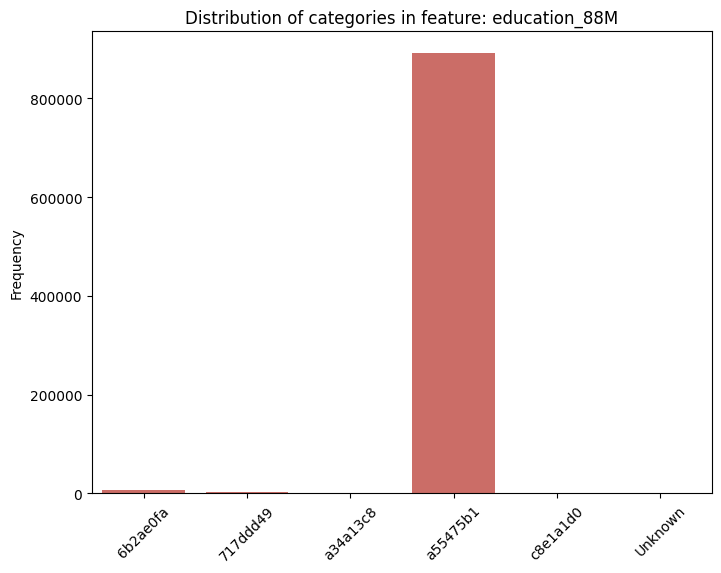

<ipython-input-25-9459c18519bd>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=X_train, palette=colors[:len(X_train[col].unique())])


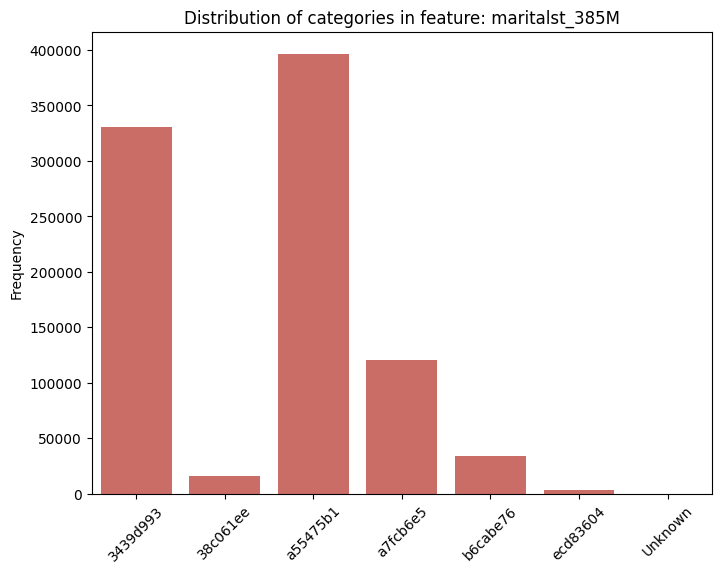

<ipython-input-25-9459c18519bd>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=X_train, palette=colors[:len(X_train[col].unique())])


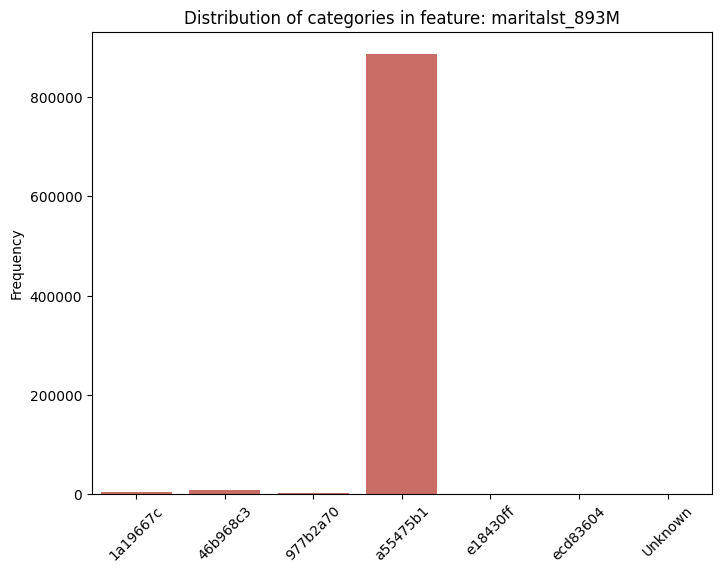

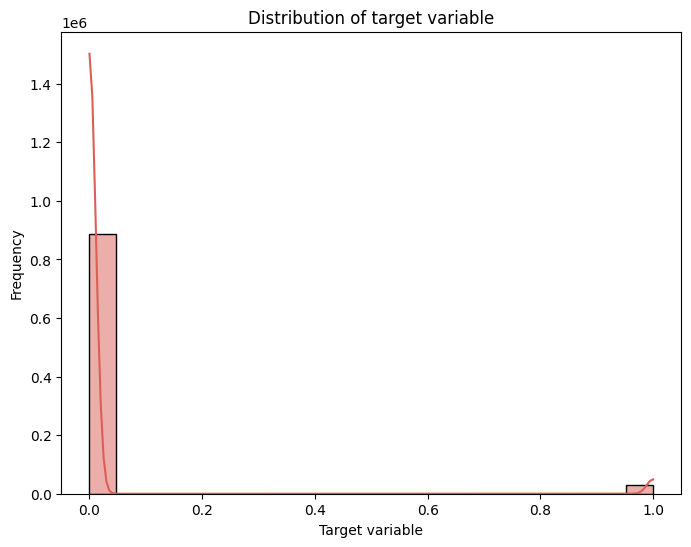

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Color palette for visualizations
colors = sns.color_palette("hls", len(X_train.select_dtypes(include=['int64', 'float64'])))

# Inspect shapes of X_train and y_train
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Numerical feature visualizations (adapt based on your features)
for i, col in enumerate(X_train.select_dtypes(include=['int64', 'float64'])):
    # Count missing values
    missing_count = X_train[col].isna().sum()
    if missing_count > 0:    # there is one missing value in annuitynextmonth_57A
        print(f"Warning: Feature {col} has {missing_count} missing values ({missing_count/len(X_train):.2%}). Consider imputation.")

    # Histogram with custom bins and colors based on normal distribution
    if X_train[col].isna().any():
        ''' Handle missing values (replace with appropriate strategy) '''
        X_train[col] = X_train[col].fillna(X_train[col].mean())

    # Calculate mean and standard deviation
    mean_val = X_train[col].mean()
    std_dev = X_train[col].std()

    # Define bins based on standard deviations
    bins = [
        mean_val - 3 * std_dev,
        mean_val - 2 * std_dev,
        mean_val - std_dev,
        mean_val,
        mean_val + std_dev,
        mean_val + 2 * std_dev,
        mean_val + 3 * std_dev,
    ]

    # Histogram with custom bins and colors
    plt.figure(figsize=(8, 6))
    plt.hist(X_train[col], bins=bins, ec="k", color=colors[i])
    plt.title(f"Distribution of feature: {col}")
    plt.xlabel(f"{col}")
    plt.ylabel("Frequency")
    plt.show()

    # Box plot for outliers
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=col, data=X_train, color=colors[i])
    plt.title(f"Box plot of feature: {col}")
    plt.xlabel(f"{col}")
    plt.ylabel("")  # Remove default y-axis label
    plt.show()

# Categorical feature visualizations
for col in X_train.select_dtypes(include=['category']):
    # Count or bar plot for category distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(x=col, data=X_train, palette=colors[:len(X_train[col].unique())])
    plt.title(f"Distribution of categories in feature: {col}")
    plt.xticks(rotation=45)
    plt.xlabel("")  # Remove default x-axis label
    plt.ylabel("Frequency")
    plt.show()

# Target variable visualization
plt.figure(figsize=(8, 6))
sns.histplot(data=y_train, kde=True, color=colors[0])
plt.title("Distribution of target variable")
plt.xlabel("Target variable")
plt.ylabel("Frequency")
plt.show()

# Further considerations:
# - Investigate relationships between features using scatter matrices or pair plots with rotated labels and informative color schemes.
# - Create feature importance plots if you have trained a model already, using a color scheme and rotated labels for clarity.
# - Adjust plot configurations (e.g., colors, bin sizes, labelpad) for better visualization based on your needs.



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Color palette for visualizations
colors = sns.color_palette("hls", len(X_train.select_dtypes(include=['int64', 'float64'])))

# Inspect shapes of X_train and y_train
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (915995, 48)
y_train shape: (915995,)


# **Box plots**

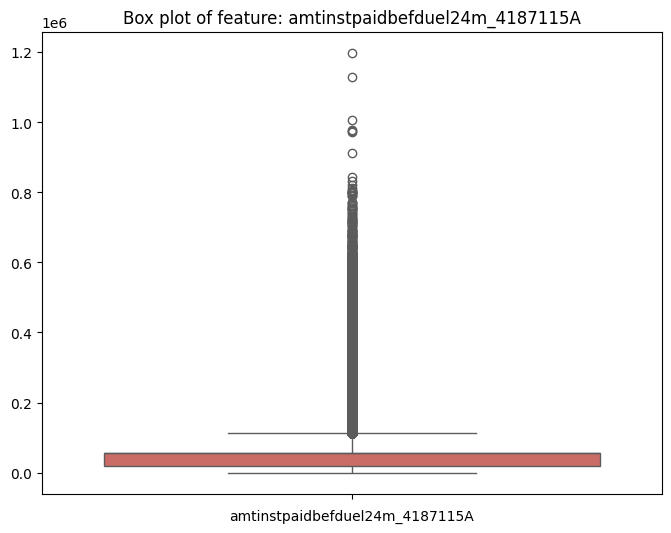

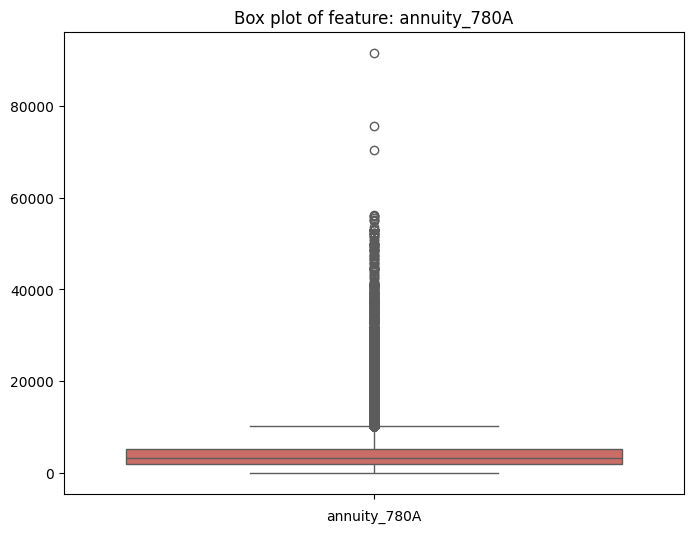

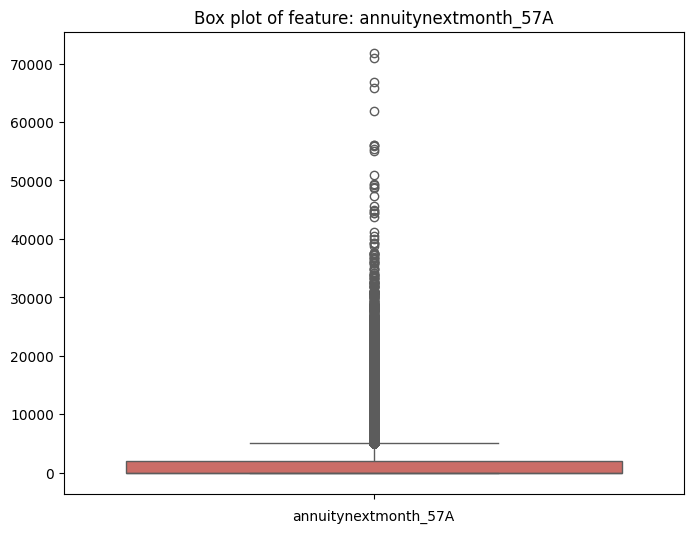

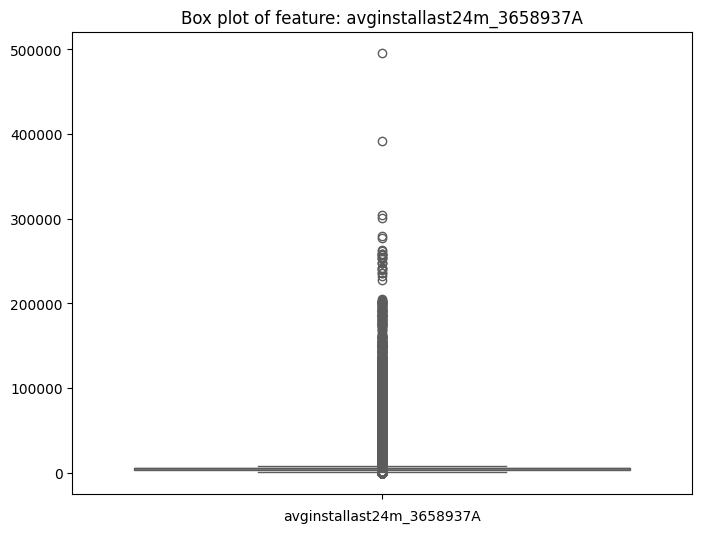

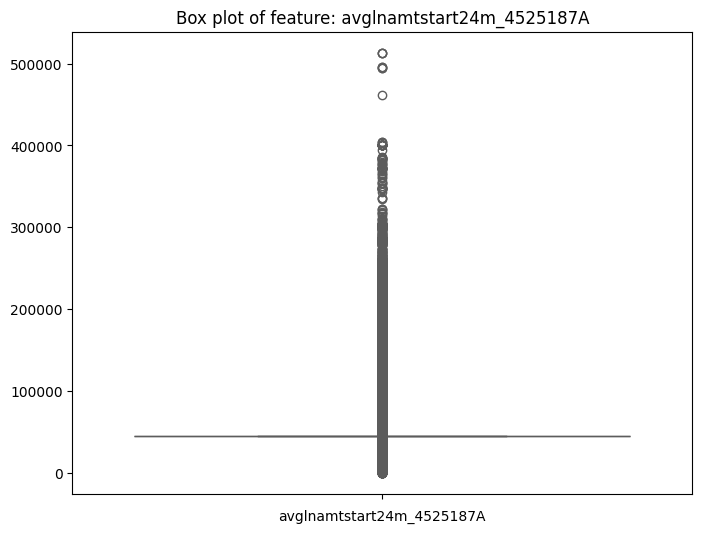

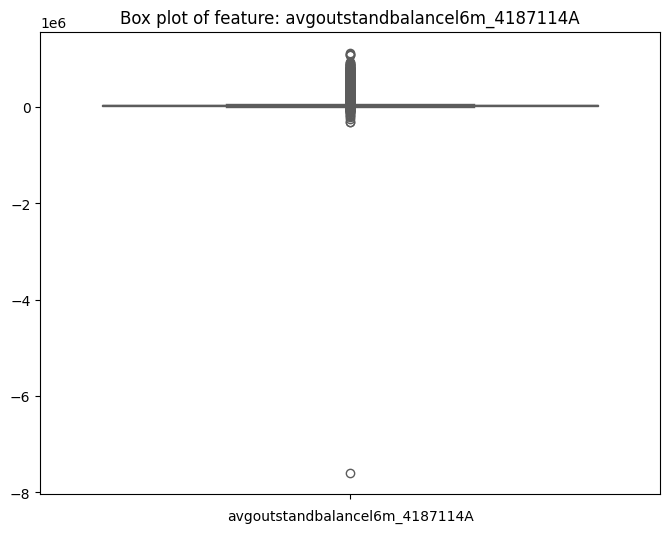

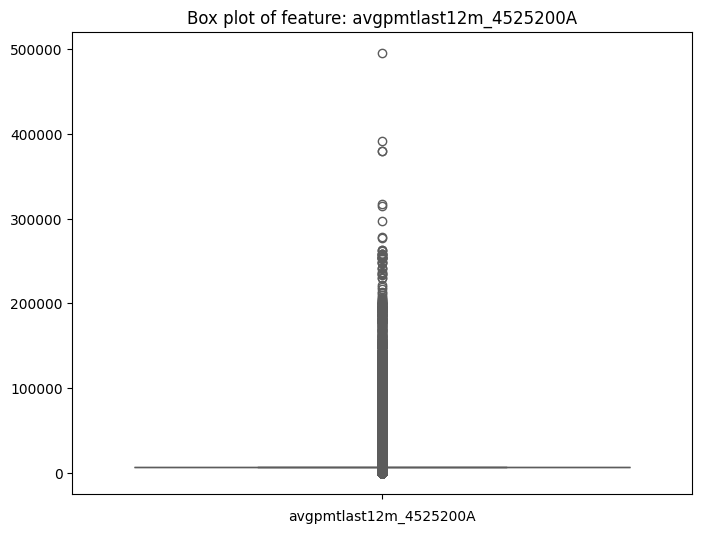

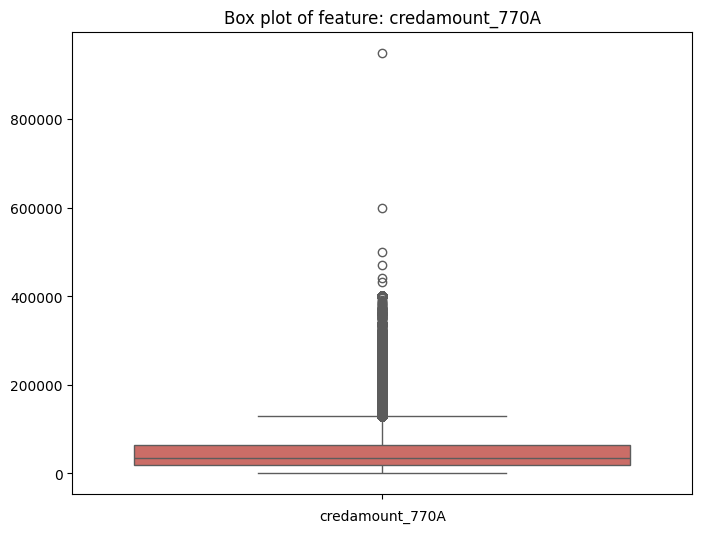

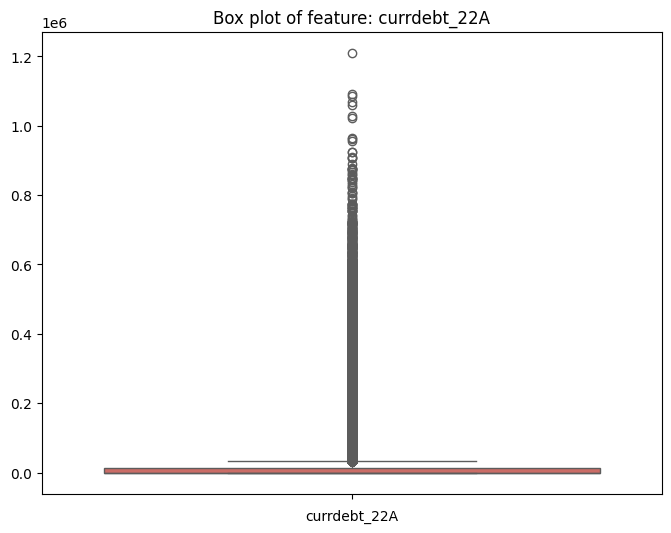

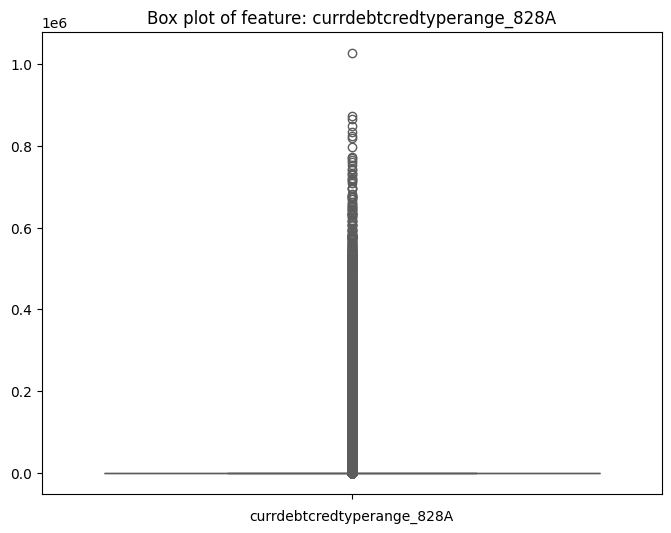

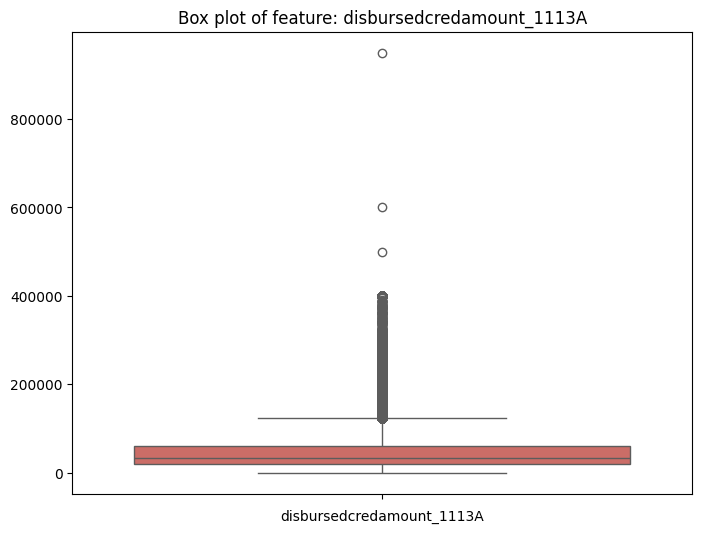

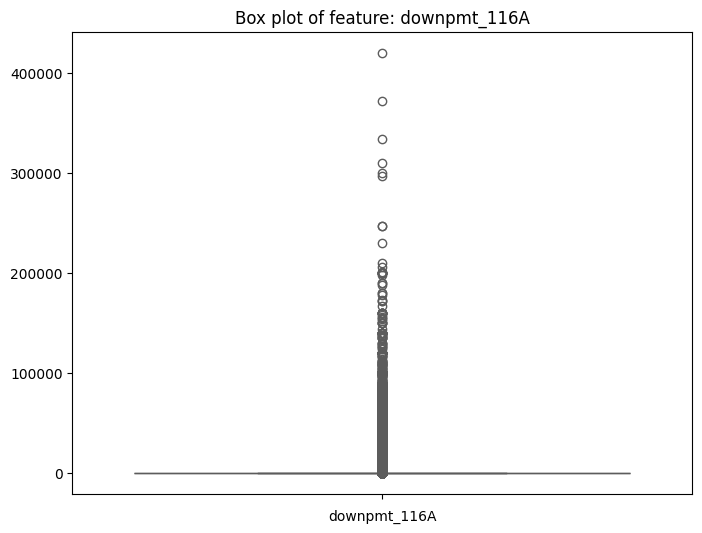

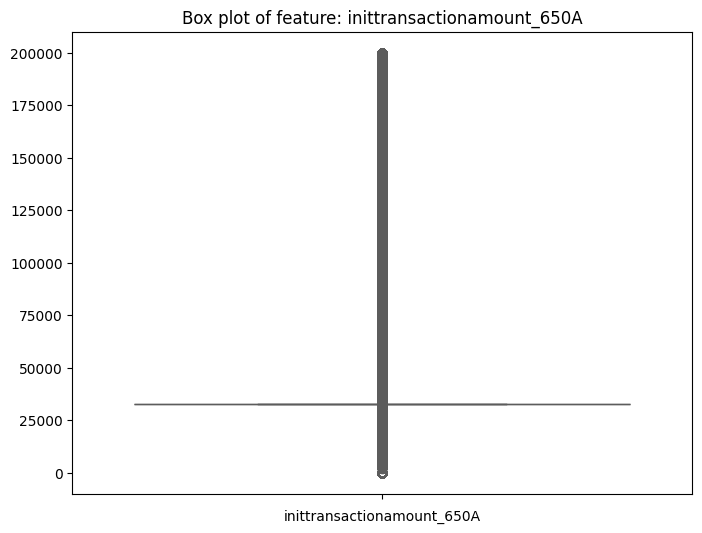

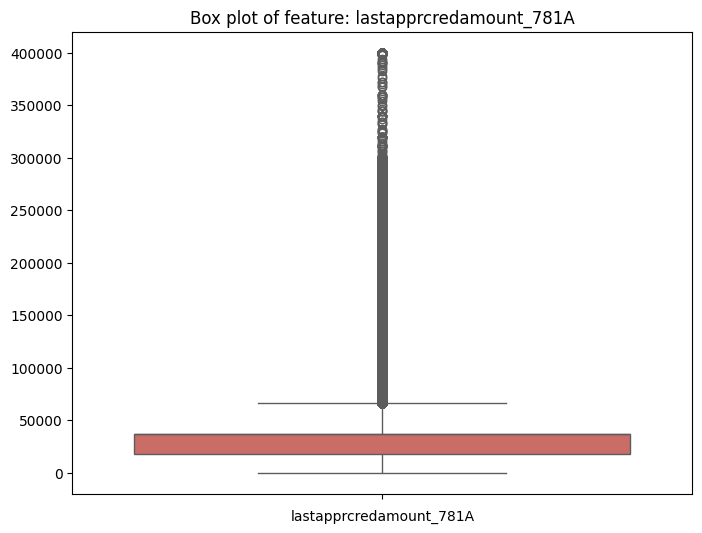

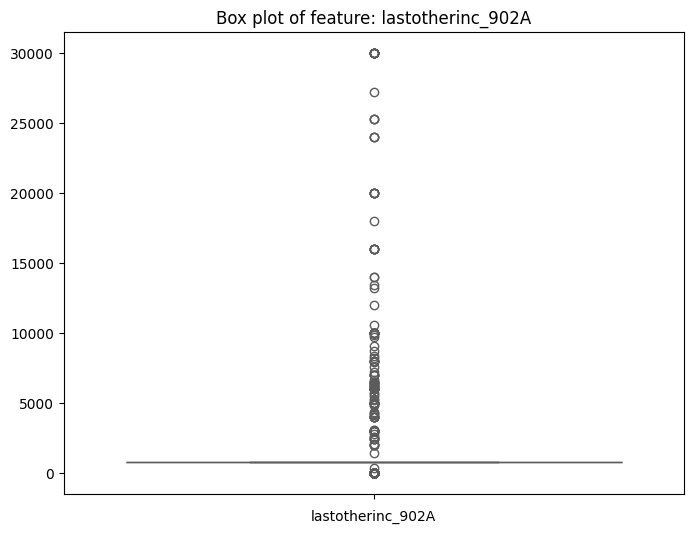

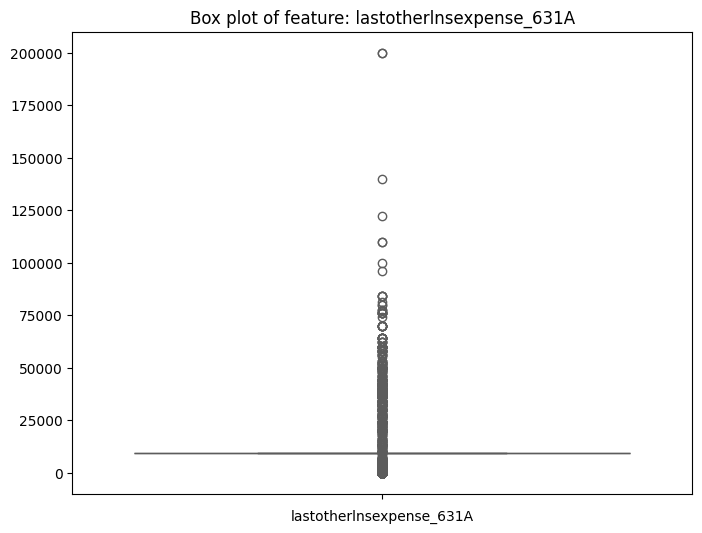

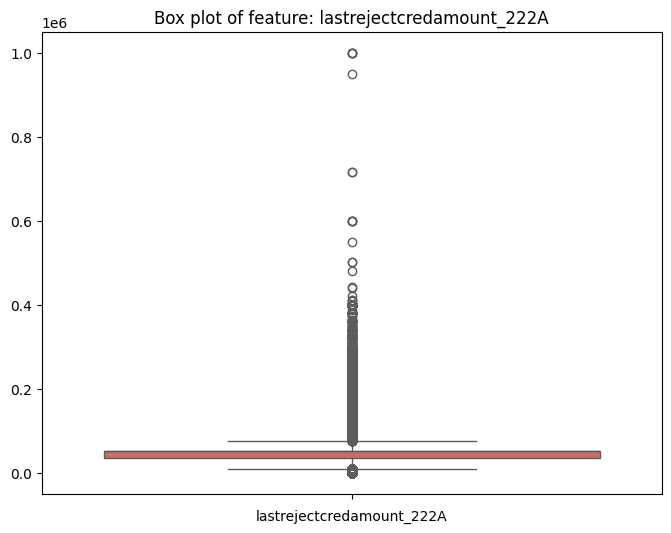

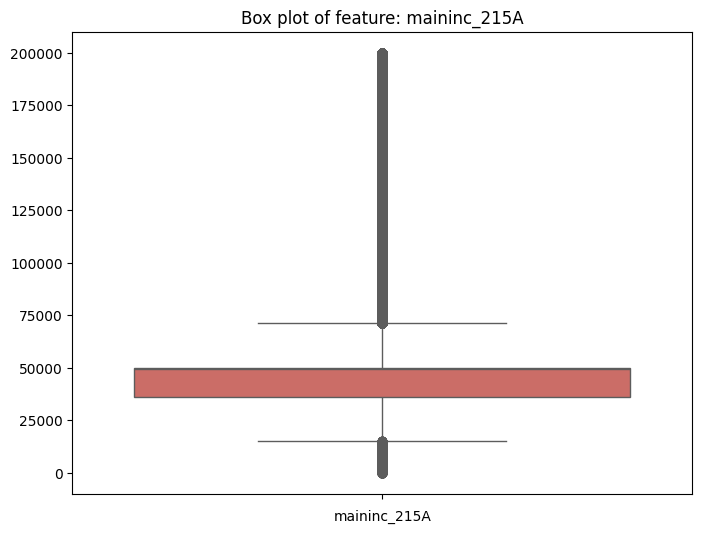

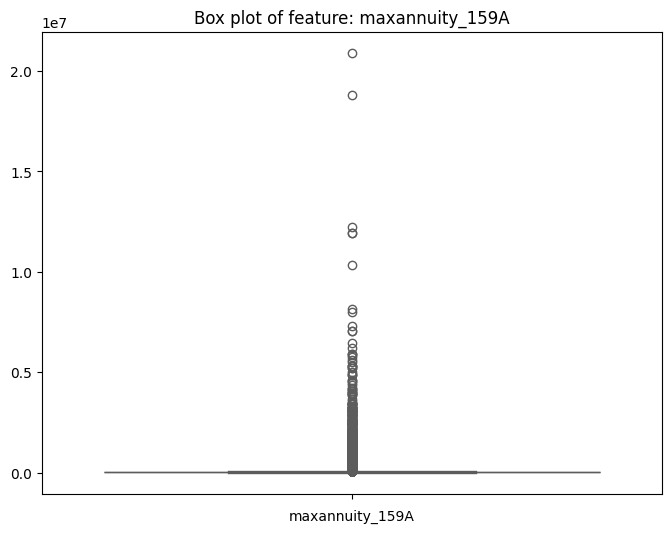

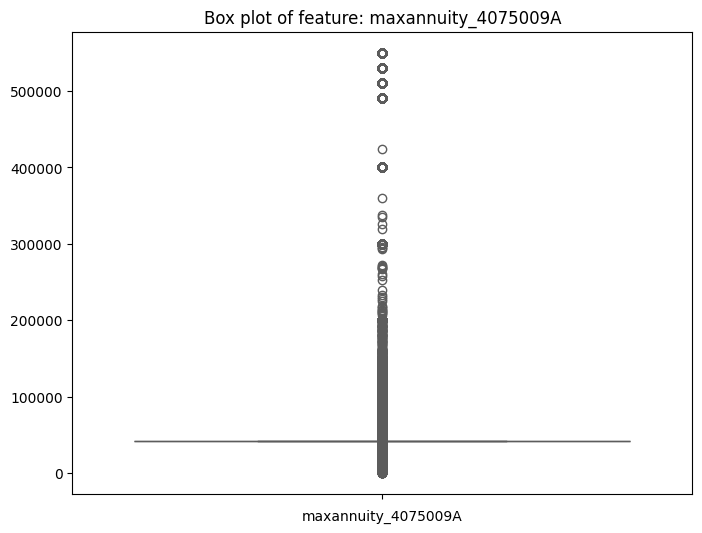

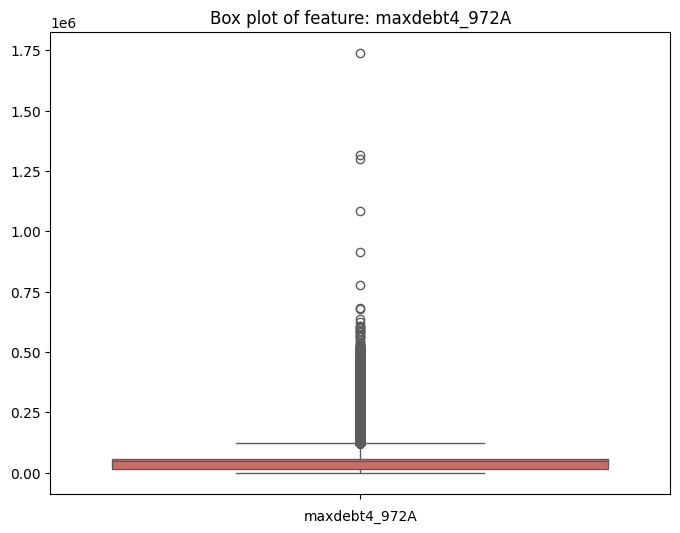

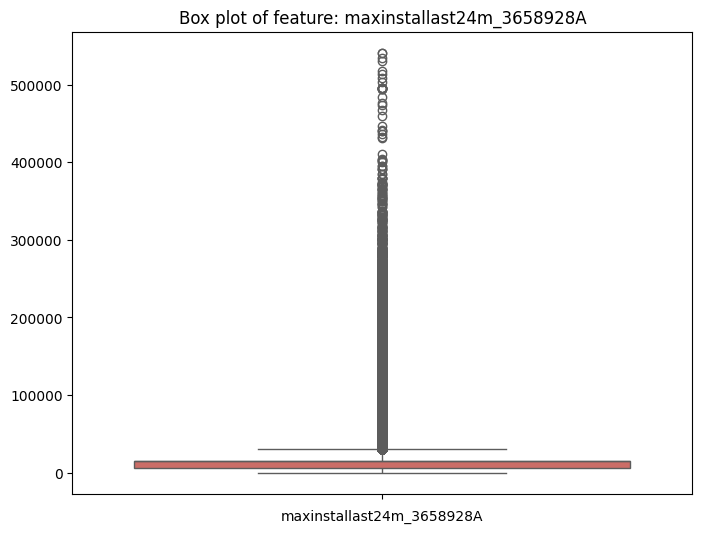

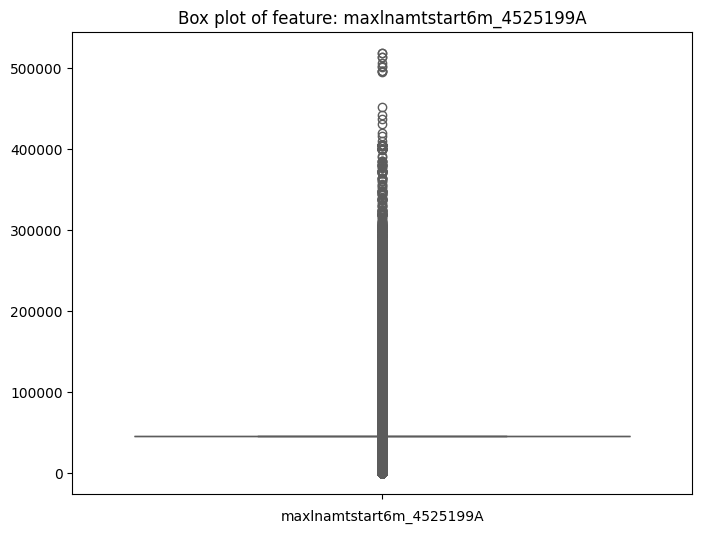

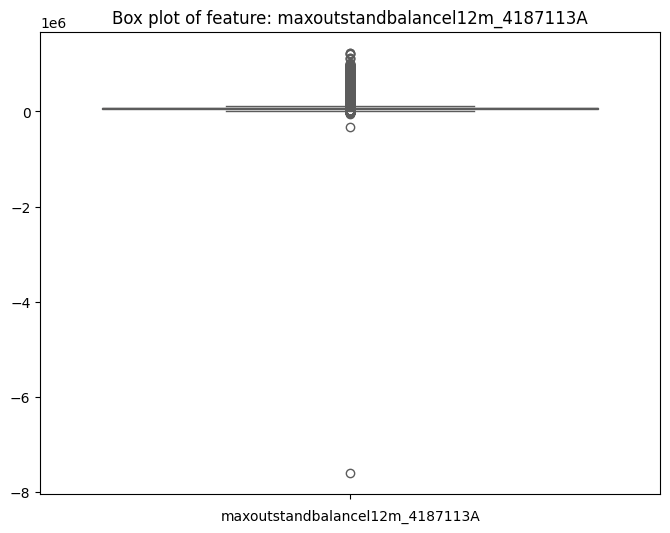

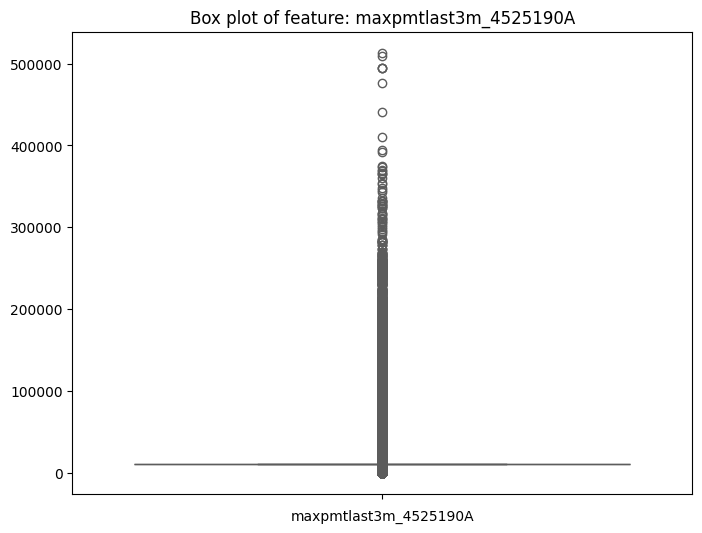

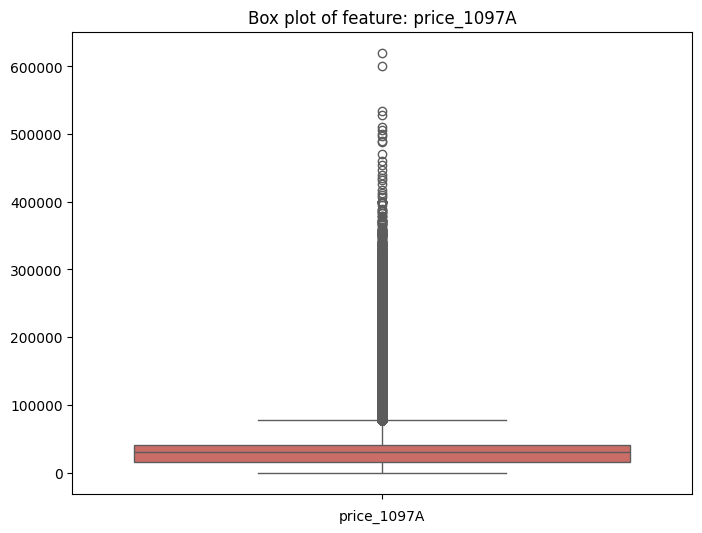

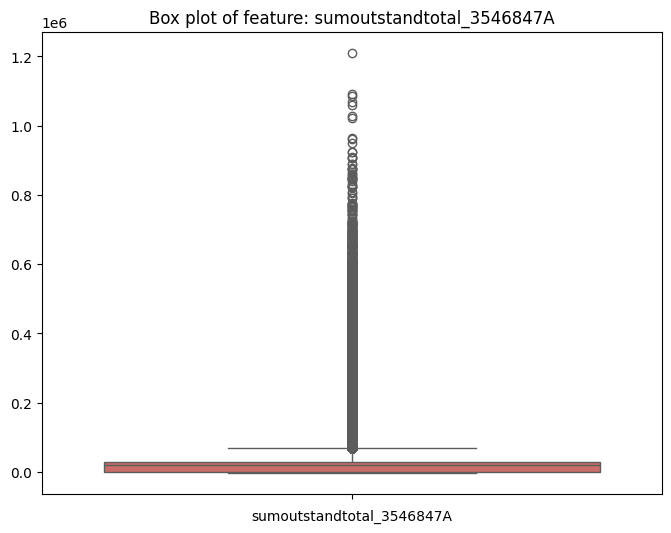

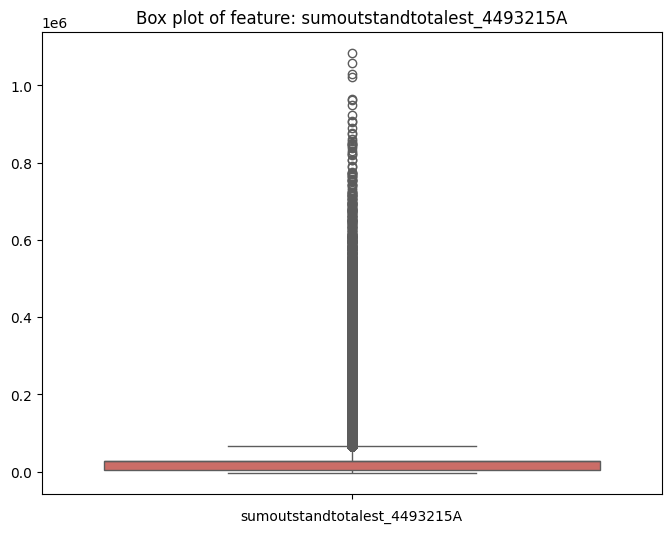

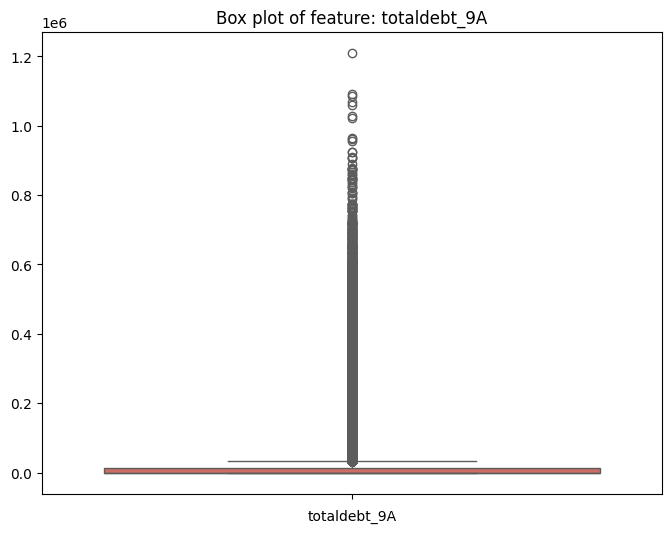

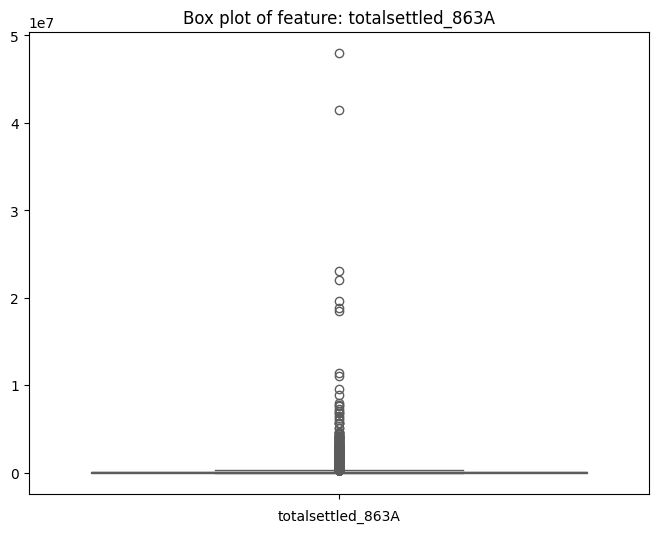

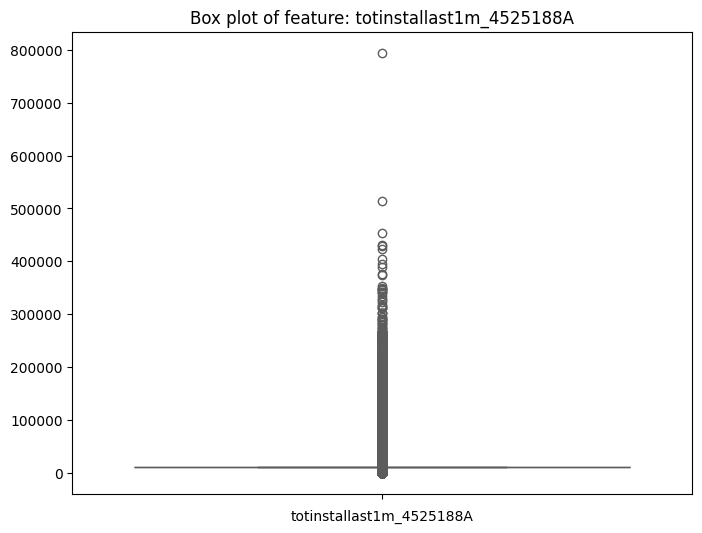

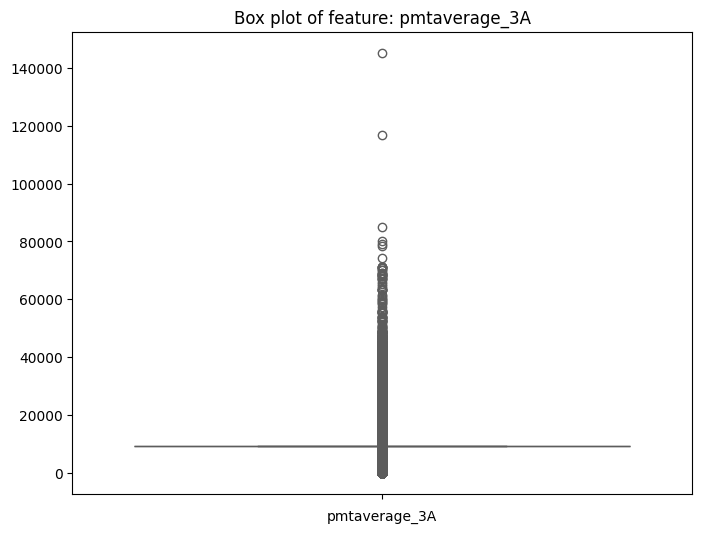

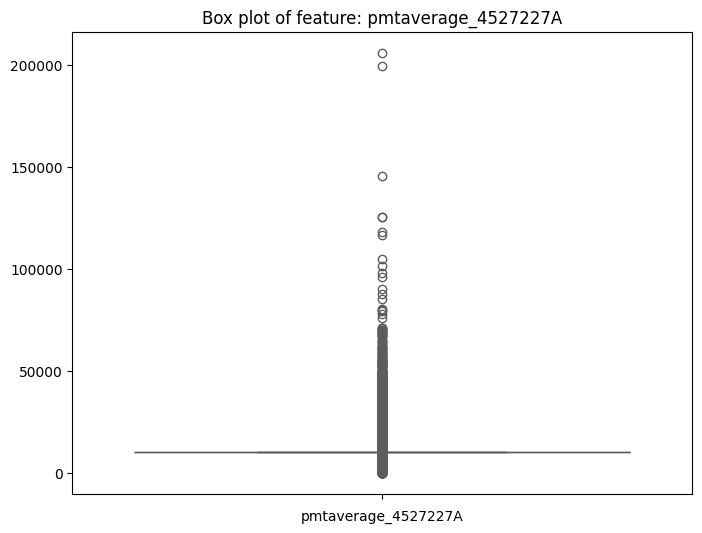

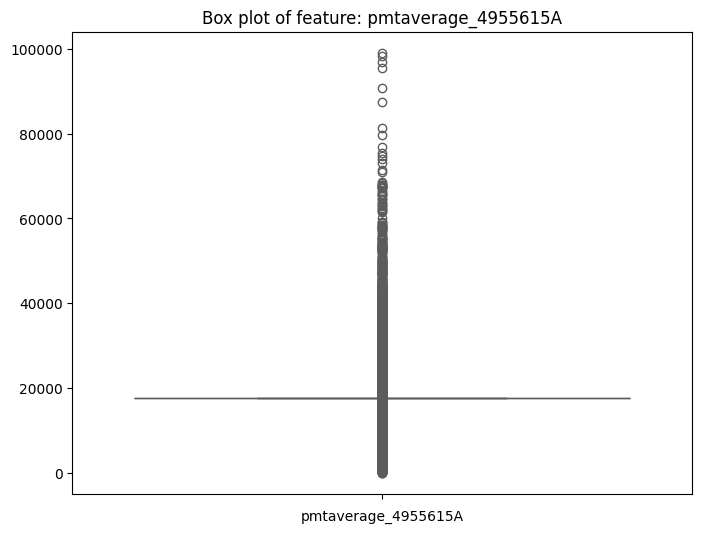

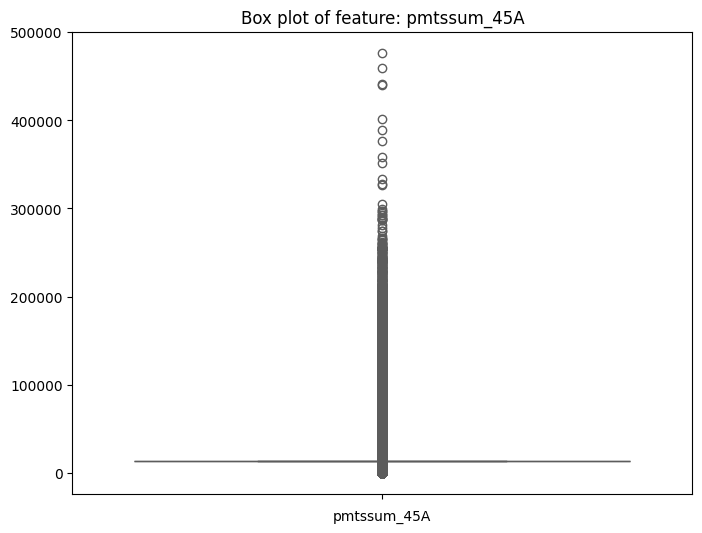

In [ ]:
features_with_missing_values = {}
# Numerical feature visualizations (adapt based on your features)
for i, col in enumerate(X_train.select_dtypes(include=['int64', 'float64'])):
    # Count missing values
    missing_count = X_train[col].isna().sum()
    if missing_count > 0:
        print(f"Warning: Feature {col} has {missing_count} missing values ({missing_count/len(X_train):.2%}). Consider imputation.")
        features_with_missing_values[col] = missing_count

    # Handle missing values (replace with appropriate strategy)
    # X_train[col] = X_train[col].fillna(X_train[col].mean())  # Example imputation

    # Box plot for outliers
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=col, data=X_train, color=colors[i])
    plt.title(f"Box plot of feature: {col}")
    plt.xlabel(f"{col}")
    plt.ylabel("")
    plt.show()

### Bar graphs

<ipython-input-28-a834786dcbb8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, palette=sns.color_palette("hls", len(df[col].unique())))
<ipython-input-28-a834786dcbb8>:4: UserWarning: 
The palette list has fewer values (43) than needed (44) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(y=col, data=df, palette=sns.color_palette("hls", len(df[col].unique())))


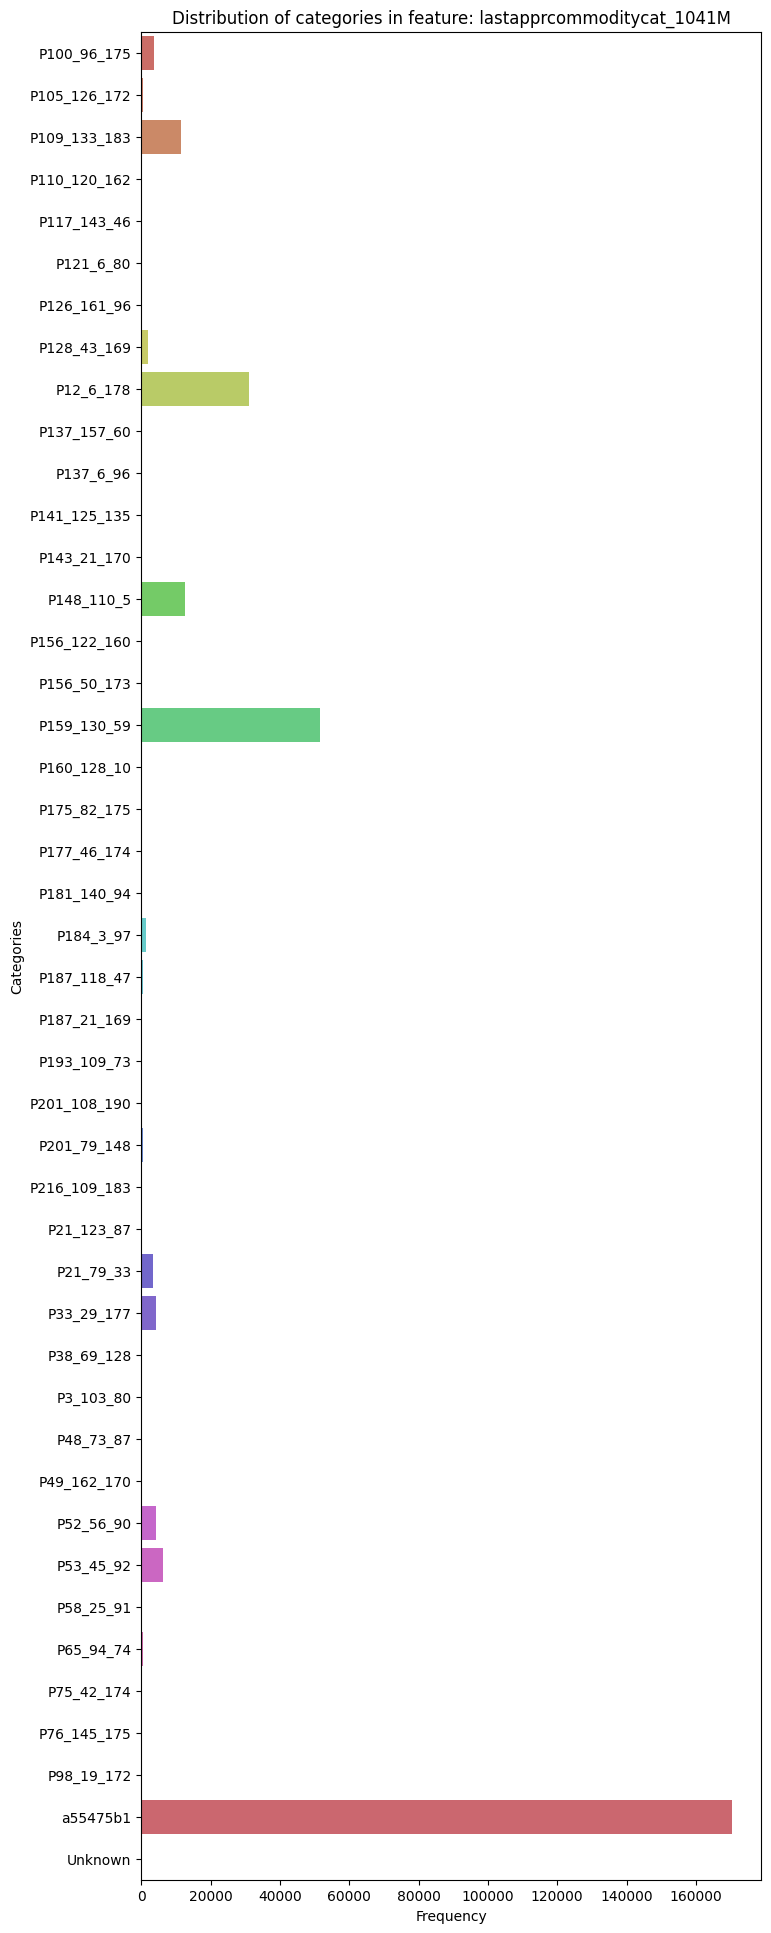

<ipython-input-28-a834786dcbb8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, palette=sns.color_palette("hls", len(df[col].unique())))
<ipython-input-28-a834786dcbb8>:4: UserWarning: 
The palette list has fewer values (143) than needed (144) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(y=col, data=df, palette=sns.color_palette("hls", len(df[col].unique())))


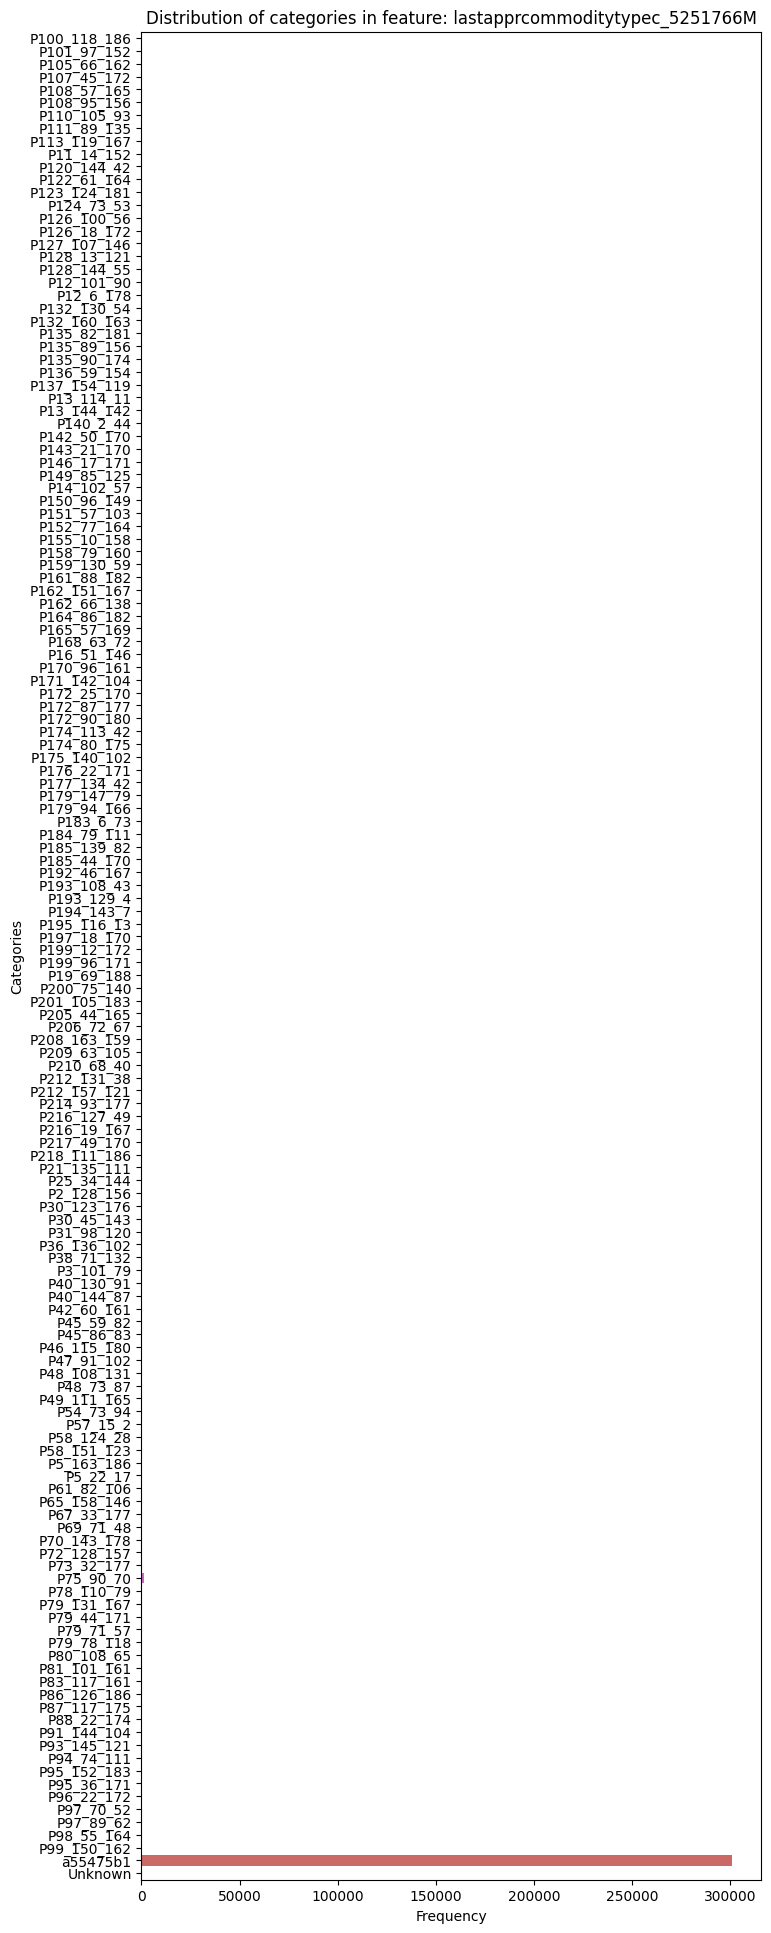

<ipython-input-28-a834786dcbb8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, palette=sns.color_palette("hls", len(df[col].unique())))
<ipython-input-28-a834786dcbb8>:4: UserWarning: 
The palette list has fewer values (62) than needed (63) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(y=col, data=df, palette=sns.color_palette("hls", len(df[col].unique())))


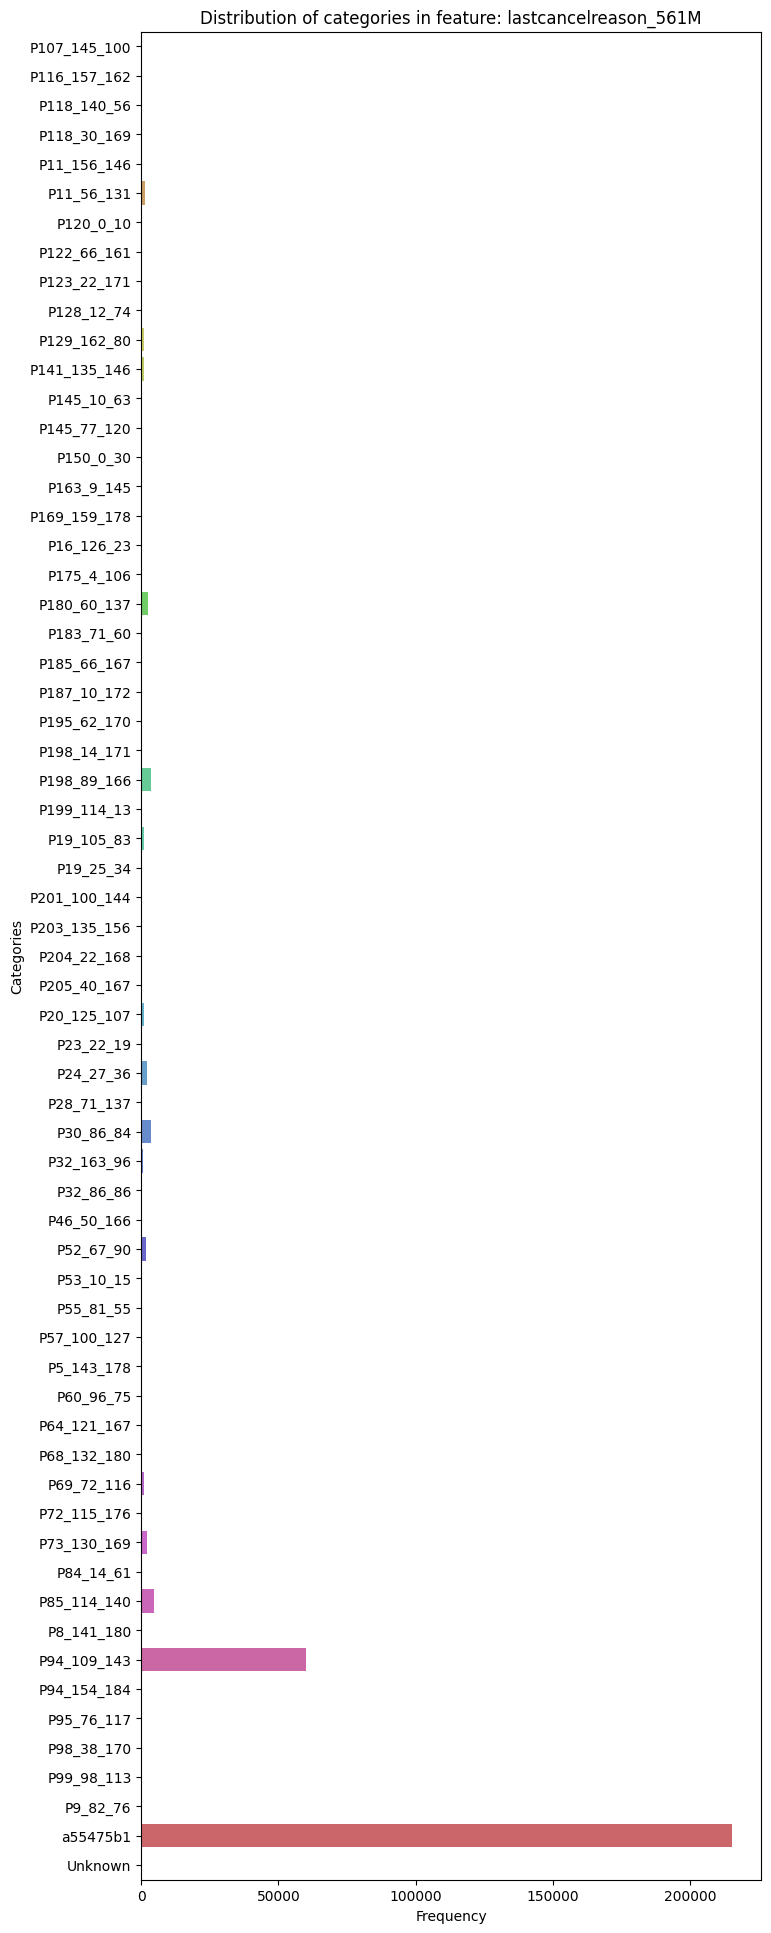

<ipython-input-28-a834786dcbb8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, palette=sns.color_palette("hls", len(df[col].unique())))
<ipython-input-28-a834786dcbb8>:4: UserWarning: 
The palette list has fewer values (40) than needed (41) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(y=col, data=df, palette=sns.color_palette("hls", len(df[col].unique())))


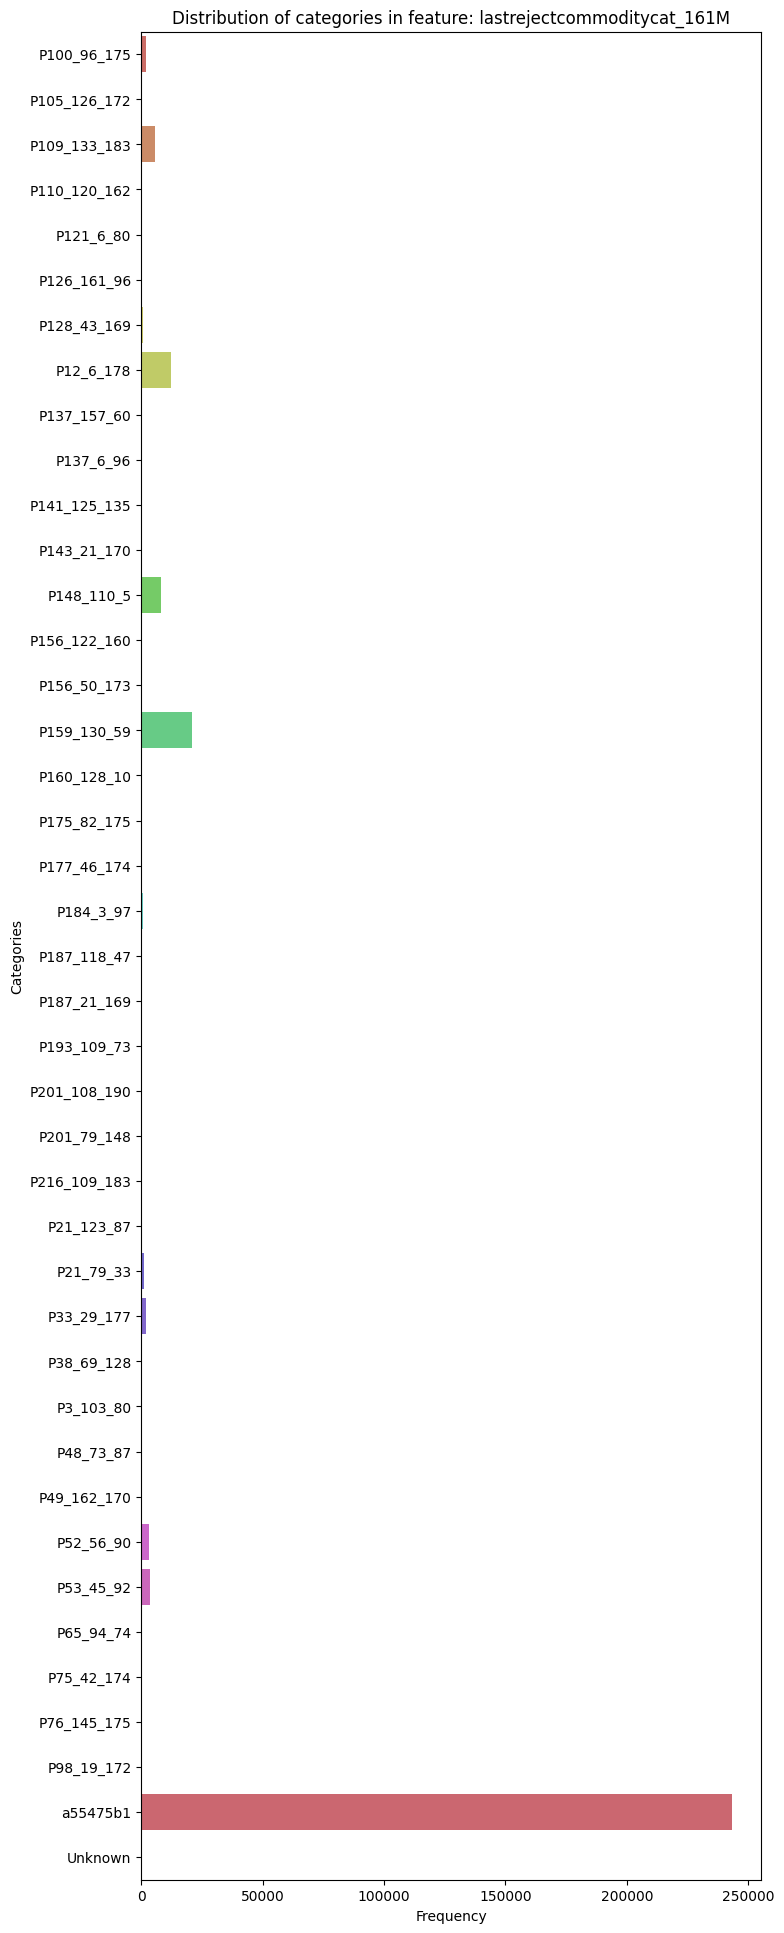

<ipython-input-28-a834786dcbb8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, palette=sns.color_palette("hls", len(df[col].unique())))
<ipython-input-28-a834786dcbb8>:4: UserWarning: 
The palette list has fewer values (122) than needed (123) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(y=col, data=df, palette=sns.color_palette("hls", len(df[col].unique())))


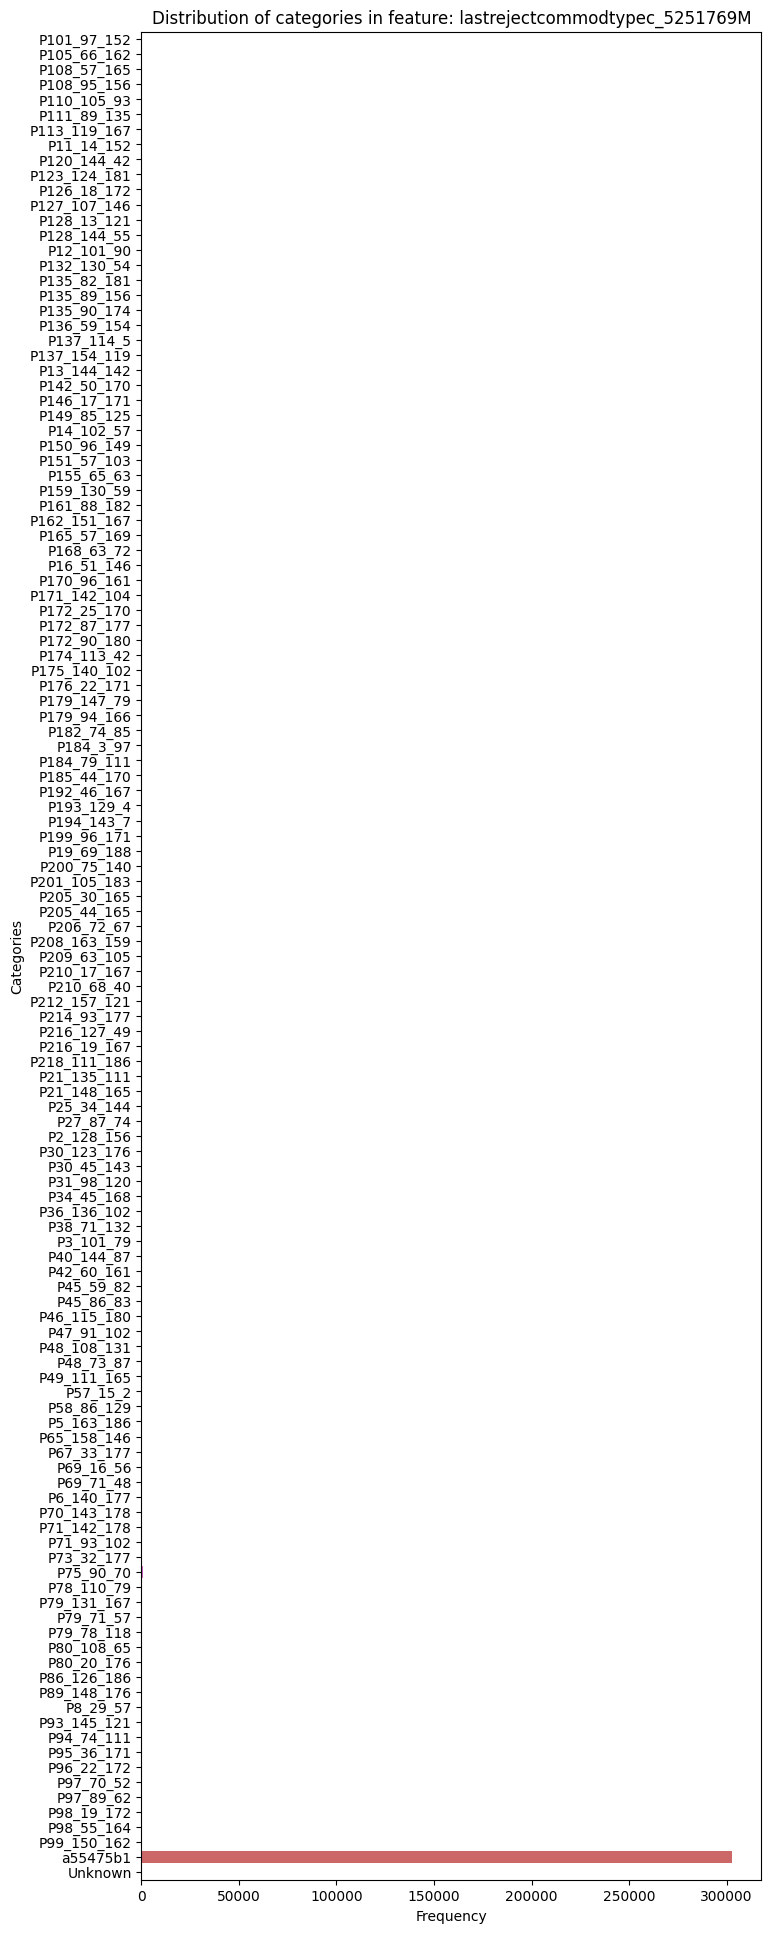

<ipython-input-28-a834786dcbb8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, palette=sns.color_palette("hls", len(df[col].unique())))
<ipython-input-28-a834786dcbb8>:4: UserWarning: 
The palette list has fewer values (17) than needed (18) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(y=col, data=df, palette=sns.color_palette("hls", len(df[col].unique())))


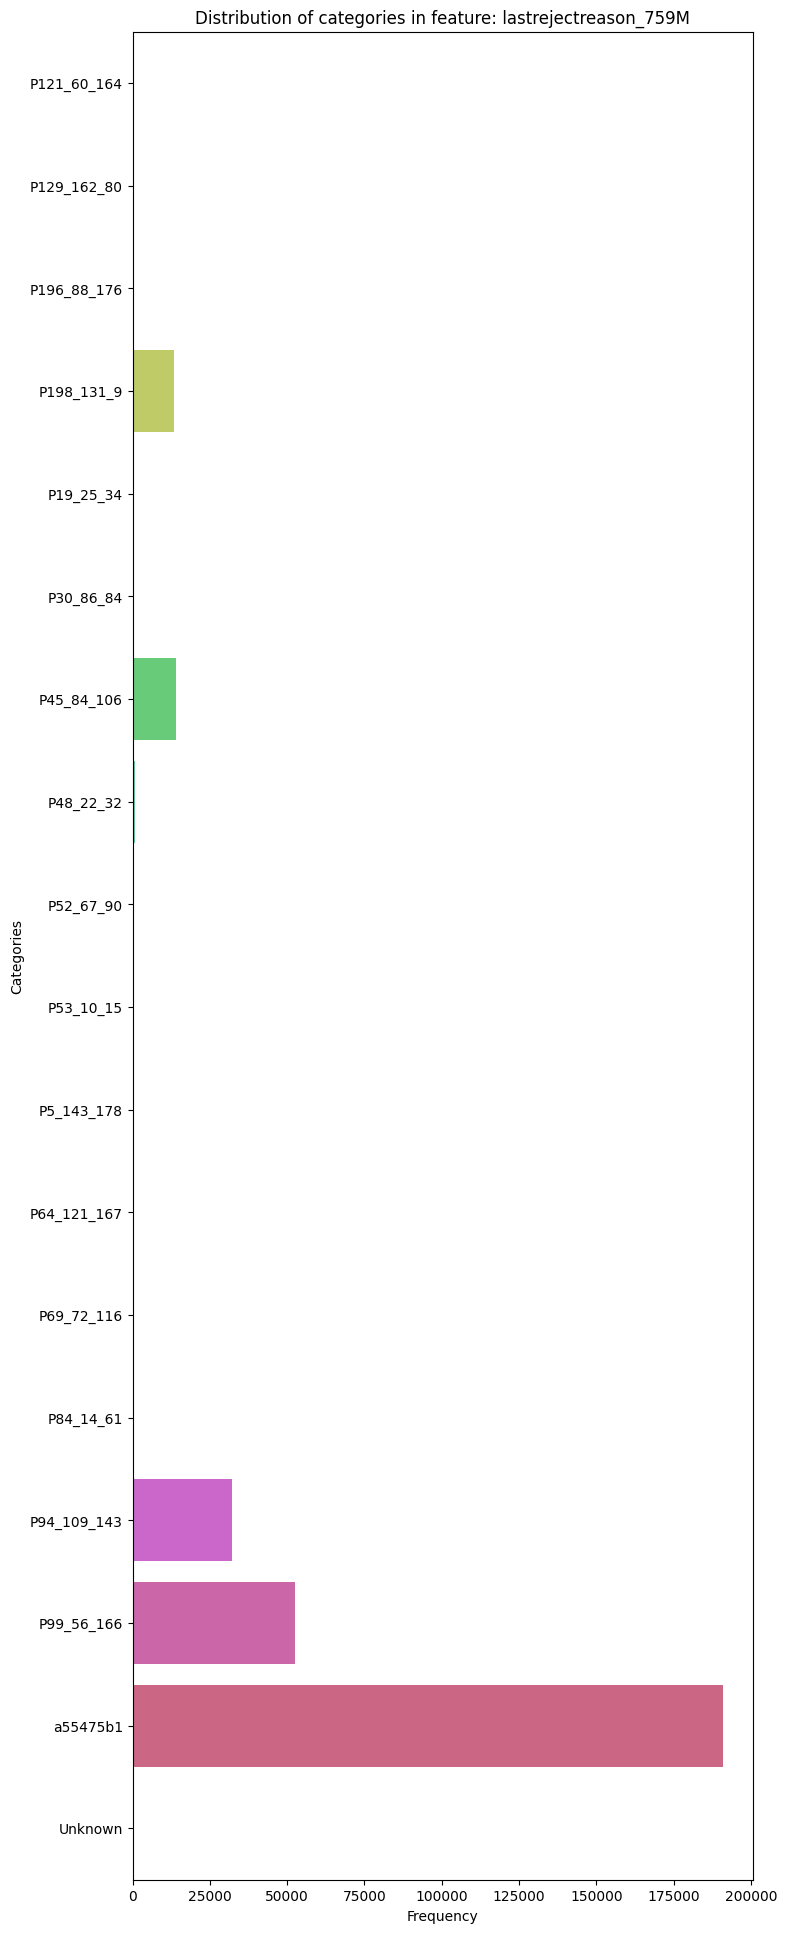

<ipython-input-28-a834786dcbb8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, palette=sns.color_palette("hls", len(df[col].unique())))
<ipython-input-28-a834786dcbb8>:4: UserWarning: 
The palette list has fewer values (12) than needed (13) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(y=col, data=df, palette=sns.color_palette("hls", len(df[col].unique())))


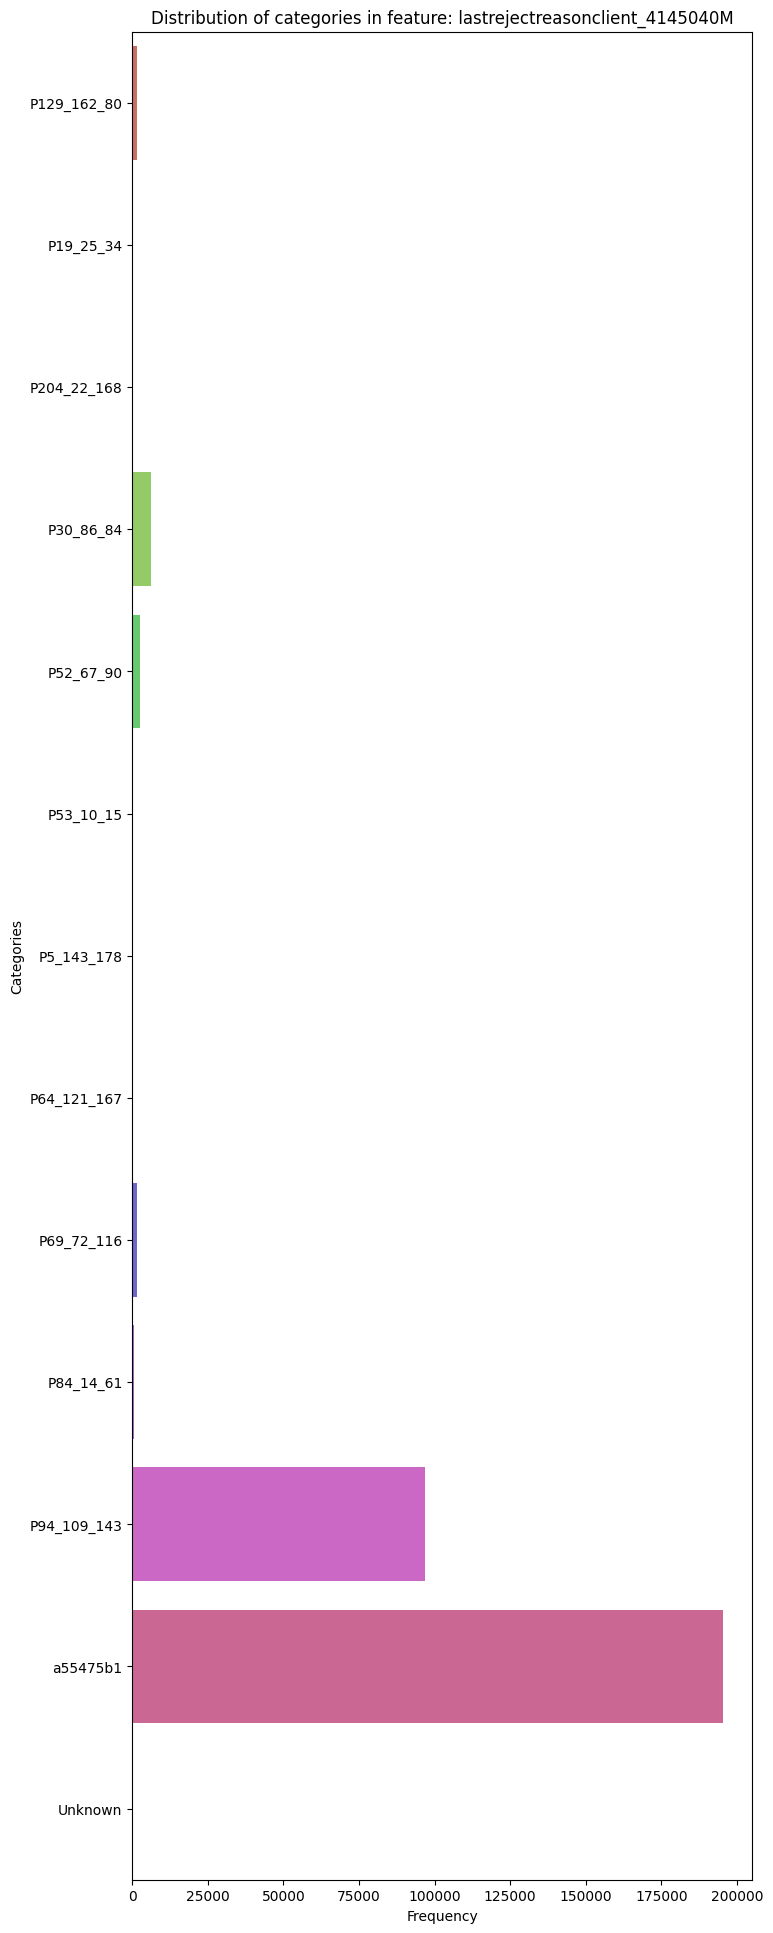

<ipython-input-28-a834786dcbb8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, palette=sns.color_palette("hls", len(df[col].unique())))
<ipython-input-28-a834786dcbb8>:4: UserWarning: 
The palette list has fewer values (223) than needed (224) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(y=col, data=df, palette=sns.color_palette("hls", len(df[col].unique())))


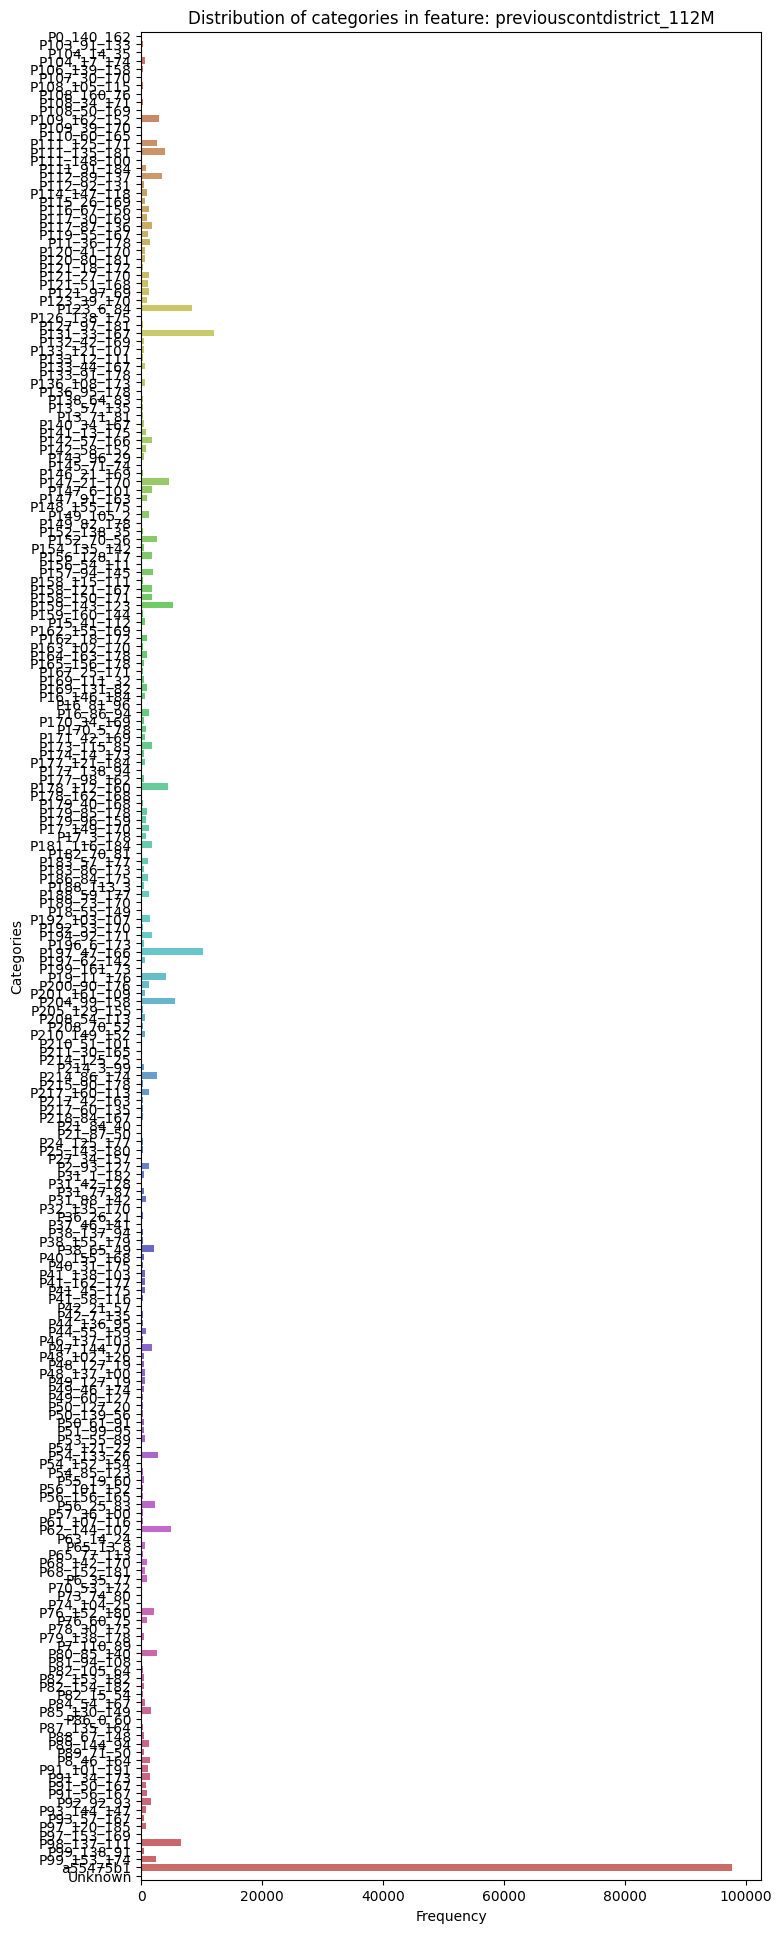

<ipython-input-28-a834786dcbb8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, palette=sns.color_palette("hls", len(df[col].unique())))


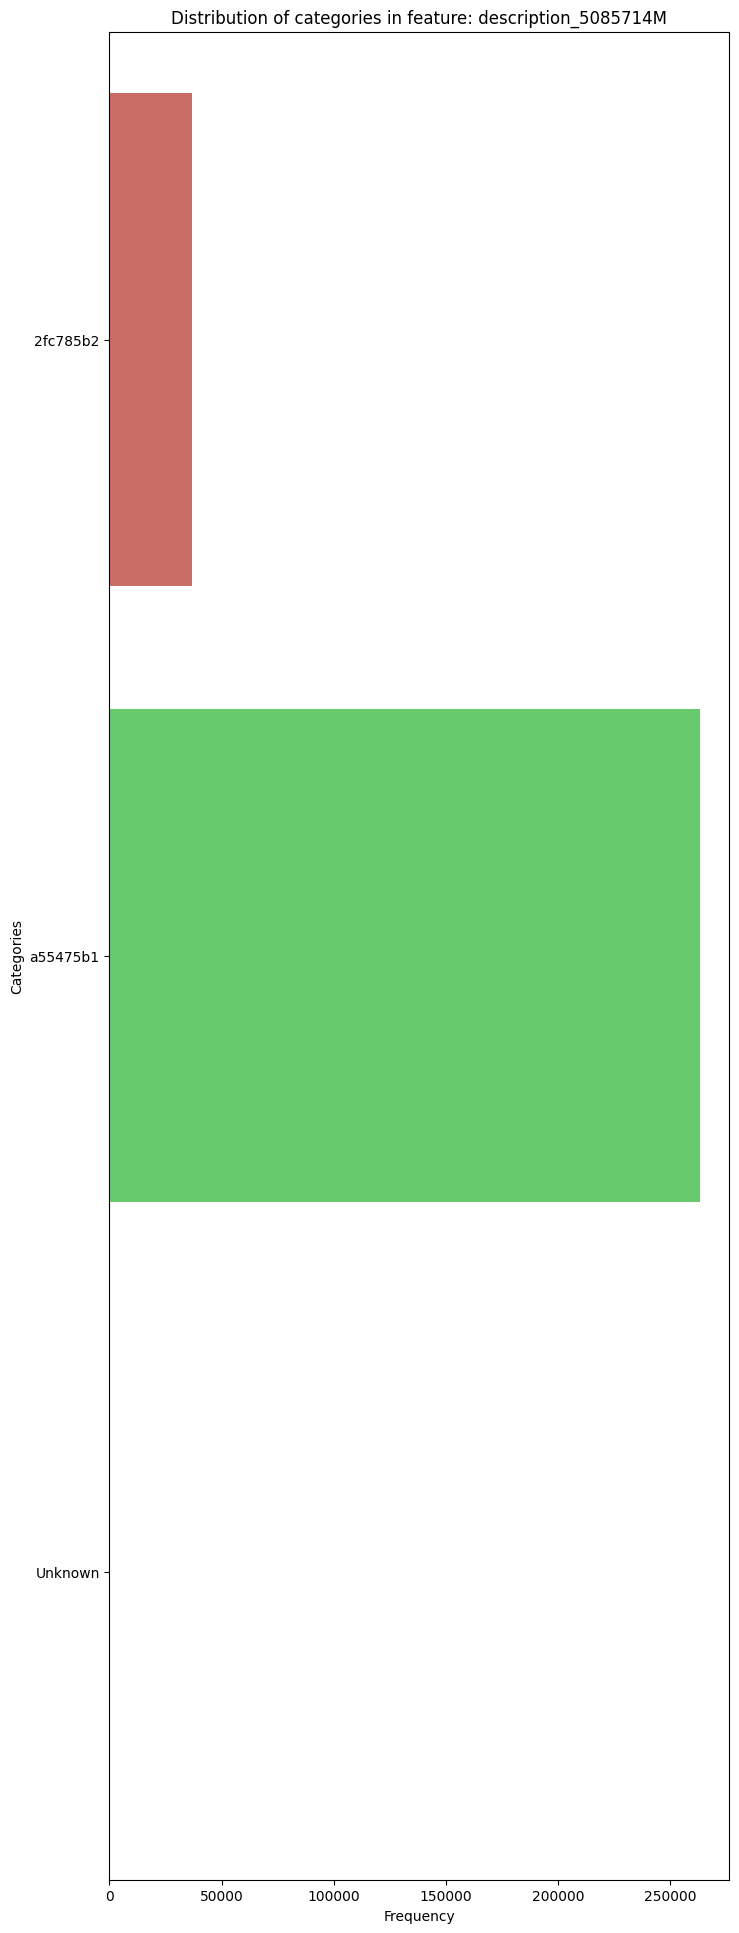

<ipython-input-28-a834786dcbb8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, palette=sns.color_palette("hls", len(df[col].unique())))


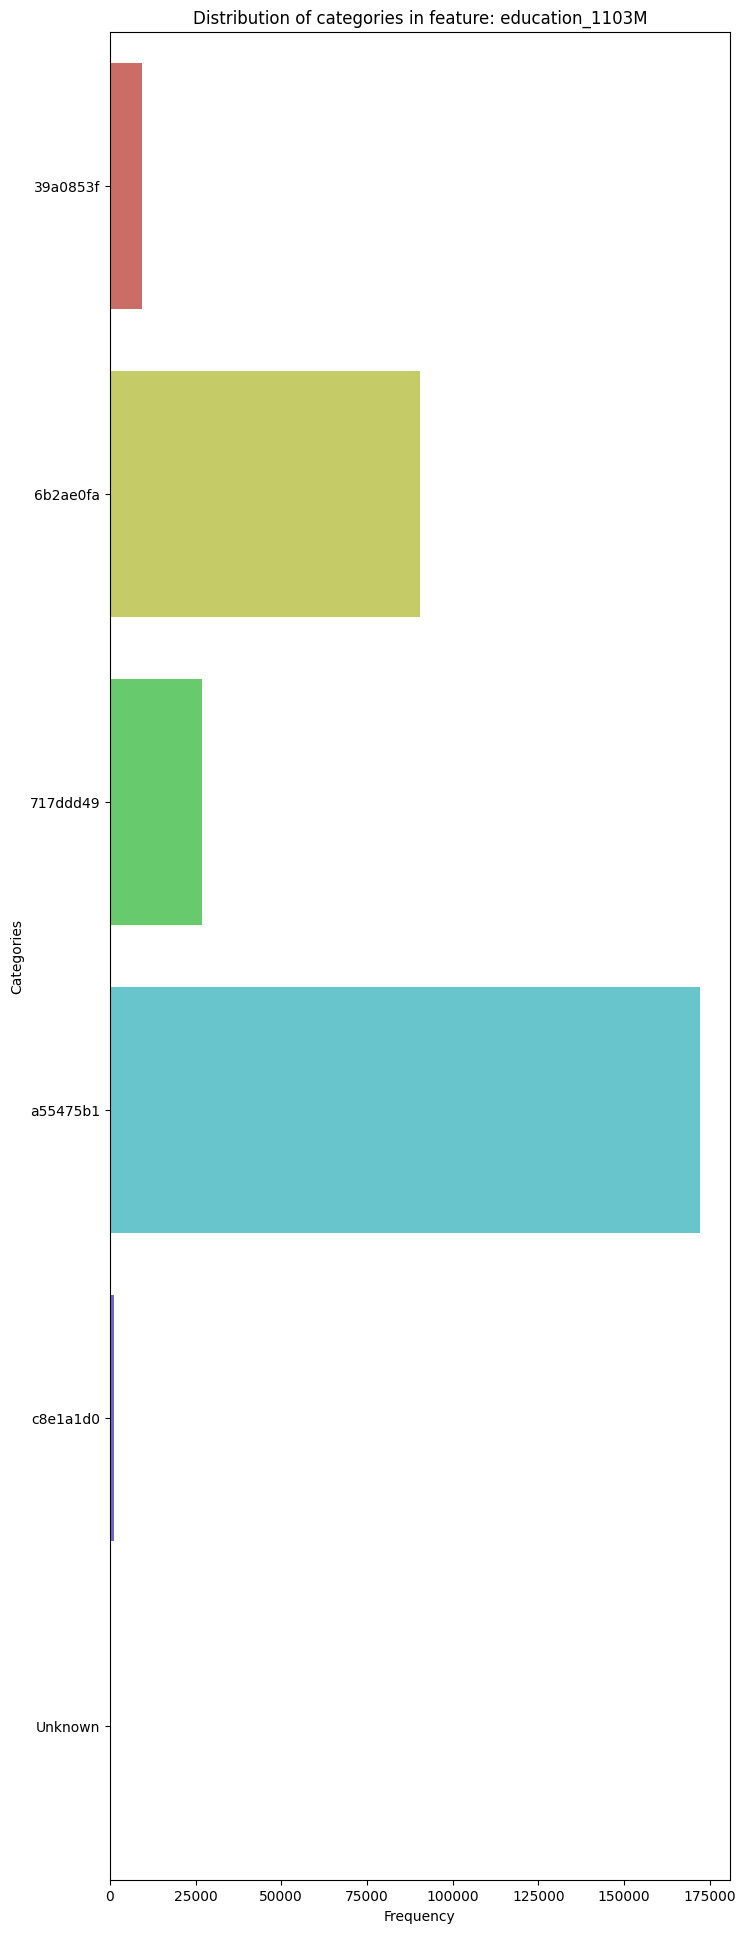

<ipython-input-28-a834786dcbb8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, palette=sns.color_palette("hls", len(df[col].unique())))


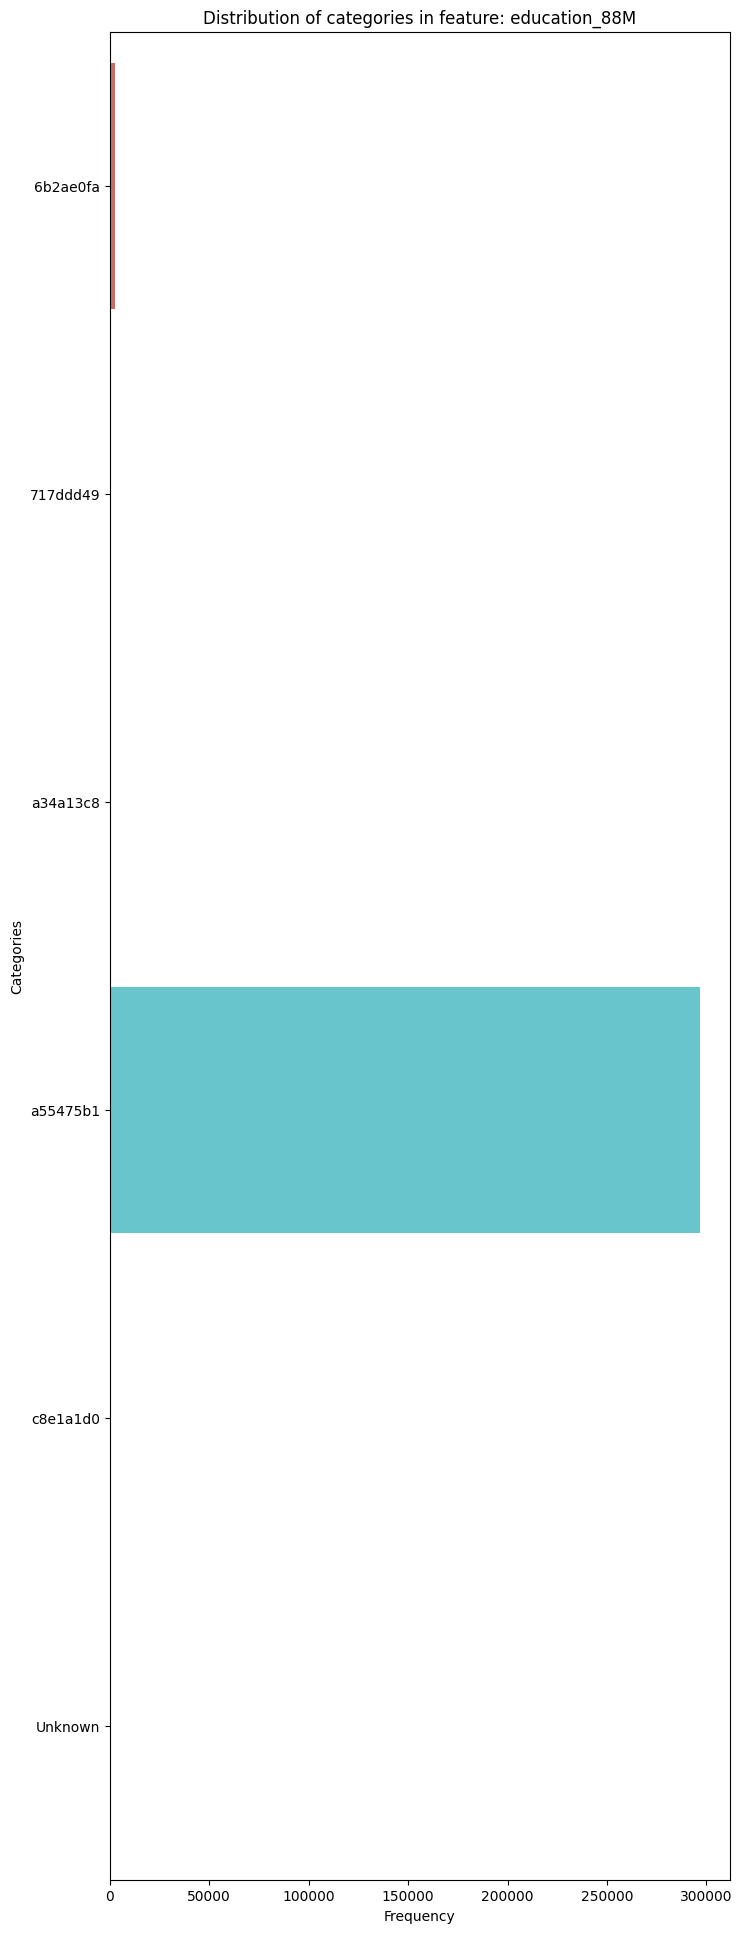

<ipython-input-28-a834786dcbb8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, palette=sns.color_palette("hls", len(df[col].unique())))


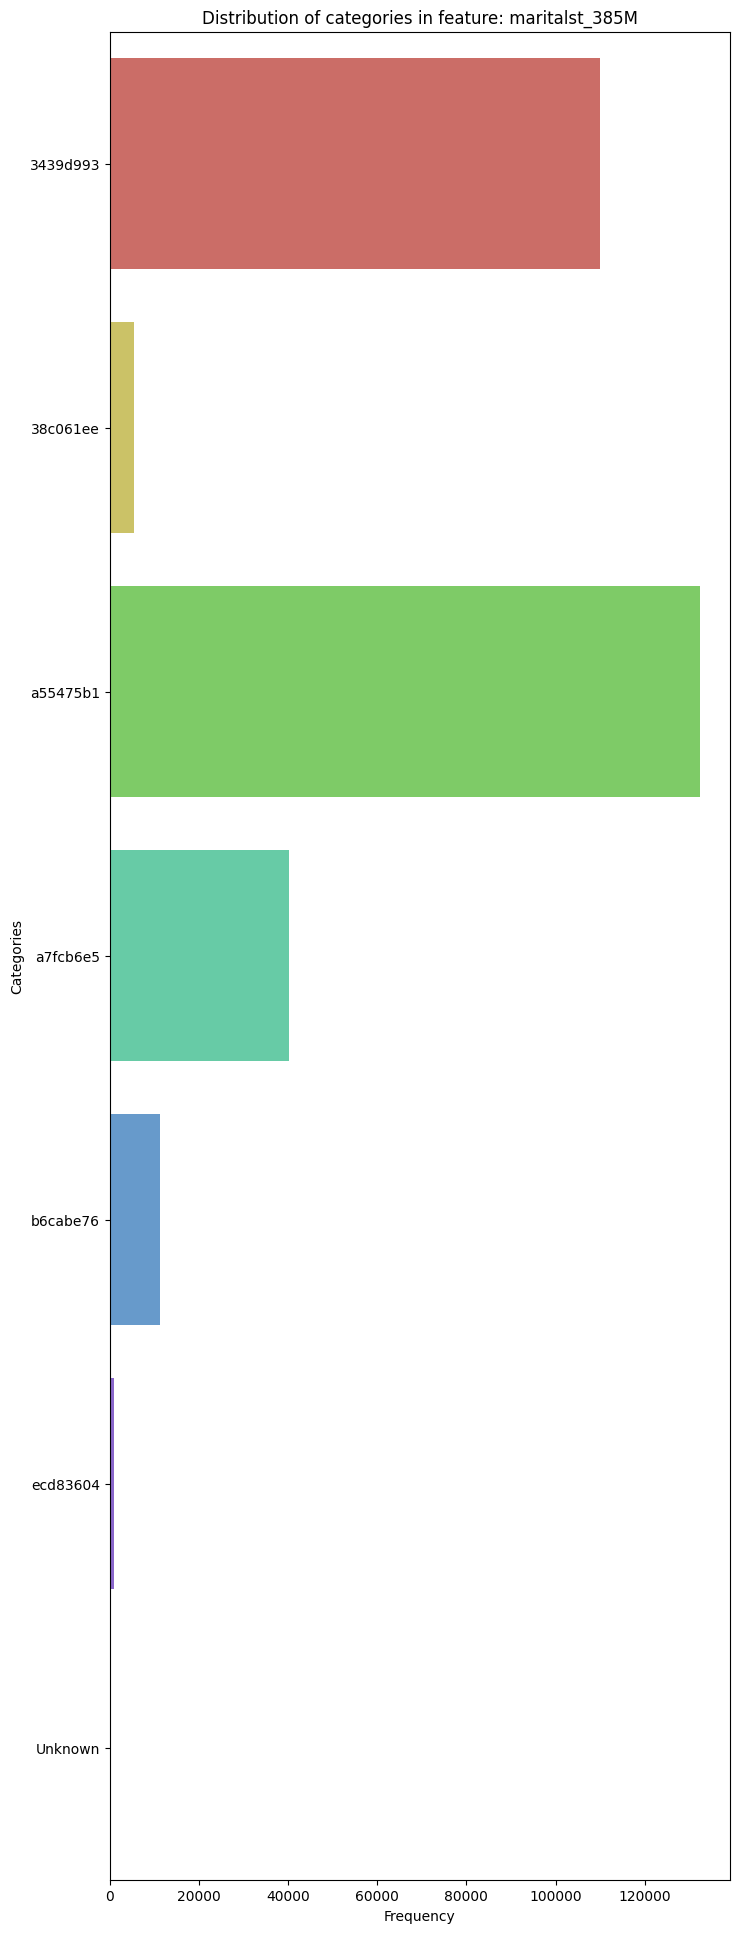

<ipython-input-28-a834786dcbb8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, palette=sns.color_palette("hls", len(df[col].unique())))


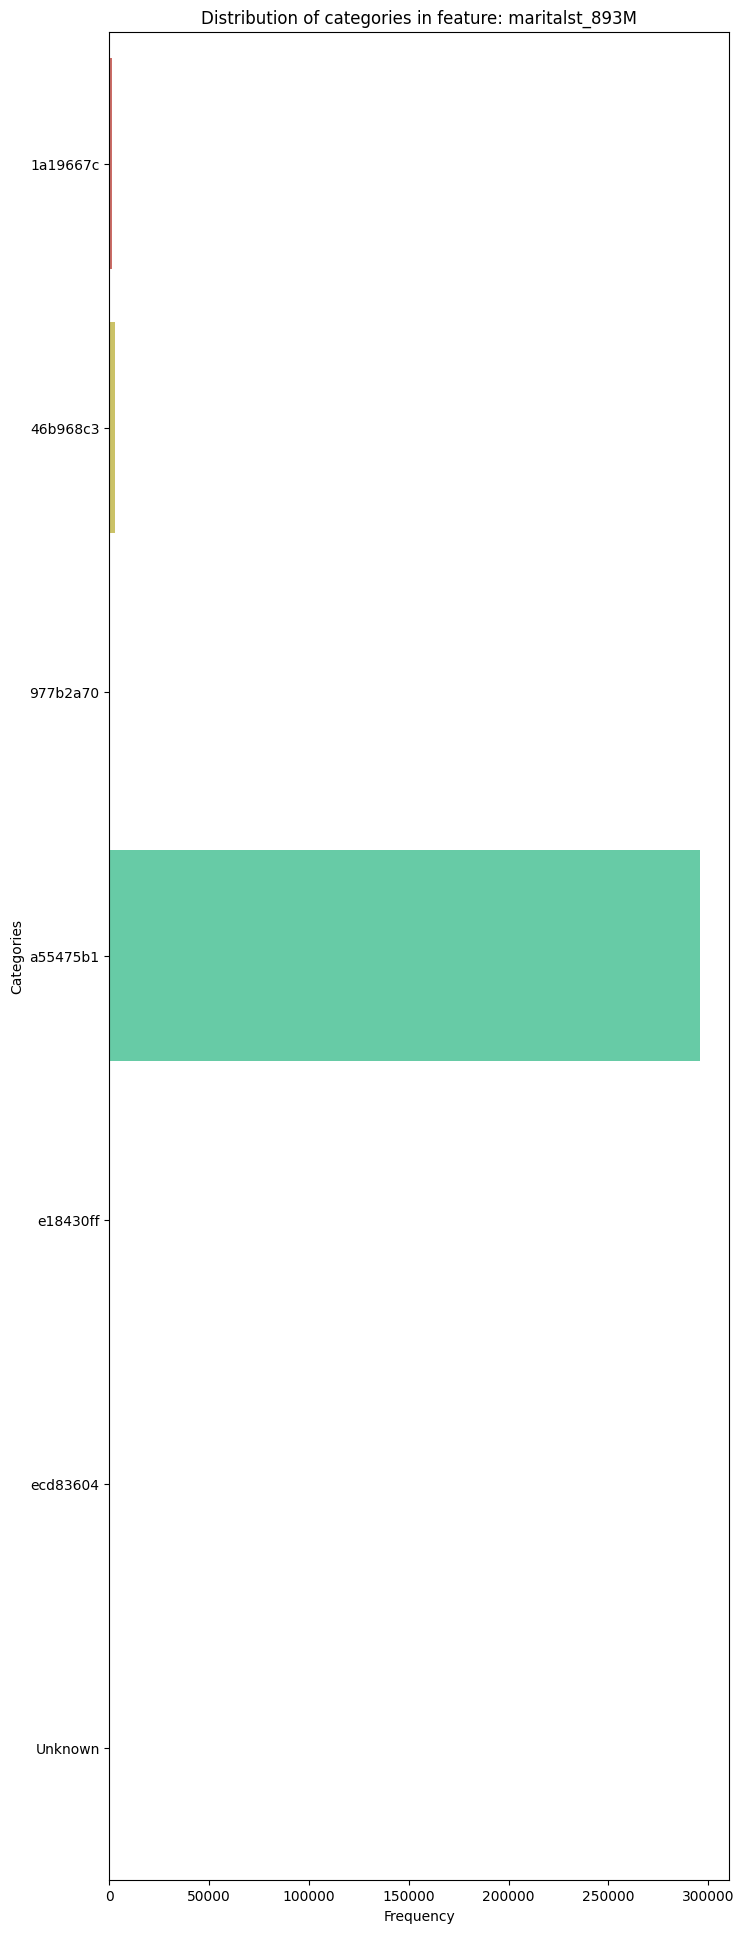

<Axes: xlabel='target', ylabel='Count'>

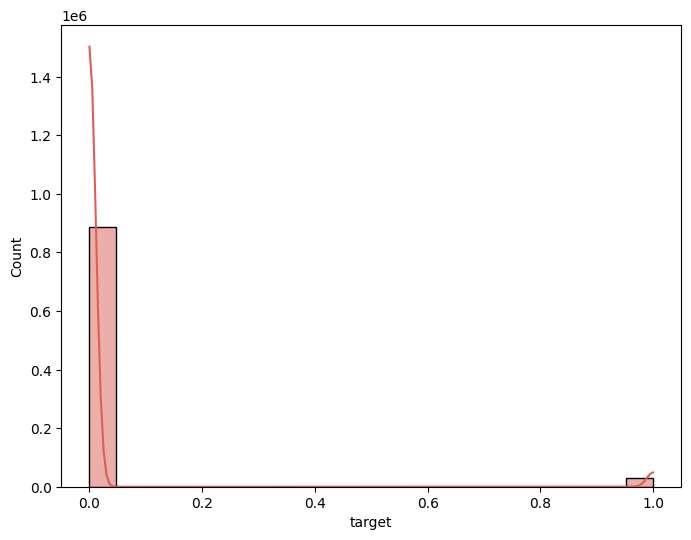

In [ ]:
for col in X_train.select_dtypes(include=['category']):
    # Create a count plot with horizontal bars
    plt.figure(figsize=(8, 24))
    sns.countplot(y=col, data=df, palette=sns.color_palette("hls", len(df[col].unique())))
    plt.title(f"Distribution of categories in feature: {col}")
    plt.xlabel("Frequency")
    plt.ylabel("Categories")
    plt.show()


# Target variable visualization
plt.figure(figsize=(8, 6))
sns.histplot(data=y_train, kde=True, color=colors[0])

# Missing

In [ ]:
print("Features with missing values:")
for feature, count in features_with_missing_values.items():
    print(f"{feature}: {count} missing values, which is {count/len(X_train):.2%} ")

Features with missing values:


In [ ]:

features_with_na= ['amtinstpaidbefduel24m_4187115A',
'annuitynextmonth_57A',
'avginstallast24m_3658937A',
'avglnamtstart24m_4525187A',
'avgoutstandbalancel6m_4187114A',
'avgpmtlast12m_4525200A',
'inittransactionamount_650A',
'lastapprcredamount_781A',
'lastotherinc_902A','lastotherlnsexpense_631A',
'lastrejectcredamount_222A',
'maininc_215A',
'maxannuity_159A',
'maxannuity_4075009A',
'maxdebt4_972A',
'maxinstallast24m_3658928A',
'maxlnamtstart6m_4525199A',
'maxoutstandbalancel12m_4187113A',
'maxpmtlast3m_4525190A',
'price_1097A',
'sumoutstandtotal_3546847A',
'sumoutstandtotalest_4493215A',
'totinstallast1m_4525188A',
'pmtaverage_3A:',
'pmtaverage_4527227A',
'pmtaverage_4955615A',
'pmtssum_45A']

In [ ]:
features_with_missing_values={}
for i, col in enumerate(X_train.select_dtypes(include=['int64', 'float64'])):
    # Count missing values
    missing_count = X_train[col].isna().sum()
    if missing_count > 0:
        print(f"Warning: Feature {col} has {missing_count} missing values ({missing_count/len(X_train):.2%}). Consider imputation.")
        features_with_missing_values[col] = missing_count

In [ ]:
for col in features_with_missing_values.keys():
    if col in X_train.columns:  # Check if feature exists in X_train
        plt.figure(figsize=(10, 6))
        sns.heatmap(X_train[[col]].isna().T, cmap='Blues', annot=True)
        plt.title(f"Missing Values in Feature: {col}")
        plt.xlabel("Missing Values (0: Filled, 1: Missing)")
        plt.xticks()  # Rotate x-axis labels for readability
        plt.show()

# One-Hot Encoding and Oversampling

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [ ]:
data_pd1 = data.to_pandas()

In [ ]:
fraud = data_pd1[data_pd1["target"] == 1]
normal = data_pd1[data_pd1["target"] == 0]

In [ ]:
print(len(fraud),"\n", len(normal))

47994 
 1478665


In [ ]:
X

NameError: name 'X' is not defined

In [ ]:
data_encoded = data_pd1.copy()
data_encoded.fillna(0, inplace=True)
data_encoded["date_decision"] = pd.to_datetime(data_encoded["date_decision"], format='%Y-%m-%d', errors='coerce').dt.year * 10000 + \
                                pd.to_datetime(data_encoded["date_decision"], format='%Y-%m-%d', errors='coerce').dt.month * 100 + \
                                pd.to_datetime(data_encoded["date_decision"], format='%Y-%m-%d', errors='coerce').dt.day

In [ ]:
data_encoded.to_csv("data_encoded_saved.csv", index=False)

In [ ]:
from tensorflow.python.client import device_lib
import tensorflow as tf

# tf.keras.backend.clear_session()
# print(device_lib.list_physical_devices('GPU'))

AttributeError: module 'tensorflow.python.client.device_lib' has no attribute 'list_physical_devices'

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

data_encoded = pd.read_csv("/content/drive/MyDrive/data_encoded_saved.csv")

<ipython-input-2-2b909da44f90>:4: DtypeWarning: Columns (55,57) have mixed types. Specify dtype option on import or set low_memory=False.
  data_encoded = pd.read_csv("/content/drive/MyDrive/data_encoded_saved.csv")


In [ ]:
data_encoded_copy = data_encoded.copy()

In [ ]:
null_count = data_encoded["mainoccupationinc_384A_any_selfemployed"].isnull().sum()
zero_count = (data_encoded["mainoccupationinc_384A_any_selfemployed"] == 0).sum()
one_count = (data_encoded["mainoccupationinc_384A_any_selfemployed"] == True).sum()
print(null_count, zero_count, one_count)

0 1497460 29199


In [ ]:
categorical_features = [col for col in data_encoded_copy.columns if data_encoded_copy[col].dtype == object]

In [ ]:
categorical_features

# ['lastapprcommoditycat_1041M',
#  'lastapprcommoditytypec_5251766M',
#  'lastcancelreason_561M',
#  'lastrejectcommoditycat_161M',
#  'lastrejectcommodtypec_5251769M',
#  'lastrejectreason_759M',
#  'lastrejectreasonclient_4145040M',
#  'previouscontdistrict_112M',
#  'description_5085714M',
#  'education_1103M',
#  'education_88M',
#  'maritalst_385M',
#  'maritalst_893M',
#  'person_housetype',
#  'pmts_dpdvalue_108P_over31']

['lastapprcommoditycat_1041M',
 'lastapprcommoditytypec_5251766M',
 'lastcancelreason_561M',
 'lastrejectcommoditycat_161M',
 'lastrejectcommodtypec_5251769M',
 'lastrejectreason_759M',
 'lastrejectreasonclient_4145040M',
 'previouscontdistrict_112M',
 'description_5085714M',
 'education_1103M',
 'education_88M',
 'maritalst_385M',
 'maritalst_893M',
 'mainoccupationinc_384A_any_selfemployed',
 'person_housetype',
 'pmts_dpdvalue_108P_over31']

#  Keeps crashing so use other method

In [ ]:
# Iterate through categorical features and perform one-hot encoding
for col in categorical_features[9:-2]:
    # Check if the feature has the expected data type (string)
    if data_encoded_copy[col].dtype == object:
        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        encoded_features = encoder.fit_transform(data_encoded_copy[[col]])  # Encode single feature

        # Add encoded features back to the DataFrame, dropping the original categorical feature
        data_encoded_copy.drop(col, axis=1, inplace=True)
        for i, new_col in enumerate(encoder.get_feature_names_out()):
            data_encoded_copy[new_col] = encoded_features[:, i]
    else:
        print(f"Warning: Skipping feature '{col}' because it's not a string (categorical).")

# Now your data_encoded DataFrame contains one-hot encoded features
print(data_encoded.head())

NameError: name 'categorical_features' is not defined

# Using concat to avoid crashing

In [ ]:
encoded_data = pd.DataFrame()  # Initialize an empty DataFrame to store encoded features

for col in categorical_features:
    if data_encoded_copy[col].dtype == object:
        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        encoded_features = encoder.fit_transform(data_encoded_copy[[col]])
        encoded_data = pd.concat([encoded_data, pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())], axis=1)
    else:
        print(f"Warning: Skipping feature '{col}' because it's not a string (categorical).")

# Combine encoded features with numerical features (if any)
final_df = pd.concat([data_encoded_copy.drop(categorical_features, axis=1), encoded_data], axis=1)

print(final_df.head())
print(len(final_df.columns))

In [ ]:
final_df.columns

In [ ]:
len(data_encoded_copy.columns)

In [ ]:
final_df.to_csv("final_df_some_categories_encoded.csv", index=False)

In [ ]:
final_df = pd.read_csv("final_df_some_categories_encoded.csv")

# Using batches to avoid crashing

In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl


In [ ]:
!nvidia-smi

Mon Feb 19 21:17:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install -U tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [ ]:
# Identify potential categorical features by data type and unique values (adjust thresholds as needed)
potential_categorical = [col for col in data_encoded_copy.columns if data_encoded_copy[col].dtype == object]
#  or data_encoded_copy[col].nunique() > 10]

# Define batch size
batch_size = 4

# Create an empty DataFrame to store encoded features
encoded_data = pd.DataFrame()
final_df = pd.DataFrame()
# Process features in batches
for i in range(0, len(potential_categorical[:-2]), batch_size):
    features_to_encode = potential_categorical[i:i+batch_size]
    encoded_features_set = set()  # Reset encoded features set for each batch

    # Iterate through the batch and perform one-hot encoding
    for col in features_to_encode:
        if col not in encoded_features_set and data_encoded_copy[col].dtype == object:
            print(col)
            encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            encoded_features = encoder.fit_transform(data_encoded_copy[[col]])
            encoded_data = pd.concat([encoded_data, pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())], axis=1)
            encoded_features_set.add(col)
        else:
            print(f"Skipping feature '{col}' because it's already encoded or not a string (categorical).")

    # Combine encoded features with numerical features and update final_df
    final_df = pd.concat([final_df if any(final_df) else data_encoded_copy.drop(potential_categorical, axis=1), encoded_data], axis=1)
    encoded_data = pd.DataFrame()  # Reset encoded_data for the next batch

# Check the resulting DataFrame
print(final_df.head())


lastapprcommoditycat_1041M
lastapprcommoditytypec_5251766M
lastcancelreason_561M
lastrejectcommoditycat_161M


In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.9 MB/s eta 0:00:00


# Tensorflow GPU utilization in batches

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

data_encoded = pd.read_csv("/content/drive/MyDrive/data_encoded_saved.csv")

data_encoded_copy = data_encoded.copy()

<ipython-input-2-3d84478e1f70>:4: DtypeWarning: Columns (55,57) have mixed types. Specify dtype option on import or set low_memory=False.
  data_encoded = pd.read_csv("/content/drive/MyDrive/data_encoded_saved.csv")


In [ ]:
import tensorflow as tf
from tensorflow_addons.utils import keras_utils

# Identify potential categorical features (unchanged)
potential_categorical = [col for col in data_encoded_copy.columns if data_encoded_copy[col].dtype == object]
#  or data_encoded_copy[col].nunique() > 10]

# Define batch size (unchanged)
batch_size = 2

# Create empty DataFrames for encoded data and final result (unchanged)
encoded_data = pd.DataFrame()
final_df = pd.DataFrame()

# Process features in batches (with GPU utilization)
for i in range(0, len(potential_categorical[:-2]), batch_size):
    features_to_encode = potential_categorical[i:i+batch_size]
    encoded_features_set = set()

    # --- Correction: Convert categorical data to integers before moving to GPU ---
    data_batch_int = pd.get_dummies(data_encoded_copy[features_to_encode], columns=features_to_encode)
    data_batch_gpu = tf.convert_to_tensor(data_batch_int) #, dtype=tf.int64)

    with tf.device('/gpu:0'):
        for col in features_to_encode:
            if col not in encoded_features_set and data_encoded_copy[col].dtype == object:
                print(col)

                # # Use tf.one_hot directly on the GPU for efficiency
                # encoded_features = tf.one_hot(data_batch_gpu[:, col], depth=data_encoded_copy[col].nunique())

                # Move encoded features back to CPU and convert to DataFrame
                col_index = features_to_encode.index(col)  # Get the integer index of the column
                depth = data_encoded_copy[col].nunique()
                encoded_features = tf.one_hot(data_batch_gpu[:, col_index], depth=data_encoded_copy[col].nunique())

                # encoded_data = pd.concat([encoded_data, pd.DataFrame(encoded_features.numpy(), columns=encoder.get_feature_names_out())], axis=1)
                encoded_data = pd.concat([encoded_data, pd.DataFrame(encoded_features.numpy(), columns=[f"{col}_{i}" for i in range(depth)])], axis=1)
                encoded_features_set.add(col)
            else:
                print(f"Skipping feature '{col}' because it's already encoded or not a string (categorical).")

    # Combine encoded features with numerical features and update final_df (unchanged)
    final_df = pd.concat([final_df if any(final_df) else data_encoded_copy.drop(potential_categorical, axis=1), encoded_data], axis=1)
    encoded_data = pd.DataFrame()  # Reset encoded_data for the next batch

# Check the resulting DataFrame (unchanged)
print(final_df.head())

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


lastapprcommoditycat_1041M
lastapprcommoditytypec_5251766M
lastcancelreason_561M
lastrejectcommoditycat_161M
lastrejectcommodtypec_5251769M
lastrejectreason_759M


In [ ]:
final_df.to_csv("one_hot_encoded_final_df.csv", index=False)

NameError: name 'final_df' is not defined

# Read dataframe in chunks

In [ ]:
# import pandas as pd
# final_df = pd.read_csv("/content/drive/MyDrive/final_df_after_tf_ohc.csv")
import dask.dataframe as dd

# Replace with your actual file path
filepath = "/content/drive/MyDrive/final_df_after_tf_ohc.csv"

# Define chunk size (adjust based on available memory)
chunksize = 10000  # Number of rows per chunk

# Read the file in chunks
# Create a Dask DataFrame by defining chunks manually
ddf = dd.read_csv(filepath, blocksize=chunksize * 400)  # Adjust blocksize for optimal performance

# Collect the results and create the final DataFrame
final_df = ddf.compute()

In [ ]:
final_df.fillna(0)

case_id  date_decision   MONTH  WEEK_NUM  target  \
0             0       20190103  201901         0       0   
1             1       20190103  201901         0       0   
2             2       20190104  201901         0       0   
3             3       20190103  201901         0       0   
4             4       20190104  201901         0       1   
...         ...            ...     ...       ...     ...   
489254   873787       20191124  201911        46       0   
489255   873788       20191124  201911        46       0   
489256   873789       20191124  201911        46       0   
489257   873790       20191124  201911        46       0   
489258   873791       20191124  201911        46       0   

        amtinstpaidbefduel24m_4187115A  annuity_780A  annuitynextmonth_57A  \
0                                  0.0        1917.6                   0.0   
1                                  0.0        3134.0                   0.0   
2                                  0.0        4937.0                   0.0   
3                                  0.0        4643.6                   0.0   
4                                  0.0        3390.2                   0.0   
...                                ...           ...                   ...   
489254                             0.0        9058.2                   0.0   
489255                             0.0        8405.8                   0.0   
489256                             0.0        7623.0                   0.0   
489257                             0.0        1932.6                   0.0   
489258                             0.0        3301.8                   0.0   

        avginstallast24m_3658937A  avglnamtstart24m_4525187A  ...  \
0                             0.0                        0.0  ...   
1                             0.0                        0.0  ...   
2                             0.0                        0.0  ...   
3                             0.0                        0.0  ...   
4                             0.0                        0.0  ...   
...                           ...                        ...  ...   
489254                        0.0                        0.0  ...   
489255                        0.0                        0.0  ...   
489256                        0.0                        0.0  ...   
489257                        0.0                        0.0  ...   
489258                        0.0                        0.0  ...   

        maritalst_893M_1a19667c  maritalst_893M_46b968c3  \
0                           0.0                      0.0   
1                           0.0                      0.0   
2                           0.0                      0.0   
3                           0.0                      0.0   
4                           0.0                      0.0   
...                         ...                      ...   
489254                      0.0                      0.0   
489255                      0.0                      0.0   
489256                      0.0                      0.0   
489257                      0.0                      0.0   
489258                      0.0                      0.0   

        maritalst_893M_977b2a70  maritalst_893M_a55475b1  \
0                           0.0                      0.0   
1                           0.0                      0.0   
2                           0.0                      0.0   
3                           0.0                      0.0   
4                           0.0                      0.0   
...                         ...                      ...   
489254                      0.0                      1.0   
489255                      0.0                      1.0   
489256                      0.0                      1.0   
489257                      0.0                      1.0   
489258                      0.0                      0.0   

        maritalst_893M_e18430ff  maritalst_893M_ecd83604  maritalst_893M_nan  \

In [ ]:
from sklearn.model_selection import train_test_split
X = final_df.drop("target", axis=1)
y = final_df["target"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the split data
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (391407, 701)
X_test shape: (97852, 701)
y_train shape: (391407,)
y_test shape: (97852,)


In [ ]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss

In [ ]:
smk =SMOTETomek(random_state=42)
X_train.fillna(0, inplace=True)

In [ ]:
final_df.shape

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
X.fillna(0, inplace=True)

In [ ]:
X_test.fillna(0, inplace=True)

In [ ]:
fraud = final_df[final_df["target"]==1]
normal = final_df[final_df["target"]==0]

In [ ]:
print(fraud.shape, normal.shape)

In [ ]:
X_res, y_res = smk.fit(X, y)


In [ ]:
import dask.dataframe as dd

# Replace with your actual file path
filepath = "path/to/your/file.csv"

# Define chunk size (adjust based on available memory)
chunksize = 10000  # Number of rows per chunk

# Read the file in chunks
ddf = dd.read_csv(filepath, chunksize=chunksize)

# Define your processing function for each chunk
def process_chunk(chunk):
  # Perform your desired operations on the chunk's DataFrame
  processed_chunk = chunk # Replace with your processing logic
  return processed_chunk

# Apply the processing function to each chunk in parallel
processed_ddf = ddf.map_partitions(process_chunk)

# Collect the results and create the final DataFrame
final_df = processed_ddf.compute()

# Now you can work with the final_df which contains all processed data



# RandomOverSampler

In [ ]:
from imblearn.over_sampling import RandomOverSampler
os = RandomOverSampler()

X_train_res, y_train_res = os.fit_resample(X_train, y_train)
X_test_res, y_test_res = os.fit_resample(X_test, y_test)

NameError: name 'X_train' is not defined

In [ ]:
print(X_train_res.shape, y_train_res.shape)

In [ ]:
print(X_test_res.shape, y_test_res.shape)

In [ ]:
X_train_res.to_csv("X_train_res_oversampled.csv")
y_train_res.to_csv("y_train_res_oversampled.csv")
X_test_res.to_csv("X_test_res_oversampled.csv")
y_test_res.to_csv("y_test_res_oversampled.csv")

In [ ]:
# prompt: visualize X_train_res, y_train_res

import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=X_train_res, x=y_train_res, bins=10)
plt.show()

sns.histplot(data=X_test_res, x=y_test_res, bins=10)
plt.show()


In [ ]:
# prompt: get feature correlation matrix for X_train_res as a heatmap

import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = X_train_res.corr()

sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f")
plt.show()


In [ ]:
sorted(data_encoded_copy_2.columns)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

data_encoded_copy_2 = data_encoded.drop("target", axis=1)
data_encoded_copy_2 = data_encoded_copy_2.drop("case_id", axis=1)
data_encoded_copy_2 = data_encoded_copy_2.drop("MONTH", axis=1)
data_encoded_copy_2 = data_encoded_copy_2.drop("date_decision", axis=1)
data_encoded_copy_2 = data_encoded_copy_2.drop("WEEK_NUM", axis=1)
corr_matrix = data_encoded_copy_2.corr()

sns.heatmap(corr_matrix, annot=False, cmap="rocket", fmt=".4f")
plt.show()

In [ ]:
!pip install --upgrade plotly.express

In [ ]:
import pandas as pd
from plotly.subplots import make_subplots
from plotly.express import px

# Prepare data
df = data_encoded.copy()  # Make a copy

# Ensure numerical values
df.select_dtypes(include='object', inplace=True)  # Select object columns
for col in df.select_dtypes(include='object'):
    try:
        df[col] = df[col].astype('category').cat.codes  # Convert to numerical
    except (AttributeError, KeyError) as e:
        print(f"Warning: Error converting column '{col}': {e}")

# Calculate correlation matrix
corr_matrix = df.corr()

# Get column names automatically
column_names = df.columns.tolist()

# Create plotly subplots and add heatmap
fig = make_subplots(rows=1, cols=1)

fig.add_trace(px.imshow(
    z=corr_matrix,
    color_continuous_scale="RdBu",  # Adjust color scale as needed
    x=column_names,
    y=column_names,
    hoverinfo="z",
    title="Interactive Heatmap of Correlations for all Features",
))

# Update layout for interactivity
fig.update_layout(
    title="Interactive Heatmap of Correlations",
    titlefont_size=20,
    plot_bgcolor="white",
    xaxis_title="Feature A",
    yaxis_title="Feature B",
    hovermode="closest",
    dragmode="zoom",
)

# Show the interactive heatmap
fig.show()

print("Done!")


In [ ]:
!pip install bokeh


In [ ]:
from bokeh.io import output_file
output_file('inline')

In [ ]:
from bokeh.io import output_file
output_file('inline')

import pandas as pd
from bokeh.palettes import RdBu  # Color palette
from bokeh.io import show
from bokeh.models import ColumnDataSource, ColorBar, HoverTool, LinearColorMapper, NumeralTickFormatter
from bokeh.plotting import figure

# Prepare data (assumed you have this already)
df = data_encoded_copy_2.copy()  # Make a copy

# Ensure numerical values, error handling included
try:
    df = df.select_dtypes(include='object')
    for col in df.select_dtypes(include='object'):
        try:
            df[col] = df[col].astype('category').cat.codes
        except (AttributeError, KeyError) as e:
            print(f"Warning: Error converting column '{col}': {e}")
except Exception as e:
    print(f"Error processing data: {e}")
    print("Check data types and handle potential errors.")

# Get feature names automatically
features = df.columns.tolist()

# Calculate correctly shaped correlation matrix
try:
    corr_matrix = df.corr().values  # Flatten for correct dimensions
except Exception as e:
    print(f"Error calculating correlation matrix: {e}")
    print("Check data types and handle potential errors in the DataFrame.")

your_dictionary = {
    "strongly_negative": "#d7191c",  # Red for strong negative correlation
    "weakly_negative": "#f4a582",  # Orange for weak negative correlation
    "neutral": "#d9d9d9",  # Gray for neutral correlation
    "weakly_positive": "#92c5de",  # Light blue for weak positive correlation
    "strongly_positive": "#053061",  # Dark blue for strong positive correlation
}

# Extract individual colors from your dictionary (assuming specific keys)
color_palette = []
for value in sorted(your_dictionary.keys()):
    color_palette.append(your_dictionary[value])

# Prepare Bokeh data source
source = ColumnDataSource(dict(
    x=features,
    y=features,
    z=corr_matrix,
))

# Create Bokeh figure
p = figure(
    title="Interactive Heatmap of Correlations",
    x_range=features,
    y_range=features,
    toolbar_location=None,
    tools="",
)

# Create color mapper using extracted colors
mapper = LinearColorMapper(palette=color_palette, low=corr_matrix.min(), high=corr_matrix.max())

# Add heatmap and color mapper
p.rect(
    x="x",
    y="y",
    width=0.9,
    height=0.9,
    source=source,
    fill_color={"field": "z", "transform": mapper},  # Use mapper for color
    line_color=None,
)

# Add colorbar
colorbar = ColorBar(
    color_mapper=mapper,
    location=(0, 0),
    width=50,
    height=p.height,
    title="Correlation",
)
p.add_layout(colorbar)

# Hover tool with dynamic feature names
hover = HoverTool()
hover.tooltips = [
    ("Feature 1", "@x"),
    ("Feature 2", "@y"),
    ("Correlation", "@z{0.00}"),
]
p.add_tools(hover)

# Customize axes and grid
p.axis.axis_label = None
p.axis.major_tick_line_color = None
p.grid.grid_line_color = None

# Show interactive heatmap
show(p)

print("Done!")


In [ ]:
from bokeh.io import output_file
output_file('inline')

import pandas as pd
from bokeh.palettes import RdBu  # Color palette
from bokeh.io import show
from bokeh.models import ColumnDataSource, ColorBar, HoverTool, LinearColorMapper, NumeralTickFormatter
from bokeh.plotting import figure

# Prepare data (assumed you have this already)
df = data_encoded_copy_2.copy()  # Make a copy

# Ensure numerical values, error handling included
try:
    df = df.select_dtypes(include='object')
    for col in df.select_dtypes(include='object'):
        try:
            df[col] = df[col].astype('category').cat.codes
        except (AttributeError, KeyError) as e:
            print(f"Warning: Error converting column '{col}': {e}")
except Exception as e:
    print(f"Error processing data: {e}")
    print("Check data types and handle potential errors.")

# Get feature names automatically
features = df.columns.tolist()

# Calculate correctly shaped correlation matrix
try:
    corr_matrix = df.corr().values  # Flatten for correct dimensions
except Exception as e:
    print(f"Error calculating correlation matrix: {e}")
    print("Check data types and handle potential errors in the DataFrame.")

your_dictionary = {
    "strongly_negative": "#d7191c",  # Red for strong negative correlation
    "weakly_negative": "#f4a582",  # Orange for weak negative correlation
    "neutral": "#d9d9d9",  # Gray for neutral correlation
    "weakly_positive": "#92c5de",  # Light blue for weak positive correlation
    "strongly_positive": "#053061",  # Dark blue for strong positive correlation
}

# Extract individual colors from your dictionary (assuming specific keys)
color_palette = []
for value in sorted(your_dictionary.keys()):
    color_palette.append(your_dictionary[value])

# Prepare Bokeh data source
source = ColumnDataSource(dict(
    x=features,
    y=features,
    z=corr_matrix,
))

# Create Bokeh figure
p = figure(
    title="Interactive Heatmap of Correlations",
    x_range=features,
    y_range=features,
    toolbar_location=None,
    tools="",
)

# Create color mapper using extracted colors
mapper = LinearColorMapper(palette=color_palette, low=corr_matrix.min(), high=corr_matrix.max())

# Add heatmap and color mapper
p.rect(
    x="x",
    y="y",
    width=0.9,
    height=0.9,
    source=source,
    fill_color={"field": "z", "transform": mapper},  # Use mapper for color
    line_color=None,
)

# Add colorbar
colorbar = ColorBar(
    color_mapper=mapper,
    location=(0, 0),
    width=50,
    height=p.height,
    title="Correlation",
)
p.add_layout(colorbar)

# Hover tool with dynamic feature names
hover = HoverTool()
hover.tooltips = [
    ("Feature 1", "@x"),
    ("Feature 2", "@y"),
    ("Correlation", "@z{0.00}"),
]
p.add_tools(hover)

# Customize axes and grid
p.axis.axis_label = None
p.axis.major_tick_line_color = None
p.grid.grid_line_color = None

# Show interactive heatmap
show(p)

print("Done!")


In [ ]:
import bokeh
print(bokeh.__version__)